# Overview

In this exercise, I will analyse and explore the performance of a market making strategy from the data in `fills_data.parq` and `market_data.parq`. 

The strategy generated in `fills_data.parq` quotes on the bid and ask, with the goal of providing liquidity while at the same time minimizing positional risk. Note that because the strategy is market making on a spot symbol, it cannot go short. Instead, it will market make around a target inventory. 

This notebook will have the following sections:

1. Data Exploration: Understanding the data
2. Investigating the PnL: Calculating the PnL, bucketing the PnL, and using multi-linear regression on PnL to rank the factors significant to the PnL
3. Strategy Behaviour: Exploring potential trading patterns by investigation and classification models
4. Deeper Dive on Market Impact: Investigating the impact of the trading strategy on market prices

In [1]:
# Install the necessary dependencies
!pip install -q pandas
!pip install -q pyarrow
!pip install -q matplotlib
!pip install -q scipy
!pip install -q numpy
!pip install -q seaborn
!pip install scikit-learn
!pip install statsmodels


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [2]:
# Import the necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
import statsmodels.api as sm

from scipy.stats import shapiro
from scipy.stats import spearmanr
from scipy.stats import normaltest
from scipy.stats import pearsonr
from scipy.stats import kruskal
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import Ridge, LassoCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings('ignore')  # Turn off warning messages

Please make sure the files are in the `data` folder, and the folder is located in the same directory as this notebook.

In [3]:
# Reading the provided files
fills_data = pd.read_parquet('./data/fills_data.parq', engine='pyarrow')
market_data = pd.read_parquet('./data/market_data.parq', engine='pyarrow')

## Data Exploration: Understanding the Data

This section involves investigating the data from `fills_data.parq` and `market_data.parq` and making sure that the data is clean and ready for analysis.

In [4]:
# Check how many rows and features does the fill data have
print(f"The fills data has {fills_data.shape[0]} rows and {fills_data.shape[1]} columns\n")
fills_data

The fills data has 1123 rows and 12 columns



order_id side  fill_prc  fill_qty  \
timestamp                                                              
2023-07-01 00:46:05.617580  670003026938216    S   1937.83    0.0690   
2023-07-01 06:52:59.387733  670003026940777    B   1920.53    0.0264   
2023-07-01 09:19:52.809436  670003026941465    B   1914.23    0.0707   
2023-07-01 10:16:21.048157  670003026941676    B   1916.97    0.1719   
2023-07-01 14:37:25.452850  670003026943147    S   1921.43    0.1719   
...                                     ...  ...       ...       ...   
2023-07-15 16:18:25.726018  670008617129681    B   1935.21    0.1719   
2023-07-15 16:19:06.461829  670008617129719    B   1936.04    0.1719   
2023-07-15 18:39:02.613882  670008617130081    S   1939.44    0.0670   
2023-07-15 18:39:02.614281  670008617130071    S   1939.87    0.0674   
2023-07-15 19:04:52.935896  670008617130139    B   1935.97    0.0666   

                           liquidity       fee fee_ccy  fee_ccy_usd_rate  \
timestamp                                                                  
2023-07-01 00:46:05.617580     Maker  0.000000     bnb        237.395823   
2023-07-01 06:52:59.387733     Maker  0.000000     bnb        237.395823   
2023-07-01 09:19:52.809436     Maker  0.000000     bnb        237.395823   
2023-07-01 10:16:21.048157     Taker  0.000305     bnb        237.395823   
2023-07-01 14:37:25.452850     Maker  0.000000     bnb        237.395823   
...                              ...       ...     ...               ...   
2023-07-15 16:18:25.726018     Taker  0.000299     bnb        259.829225   
2023-07-15 16:19:06.461829     Taker  0.000299     bnb        259.829225   
2023-07-15 18:39:02.613882     Maker  0.000000     bnb        259.829225   
2023-07-15 18:39:02.614281     Maker  0.000000     bnb        259.829225   
2023-07-15 19:04:52.935896     Maker  0.000000     bnb        259.829225   

                                        fill_id    symbol     exch  balance  
timestamp                                                                    
2023-07-01 00:46:05.617580  1688172365615000000  eth_usdc  binance   0.3755  
2023-07-01 06:52:59.387733  1688194379383000000  eth_usdc  binance   0.4019  
2023-07-01 09:19:52.809436  1688203192806000000  eth_usdc  binance   0.4726  
2023-07-01 10:16:21.048157  1688206581043000000  eth_usdc  binance   0.6445  
2023-07-01 14:37:25.452850  1688222245450000000  eth_usdc  binance   0.4726  
...                                         ...       ...      ...      ...  
2023-07-15 16:18:25.726018  1689437905700000000  eth_usdc  binance   0.4808  
2023-07-15 16:19:06.461829  1689437946423000000  eth_usdc  binance   0.6527  
2023-07-15 18:39:02.613882  1689446342610000000  eth_usdc  binance   0.5857  
2023-07-15 18:39:02.614281  1689446342610000001  eth_usdc  binance   0.5183  
2023-07-15 19:04:52.935896  1689447892932000000  eth_usdc  binance   0.5849  

[1123 rows x 12 columns]

In [5]:
# Note that statistics for order_id and fill_id are not meaningful since they are identificiation numbers
fills_data.describe()

order_id     fill_prc     fill_qty          fee  fee_ccy_usd_rate  \
count  1.123000e+03  1123.000000  1123.000000  1123.000000       1123.000000   
mean   6.700046e+14  1934.634034     0.070110     0.000020        242.613197   
std    2.450876e+09    48.484356     0.033944     0.000073          4.742499   
min    6.700020e+14  1827.960000     0.000100     0.000000        235.954209   
25%    6.700034e+14  1895.555000     0.066300     0.000000        241.419819   
50%    6.700034e+14  1933.270000     0.068300     0.000000        241.419819   
75%    6.700040e+14  1974.705000     0.070200     0.000000        243.423520   
max    6.700096e+14  2029.450000     0.171900     0.000310        259.829225   

            fill_id      balance  
count  1.123000e+03  1123.000000  
mean   1.688934e+18     0.537670  
std    3.829630e+14     0.181855  
min    1.688172e+18     0.080200  
25%    1.688554e+18     0.400750  
50%    1.689163e+18     0.545900  
75%    1.689270e+18     0.679150  
max    1.689448e+18     0.962300

In [6]:
unique_values = fills_data.nunique()
nan_values = fills_data.isna().sum()
non_nan_counts = fills_data.count()
duplicate_values = non_nan_counts - unique_values

summary = pd.DataFrame({
    'Unique Values': unique_values,
    'NaN Values': nan_values,
    'Duplicate Values': duplicate_values
})

summary

Unique Values  NaN Values  Duplicate Values
order_id                   1060           0                63
side                          2           0              1121
fill_prc                   1034           0                89
fill_qty                    248           0               875
liquidity                     2           0              1121
fee                          80           0              1043
fee_ccy                       1           0              1122
fee_ccy_usd_rate              8           0              1115
fill_id                    1123           0                 0
symbol                        1           0              1122
exch                          1           0              1122
balance                    1085           0                38

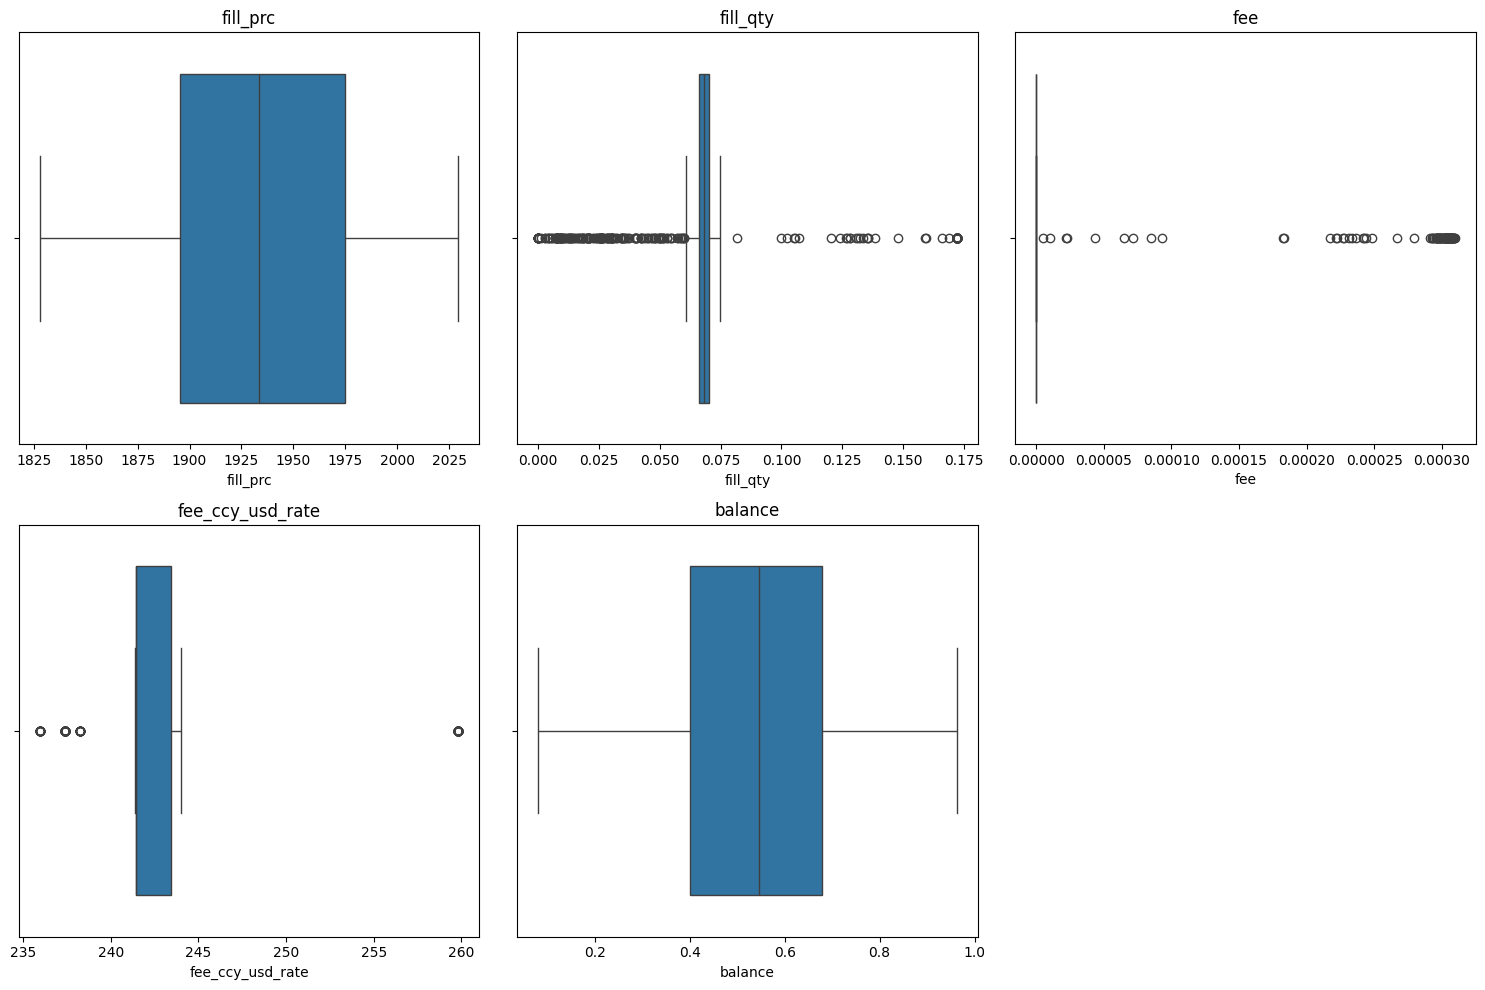

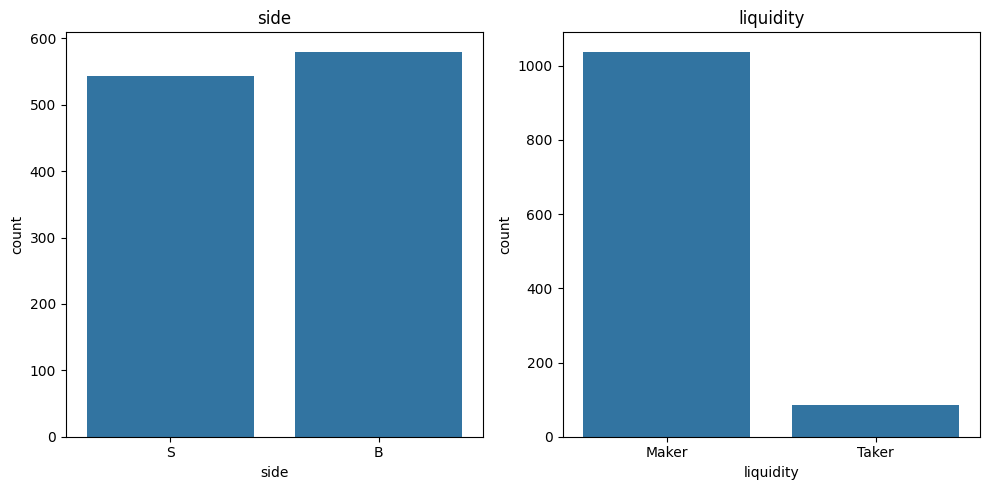

In [7]:
quantiative_features = ['fill_prc', 'fill_qty', 'fee', 'fee_ccy_usd_rate', 'balance']
categorical_features = ['side', 'liquidity']

plt.figure(figsize=(15, 10))
for i, feature in enumerate(quantiative_features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x=fills_data[feature])
    plt.title(feature)

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(1, 2, i)
    sns.countplot(x=fills_data[feature])
    plt.title(feature)

plt.tight_layout()
plt.show()

In [8]:
def detect_outliers(data, features):
    outliers_dict = {}
    for feature in features:
        Q1 = np.percentile(data[feature], 25)
        Q3 = np.percentile(data[feature], 75)
        IQR = Q3 - Q1
        outlier_step = 1.5 * IQR
        
        outliers_feature = data[(data[feature] < Q1 - outlier_step) | (data[feature] > Q3 + outlier_step)][feature]
        outliers_dict[feature] = outliers_feature.values
        
    return outliers_dict

quantitative_outliers = detect_outliers(fills_data, quantiative_features)

for feature, values in quantitative_outliers.items():
    print(f"Outliers for {feature}: {values}\n")

Outliers for fill_prc: []

Outliers for fill_qty: [2.640e-02 1.719e-01 1.719e-01 1.268e-01 5.840e-02 1.719e-01 1.719e-01
 1.719e-01 2.140e-02 4.760e-02 1.051e-01 1.719e-01 1.700e-02 1.210e-02
 1.290e-02 5.310e-02 1.719e-01 1.719e-01 1.719e-01 2.910e-02 5.740e-02
 4.800e-02 2.040e-02 1.000e-04 1.719e-01 1.719e-01 1.400e-02 1.000e-04
 7.000e-03 2.100e-02 2.100e-02 4.780e-02 1.241e-01 1.719e-01 1.304e-01
 4.400e-03 1.719e-01 1.719e-01 1.719e-01 1.719e-01 1.719e-01 4.660e-02
 2.060e-02 1.719e-01 1.000e-04 2.300e-02 3.690e-02 1.021e-01 4.300e-03
 1.719e-01 1.719e-01 3.460e-02 9.700e-03 1.719e-01 1.719e-01 1.719e-01
 8.000e-03 8.000e-03 5.060e-02 1.780e-02 1.719e-01 1.719e-01 8.170e-02
 2.420e-02 1.477e-01 2.900e-03 2.550e-02 2.060e-02 1.719e-01 5.150e-02
 1.204e-01 3.730e-02 4.000e-03 5.190e-02 1.480e-02 1.000e-04 2.610e-02
 1.000e-04 5.900e-02 3.490e-02 1.719e-01 1.719e-01 1.719e-01 1.719e-01
 1.321e-01 3.980e-02 1.719e-01 1.267e-01 4.520e-02 1.000e-01 1.283e-01
 4.360e-02 1.056e-01 1.719e

After inspecting the data in `fills_data`, here are some of the conclusions I made: 

1. Looking at the summary of the statistics for each feature, none of them raise any red flags. There were no negative values where there shouldn't be, and the data types were as expected.
2. We do not have NaN values in any of the features.
3. While initially I thought that duplicates in `order_id` was concerning, I realised they were perfectly normal and indicative of something I read up on called `Iceberg` orders. The only feature that is required to be unique is `fill_id`, and that is the case.
4. Observing our quantitative features, `fill_qty` and `fee_ccy_usd_rate` have outliers. However, thinking about the nature of the data, it seems reasonable that `fill_qty` to have outliers as they represent demand for larger and smaller orders. The same goes for `fee_ccy_usd_rate` as it represents the fee for potentially said larger/smaller transactions.

In [9]:
# Same same for market data
print(f"The fills data has {market_data.shape[0]} rows and {market_data.shape[1]} columns\n")
market_data

The fills data has 1208954 rows and 3 columns



bid_prc  ask_prc            symbol
timestamp                                                           
2023-06-30 23:45:00.958000+00:00  1934.84  1934.85  binance_eth_usdt
2023-06-30 23:45:01.958000+00:00  1933.77  1933.78  binance_eth_usdt
2023-06-30 23:45:02.958000+00:00  1933.77  1933.78  binance_eth_usdt
2023-06-30 23:45:03.959000+00:00  1933.77  1933.78  binance_eth_usdt
2023-06-30 23:45:04.960000+00:00  1933.77  1933.78  binance_eth_usdt
...                                   ...      ...               ...
2023-07-15 00:14:55.900000+00:00  1932.34  1932.35  binance_eth_usdt
2023-07-15 00:14:56.600000+00:00  1932.34  1932.35  binance_eth_usdt
2023-07-15 00:14:57.701000+00:00  1932.34  1932.35  binance_eth_usdt
2023-07-15 00:14:58.901000+00:00  1932.34  1932.35  binance_eth_usdt
2023-07-15 00:14:59.902000+00:00  1932.34  1932.35  binance_eth_usdt

[1208954 rows x 3 columns]

In [10]:
market_data.describe()
# Looks good to me. 
# Particularly, I see no negative values (though there have been cases of negative prices in the past, i.e oil prices during Covid pandemic or some cryptocurrency coins)
# Let's dive a bit deeper into the distribution of the data.

bid_prc       ask_prc
count  1.208954e+06  1.208954e+06
mean   1.906000e+03  1.906010e+03
std    4.195117e+01  4.195121e+01
min    1.826810e+03  1.826820e+03
25%    1.869000e+03  1.869010e+03
50%    1.895710e+03  1.895720e+03
75%    1.936760e+03  1.936770e+03
max    2.028190e+03  2.028200e+03

In [11]:
unique_values = market_data.nunique()
nan_values = market_data.isna().sum()
non_nan_counts = market_data.count()
duplicate_values = non_nan_counts - unique_values

summary = pd.DataFrame({
    'Unique Values': unique_values,
    'NaN Values': nan_values,
    'Duplicate Values': duplicate_values
})

summary

Unique Values  NaN Values  Duplicate Values
bid_prc          17908           0           1191046
ask_prc          17913           0           1191041
symbol               1           0           1208953

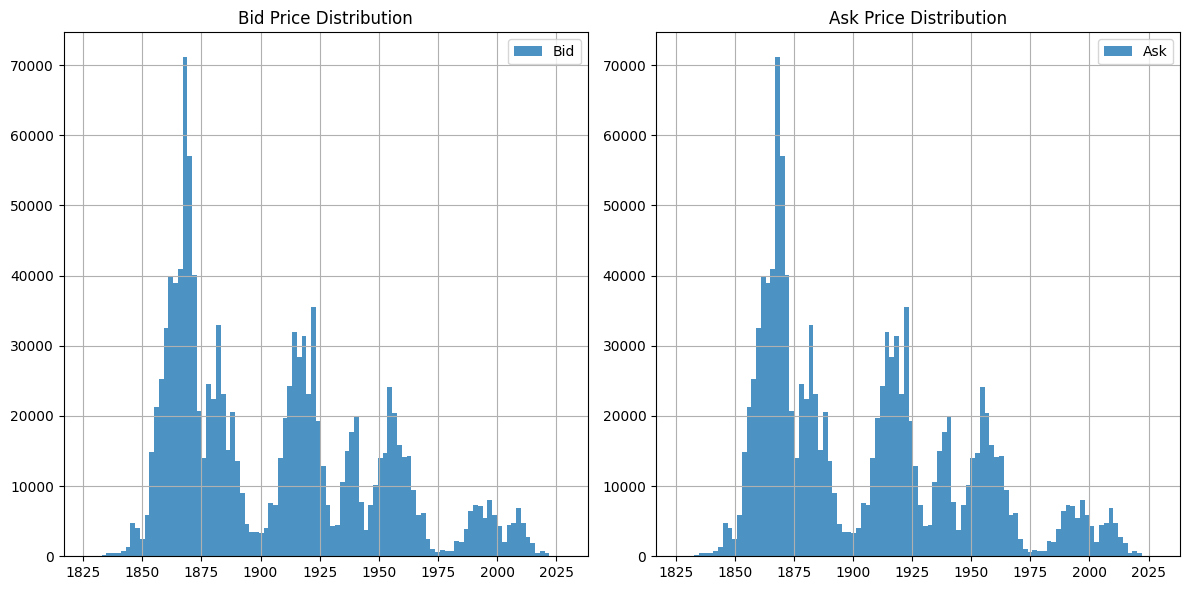

KS Statistic: 0.0009231120456196229, P-value: 0.6812398553507952


In [12]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

market_data['bid_prc'].hist(bins=100, alpha=0.8, ax=axes[0], label='Bid')
axes[0].set_title('Bid Price Distribution')
axes[0].legend()

market_data['ask_prc'].hist(bins=100, alpha=0.8, ax=axes[1], label='Ask')
axes[1].set_title('Ask Price Distribution')
axes[1].legend()

plt.tight_layout()
plt.show()

# using the Kolmogorov-Smirnov test sichecking the cumulative distribution of `bid_prc` and `ask_prc` to see if they are from the same distribution
ks_stat, ks_p_value = stats.ks_2samp(market_data['bid_prc'], market_data['ask_prc'])

print(f"KS Statistic: {ks_stat}, P-value: {ks_p_value}")


In [13]:
# Tests for normal distribution since entires > 5000
stat, p = normaltest(market_data['bid_prc'])
print('D’Agostino’s K^2 Test for bid_prc:')
print('Statistics=%.3f, p=%.3f' % (stat, p))

stat, p = normaltest(market_data['ask_prc'])
print('\nD’Agostino’s K^2 Test for ask_prc:')
print('Statistics=%.3f, p=%.3f' % (stat, p))


D’Agostino’s K^2 Test for bid_prc:
Statistics=98023.187, p=0.000

D’Agostino’s K^2 Test for ask_prc:
Statistics=98023.606, p=0.000


By plotting the distribution and using the Kolmogorov-Smirnov test, we confirm that `bid_price` and `ask_price` share the same distribution. Moreover, the distribution is not normal. This is expected, as there can be a lot of fluctuations in the market. This tells me that I should investigate by market volatility and periods of market stress later on.

Moving forward, I will merge the `fills_data` and `market_data` datasets on the `timestamp` index. This will simplify my analysis later on.

In [14]:
# create copies so we do not modify the original data
fills_data_copy = fills_data.copy() 
market_data_copy = market_data.copy()

fills_data_copy.index = fills_data_copy.index.tz_localize(None)
market_data_copy.index = market_data_copy.index.tz_localize(None)

merged_data = pd.merge_asof(fills_data_copy.sort_index(), market_data_copy.sort_index(), left_index=True, right_index=True, direction='nearest')

assert merged_data.shape[0] == fills_data.shape[0] # assert same rows
assert merged_data.shape[1] == fills_data.shape[1] + market_data.shape[1] # assert same columns

merged_data


order_id side  fill_prc  fill_qty  \
timestamp                                                              
2023-07-01 00:46:05.617580  670003026938216    S   1937.83    0.0690   
2023-07-01 06:52:59.387733  670003026940777    B   1920.53    0.0264   
2023-07-01 09:19:52.809436  670003026941465    B   1914.23    0.0707   
2023-07-01 10:16:21.048157  670003026941676    B   1916.97    0.1719   
2023-07-01 14:37:25.452850  670003026943147    S   1921.43    0.1719   
...                                     ...  ...       ...       ...   
2023-07-15 16:18:25.726018  670008617129681    B   1935.21    0.1719   
2023-07-15 16:19:06.461829  670008617129719    B   1936.04    0.1719   
2023-07-15 18:39:02.613882  670008617130081    S   1939.44    0.0670   
2023-07-15 18:39:02.614281  670008617130071    S   1939.87    0.0674   
2023-07-15 19:04:52.935896  670008617130139    B   1935.97    0.0666   

                           liquidity       fee fee_ccy  fee_ccy_usd_rate  \
timestamp                                                                  
2023-07-01 00:46:05.617580     Maker  0.000000     bnb        237.395823   
2023-07-01 06:52:59.387733     Maker  0.000000     bnb        237.395823   
2023-07-01 09:19:52.809436     Maker  0.000000     bnb        237.395823   
2023-07-01 10:16:21.048157     Taker  0.000305     bnb        237.395823   
2023-07-01 14:37:25.452850     Maker  0.000000     bnb        237.395823   
...                              ...       ...     ...               ...   
2023-07-15 16:18:25.726018     Taker  0.000299     bnb        259.829225   
2023-07-15 16:19:06.461829     Taker  0.000299     bnb        259.829225   
2023-07-15 18:39:02.613882     Maker  0.000000     bnb        259.829225   
2023-07-15 18:39:02.614281     Maker  0.000000     bnb        259.829225   
2023-07-15 19:04:52.935896     Maker  0.000000     bnb        259.829225   

                                        fill_id  symbol_x     exch  balance  \
timestamp                                                                     
2023-07-01 00:46:05.617580  1688172365615000000  eth_usdc  binance   0.3755   
2023-07-01 06:52:59.387733  1688194379383000000  eth_usdc  binance   0.4019   
2023-07-01 09:19:52.809436  1688203192806000000  eth_usdc  binance   0.4726   
2023-07-01 10:16:21.048157  1688206581043000000  eth_usdc  binance   0.6445   
2023-07-01 14:37:25.452850  1688222245450000000  eth_usdc  binance   0.4726   
...                                         ...       ...      ...      ...   
2023-07-15 16:18:25.726018  1689437905700000000  eth_usdc  binance   0.4808   
2023-07-15 16:19:06.461829  1689437946423000000  eth_usdc  binance   0.6527   
2023-07-15 18:39:02.613882  1689446342610000000  eth_usdc  binance   0.5857   
2023-07-15 18:39:02.614281  1689446342610000001  eth_usdc  binance   0.5183   
2023-07-15 19:04:52.935896  1689447892932000000  eth_usdc  binance   0.5849   

                            bid_prc  ask_prc          symbol_y  
timestamp                                                       
2023-07-01 00:46:05.617580  1937.94  1937.95  binance_eth_usdt  
2023-07-01 06:52:59.387733  1921.73  1921.74  binance_eth_usdt  
2023-07-01 09:19:52.809436  1915.36  1915.37  binance_eth_usdt  
2023-07-01 10:16:21.048157  1917.32  1917.33  binance_eth_usdt  
2023-07-01 14:37:25.452850  1921.86  1921.87  binance_eth_usdt  
...                             ...      ...               ...  
2023-07-15 16:18:25.726018  1932.34  1932.35  binance_eth_usdt  
2023-07-15 16:19:06.461829  1932.34  1932.35  binance_eth_usdt  
2023-07-15 18:39:02.613882  1932.34  1932.35  binance_eth_usdt  
2023-07-15 18:39:02.614281  1932.34  1932.35  binance_eth_usdt  
2023-07-15 19:04:52.935896  1932.34  1932.35  binance_eth_usdt  

[1123 rows x 15 columns]

## Investigating the PnL: Calculating the PnL, bucketing the PnL, and using multi-linear regression on PnL to rank the factors significant to the PnL

In this section, I will
1. Calculate the PnL and justify my choice of PnL calculation.
2. Segment the PnL into different buckets to better understand the performance of the strategy under different conditions.
3. Construct a multi-linear regression model to rank the features that are statistically significant to the PnL.

In [15]:
# Function to calculate the pnl of a trade given a row in the fills data
# We work with the assumption that `fill_prc` is in USD. 
def calculate_trade_pnl(row) -> float:
    fee_in_usd = row['fee'] * row['fee_ccy_usd_rate']
    fill_value_usd = row['fill_prc'] * row['fill_qty']
    if row['side'] == 'B':
        pnl = -fill_value_usd - fee_in_usd # buy is an expenditure
    elif row['side'] == 'S': 
        pnl = fill_value_usd - fee_in_usd # sell is an income
    return pnl

merged_data['trade_pnl'] = merged_data.apply(calculate_trade_pnl, axis=1)
merged_data.describe()

order_id     fill_prc     fill_qty          fee  fee_ccy_usd_rate  \
count  1.123000e+03  1123.000000  1123.000000  1123.000000       1123.000000   
mean   6.700046e+14  1934.634034     0.070110     0.000020        242.613197   
std    2.450876e+09    48.484356     0.033944     0.000073          4.742499   
min    6.700020e+14  1827.960000     0.000100     0.000000        235.954209   
25%    6.700034e+14  1895.555000     0.066300     0.000000        241.419819   
50%    6.700034e+14  1933.270000     0.068300     0.000000        241.419819   
75%    6.700040e+14  1974.705000     0.070200     0.000000        243.423520   
max    6.700096e+14  2029.450000     0.171900     0.000310        259.829225   

            fill_id      balance      bid_prc      ask_prc    trade_pnl  
count  1.123000e+03  1123.000000  1123.000000  1123.000000  1123.000000  
mean   1.688934e+18     0.537670  1934.183001  1934.244078    -0.229504  
std    3.829630e+14     0.181855    48.309006    48.299740   150.536345  
min    1.688172e+18     0.080200  1827.500000  1827.510000  -348.172338  
25%    1.688554e+18     0.400750  1895.155000  1895.190000  -132.044110  
50%    1.689163e+18     0.545900  1932.340000  1932.350000   -14.639200  
75%    1.689270e+18     0.679150  1974.270000  1974.280000   131.984646  
max    1.689448e+18     0.962300  2027.970000  2027.980000   348.024299

In [16]:
total_trade_pnl = merged_data['trade_pnl'].sum()
print(f"The total pnl from trading for the strategy is {total_trade_pnl:.2f} USD")

# Sanity check our trade pnl calculation
sells = merged_data[merged_data['side'] == 'S']
buys = merged_data[merged_data['side'] == 'B']

total_sell_value = (sells['trade_pnl']).sum()
total_buy_value = (buys['trade_pnl']).sum()

average_sell_value = total_sell_value / sells.shape[0]
average_buy_value = total_buy_value / buys.shape[0]

total_sell_count = sells.shape[0]
total_buy_count = buys.shape[0]
total_trade_count = total_sell_count + total_buy_count
average_pnl = total_trade_pnl / merged_data.shape[0]

print(f"""
The total sell value is {total_sell_value:.2f} USD
The total buy value is {total_buy_value:.2f} USD
The total sell count is {total_sell_count}
The total buy count is {total_buy_count}
The total trade count is {total_trade_count}
The average sell value is {average_sell_value:.2f} USD
The average buy value is {average_buy_value:.2f} USD
The average pnl value is {average_pnl:.2f} USD
""")

# Verifying by inspecting the mean buy and sell value and number of buy and sell trades, the pnl number seems to check out.

The total pnl from trading for the strategy is -257.73 USD

The total sell value is 75989.35 USD
The total buy value is -76247.09 USD
The total sell count is 543
The total buy count is 580
The total trade count is 1123
The average sell value is 139.94 USD
The average buy value is -131.46 USD
The average pnl value is -0.23 USD



<Axes: title={'center': 'Cumulative Trade PnL Over Time'}, xlabel='Time', ylabel='Cumulative Trade PnL'>

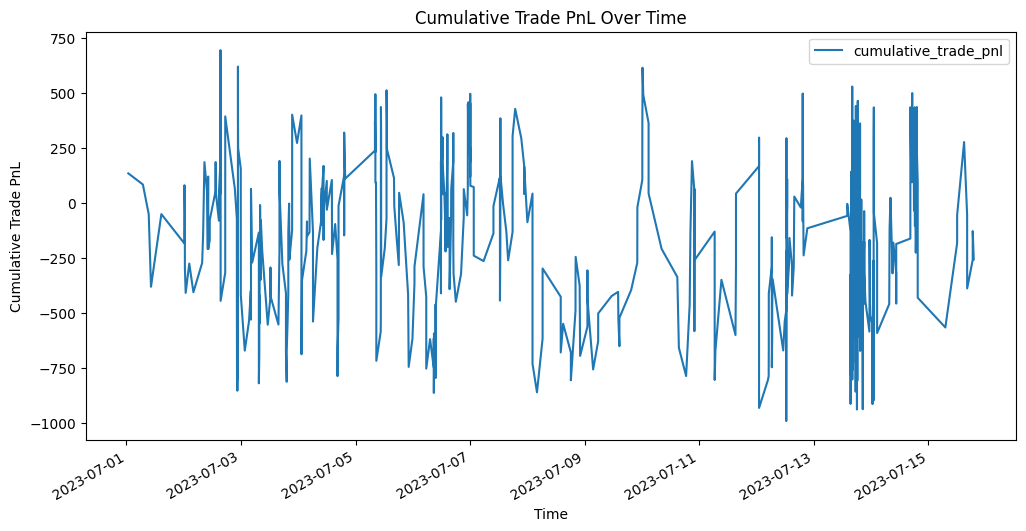

In [17]:
# We might also be interested in the cumulative pnl of the stratefy to see if there are any patterns over time
merged_data['cumulative_trade_pnl'] = merged_data['trade_pnl'].cumsum()
merged_data['cumulative_trade_pnl'].plot(figsize=(12, 6), title='Cumulative Trade PnL Over Time', xlabel='Time', ylabel='Cumulative Trade PnL', legend=True)

Observing this graph, there is a lot of fluctuation in the cummulative PnL of the strategy. Furthermore, we can see that the cumulative PnL at the end of the data is less than when we started and negative. Initially, I thought this was concerning. However, I later realised that the strategy also ended with a higher balance than it started with. With that, I will investigate the net worth of the strategy by marking to market the assets we have.

order_id side  fill_prc  fill_qty  \
timestamp                                                              
2023-07-01 00:46:05.617580  670003026938216    S   1937.83    0.0690   
2023-07-01 06:52:59.387733  670003026940777    B   1920.53    0.0264   
2023-07-01 09:19:52.809436  670003026941465    B   1914.23    0.0707   
2023-07-01 10:16:21.048157  670003026941676    B   1916.97    0.1719   
2023-07-01 14:37:25.452850  670003026943147    S   1921.43    0.1719   
...                                     ...  ...       ...       ...   
2023-07-15 16:18:25.726018  670008617129681    B   1935.21    0.1719   
2023-07-15 16:19:06.461829  670008617129719    B   1936.04    0.1719   
2023-07-15 18:39:02.613882  670008617130081    S   1939.44    0.0670   
2023-07-15 18:39:02.614281  670008617130071    S   1939.87    0.0674   
2023-07-15 19:04:52.935896  670008617130139    B   1935.97    0.0666   

                           liquidity       fee fee_ccy  fee_ccy_usd_rate  \
timestamp                                                                  
2023-07-01 00:46:05.617580     Maker  0.000000     bnb        237.395823   
2023-07-01 06:52:59.387733     Maker  0.000000     bnb        237.395823   
2023-07-01 09:19:52.809436     Maker  0.000000     bnb        237.395823   
2023-07-01 10:16:21.048157     Taker  0.000305     bnb        237.395823   
2023-07-01 14:37:25.452850     Maker  0.000000     bnb        237.395823   
...                              ...       ...     ...               ...   
2023-07-15 16:18:25.726018     Taker  0.000299     bnb        259.829225   
2023-07-15 16:19:06.461829     Taker  0.000299     bnb        259.829225   
2023-07-15 18:39:02.613882     Maker  0.000000     bnb        259.829225   
2023-07-15 18:39:02.614281     Maker  0.000000     bnb        259.829225   
2023-07-15 19:04:52.935896     Maker  0.000000     bnb        259.829225   

                                        fill_id  symbol_x     exch  balance  \
timestamp                                                                     
2023-07-01 00:46:05.617580  1688172365615000000  eth_usdc  binance   0.3755   
2023-07-01 06:52:59.387733  1688194379383000000  eth_usdc  binance   0.4019   
2023-07-01 09:19:52.809436  1688203192806000000  eth_usdc  binance   0.4726   
2023-07-01 10:16:21.048157  1688206581043000000  eth_usdc  binance   0.6445   
2023-07-01 14:37:25.452850  1688222245450000000  eth_usdc  binance   0.4726   
...                                         ...       ...      ...      ...   
2023-07-15 16:18:25.726018  1689437905700000000  eth_usdc  binance   0.4808   
2023-07-15 16:19:06.461829  1689437946423000000  eth_usdc  binance   0.6527   
2023-07-15 18:39:02.613882  1689446342610000000  eth_usdc  binance   0.5857   
2023-07-15 18:39:02.614281  1689446342610000001  eth_usdc  binance   0.5183   
2023-07-15 19:04:52.935896  1689447892932000000  eth_usdc  binance   0.5849   

                            bid_prc  ask_prc          symbol_y   trade_pnl  \
timestamp                                                                    
2023-07-01 00:46:05.617580  1937.94  1937.95  binance_eth_usdt  133.710270   
2023-07-01 06:52:59.387733  1921.73  1921.74  binance_eth_usdt  -50.701992   
2023-07-01 09:19:52.809436  1915.36  1915.37  binance_eth_usdt -135.336061   
2023-07-01 10:16:21.048157  1917.32  1917.33  binance_eth_usdt -329.599496   
2023-07-01 14:37:25.452850  1921.86  1921.87  binance_eth_usdt  330.293817   
...                             ...      ...               ...         ...   
2023-07-15 16:18:25.726018  1932.34  1932.35  binance_eth_usdt -332.740259   
2023-07-15 16:19:06.461829  1932.34  1932.35  binance_eth_usdt -332.882936   
2023-07-15 18:39:02.613882  1932.34  1932.35  binance_eth_usdt  129.942480   
2023-07-15 18:39:02.614281  1932.34  1932.35  binance_eth_usdt  130.747238   
2023-07-15 19:04:52.935896  1932.34  1932.35  binance_eth_usdt -128.935602   

                            cumulative_trade_pnl  balance_value  \

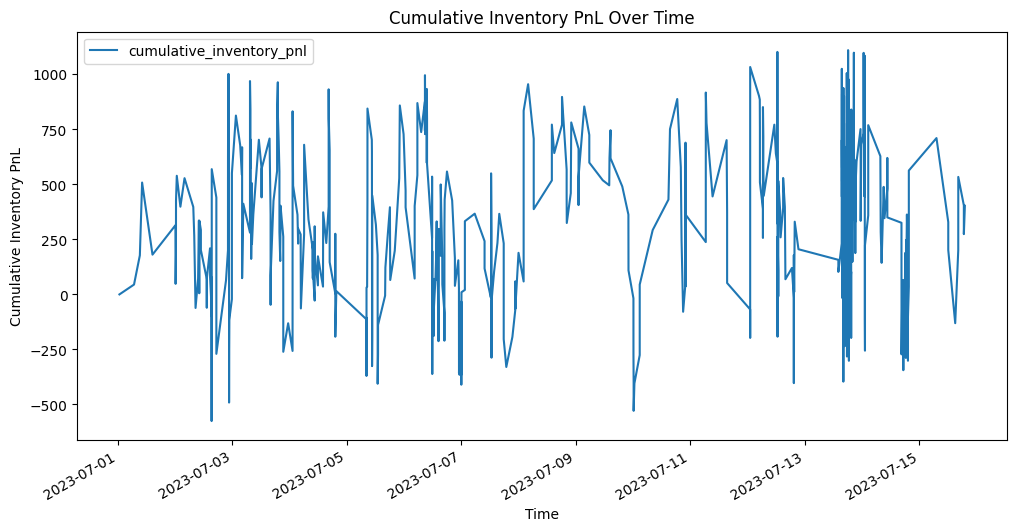

In [18]:
# I argue that we should use the bid price to calculate the market value of the balance because it represents the highest price a buyer is willing to pay for the asset.
# In constract, if we were to use the ask price,the lowest price a seller is willing to accept for the asset, there is no guarantee that the asset will be sold at that price.
# Furthermore, if we were to use `qty_prc`, we would be using the price at which the asset was bought or sold, which may not be representative of the current market sentiment.
# Ideally we would have access to closing price data, but since that is not available, I will use the bid price as what I believe is the next best alternative.
merged_data['balance_value'] = merged_data['bid_prc'] * merged_data['balance']
merged_data['inventory_pnl'] = merged_data['balance_value'].diff()
## Assume that the first row is the first day of trading and so did not own any inventory to make a profit or loss from previous days
merged_data.loc[merged_data.index[0], 'inventory_pnl'] = 0
merged_data['cumulative_inventory_pnl'] = merged_data['inventory_pnl'].cumsum()
merged_data['cumulative_inventory_pnl'].plot(figsize=(12, 6), title='Cumulative Inventory PnL Over Time', xlabel='Time', ylabel='Cumulative Inventory PnL', legend=True)
merged_data

At the end of the data, the cumulative inventory PnL is positive. This is a good sign, as it means that the strategy has made a profit from the inventory it has. With this feature, I can calculate the net PnL of the strategy by adding the PnL from trade and inventory PnL.

In [19]:
total_inventory_pnl = merged_data['inventory_pnl'].sum()
net_pnl = total_trade_pnl + total_inventory_pnl
print(f"The net pnl for the strategy is {net_pnl:.2f} USD")
# With this, we can also create a new feature that represents the total pnl of the strategy at any given time
merged_data['net_pnl'] = merged_data['trade_pnl'] + merged_data['inventory_pnl']
merged_data['cumulative_net_pnl'] = merged_data['cumulative_inventory_pnl'] + merged_data['cumulative_trade_pnl']

# some tests
assert round(merged_data['cumulative_net_pnl'].iloc[-1], 2) == round(net_pnl, 2) 
assert round(merged_data['net_pnl'].sum(), 2) == round(merged_data['cumulative_net_pnl'].iloc[-1], 2)

merged_data

The net pnl for the strategy is 144.80 USD


order_id side  fill_prc  fill_qty  \
timestamp                                                              
2023-07-01 00:46:05.617580  670003026938216    S   1937.83    0.0690   
2023-07-01 06:52:59.387733  670003026940777    B   1920.53    0.0264   
2023-07-01 09:19:52.809436  670003026941465    B   1914.23    0.0707   
2023-07-01 10:16:21.048157  670003026941676    B   1916.97    0.1719   
2023-07-01 14:37:25.452850  670003026943147    S   1921.43    0.1719   
...                                     ...  ...       ...       ...   
2023-07-15 16:18:25.726018  670008617129681    B   1935.21    0.1719   
2023-07-15 16:19:06.461829  670008617129719    B   1936.04    0.1719   
2023-07-15 18:39:02.613882  670008617130081    S   1939.44    0.0670   
2023-07-15 18:39:02.614281  670008617130071    S   1939.87    0.0674   
2023-07-15 19:04:52.935896  670008617130139    B   1935.97    0.0666   

                           liquidity       fee fee_ccy  fee_ccy_usd_rate  \
timestamp                                                                  
2023-07-01 00:46:05.617580     Maker  0.000000     bnb        237.395823   
2023-07-01 06:52:59.387733     Maker  0.000000     bnb        237.395823   
2023-07-01 09:19:52.809436     Maker  0.000000     bnb        237.395823   
2023-07-01 10:16:21.048157     Taker  0.000305     bnb        237.395823   
2023-07-01 14:37:25.452850     Maker  0.000000     bnb        237.395823   
...                              ...       ...     ...               ...   
2023-07-15 16:18:25.726018     Taker  0.000299     bnb        259.829225   
2023-07-15 16:19:06.461829     Taker  0.000299     bnb        259.829225   
2023-07-15 18:39:02.613882     Maker  0.000000     bnb        259.829225   
2023-07-15 18:39:02.614281     Maker  0.000000     bnb        259.829225   
2023-07-15 19:04:52.935896     Maker  0.000000     bnb        259.829225   

                                        fill_id  symbol_x  ...  bid_prc  \
timestamp                                                  ...            
2023-07-01 00:46:05.617580  1688172365615000000  eth_usdc  ...  1937.94   
2023-07-01 06:52:59.387733  1688194379383000000  eth_usdc  ...  1921.73   
2023-07-01 09:19:52.809436  1688203192806000000  eth_usdc  ...  1915.36   
2023-07-01 10:16:21.048157  1688206581043000000  eth_usdc  ...  1917.32   
2023-07-01 14:37:25.452850  1688222245450000000  eth_usdc  ...  1921.86   
...                                         ...       ...  ...      ...   
2023-07-15 16:18:25.726018  1689437905700000000  eth_usdc  ...  1932.34   
2023-07-15 16:19:06.461829  1689437946423000000  eth_usdc  ...  1932.34   
2023-07-15 18:39:02.613882  1689446342610000000  eth_usdc  ...  1932.34   
2023-07-15 18:39:02.614281  1689446342610000001  eth_usdc  ...  1932.34   
2023-07-15 19:04:52.935896  1689447892932000000  eth_usdc  ...  1932.34   

                            ask_prc          symbol_y   trade_pnl  \
timestamp                                                           
2023-07-01 00:46:05.617580  1937.95  binance_eth_usdt  133.710270   
2023-07-01 06:52:59.387733  1921.74  binance_eth_usdt  -50.701992   
2023-07-01 09:19:52.809436  1915.37  binance_eth_usdt -135.336061   
2023-07-01 10:16:21.048157  1917.33  binance_eth_usdt -329.599496   
2023-07-01 14:37:25.452850  1921.87  binance_eth_usdt  330.293817   
...                             ...               ...         ...   
2023-07-15 16:18:25.726018  1932.35  binance_eth_usdt -332.740259   
2023-07-15 16:19:06.461829  1932.35  binance_eth_usdt -332.882936   
2023-07-15 18:39:02.613882  1932.35  binance_eth_usdt  129.942480   
2023-07-15 18:39:02.614281  1932.35  binance_eth_usdt  130.747238   
2023-07-15 19:04:52.935896  1932.35  binance_eth_usdt -128.935602   

                           cumulative_trade_pnl  balance_value  inventory_pnl  \
timestamp                                                                       
2023-07-01 00:46:05.617580           133.710270     727.696470       0.00

I believe the net PnL is a more accurate representation of the PnL of the strategy. This is because the net PnL takes into account the two streams of income of the strategy, realised gains from trade PnL and unrealised gains from inventory PnL. 

The calculated net PnL of the strategy is `144.80` USD. This is a good sign as it means that the strategy is profitable. However, I want to investigate what factors influence the PnL of the strategy. This will give me further insight into the behaviour of the strategy and the ideas behind it.

Before we continue, let me run some tests first to ensure that my calculation for the PnL is correct by asserting that it satisfies some relationships in the data that I believe make sense.

In [20]:
# Assert that the present balance value is the same as the previous balance value plus the inventory pnl
net_balance_value = merged_data['balance_value'].iloc[-1] - merged_data['balance_value'].iloc[0]
for i in range(1, len(merged_data)):
    expected_balance_value = merged_data['balance_value'].iloc[i-1] + merged_data['inventory_pnl'].iloc[i]
    expected_balance_value_rounded = round(expected_balance_value, 2)
    actual_balance_value_rounded = round(merged_data['balance_value'].iloc[i], 2)
    assert expected_balance_value_rounded == actual_balance_value_rounded, f"Mismatch at index {i}"

assert round(merged_data['cumulative_inventory_pnl'].iloc[-1], 2) == round(net_balance_value, 2), "Net PnL does not match net balance value."

In [21]:
# Assert cumulative pnl calculation is the same as cumulative sum of net pnl at any given time
calculated_cumulative_net_pnl = merged_data['net_pnl'].cumsum().round(2)
cumulative_net_pnl = merged_data['cumulative_net_pnl'].round(2)

assert (calculated_cumulative_net_pnl == cumulative_net_pnl).all(), "Mismatch in cumulative net pnl"

In [22]:
# The last assertion we can check is that the difference between the present balance value and the initial balance value plus the cumulative trade pnl is the same as the cumulative net pnl
# This is because the change in balance value already "captures" our inventory pnl as balance value is a measure of our net worth at the time
original_balance_value = merged_data['balance_value'].iloc[0]
balance_value_change = merged_data['balance_value'] - original_balance_value
assert all(round(balance_value_change + merged_data['cumulative_trade_pnl'], 2) == round(merged_data['cumulative_net_pnl'], 2)), "Assertion failed: The calculated PnL does not match the cumulative net PnL."

The trading session ends with a higher net worth than it started with. Again, this is a good sign since it indicates that the strategy is profitable. While our PnL from trading is negative, we still have unrealized gains from holding more inventory whose value outweighs the PnL from trading.

Let us calculate some statistics that may be of interest, like drawfown, maximum drawdown, and more.

Metrics for trade_pnl:
Maximum Drawdown: -1686.76
Volatility of Returns: 150.54
Win Rate: 48.35%
Loss Rate: 51.65%
Profit Factor: 1.00
Expectancy: -0.23
Recovery Factor: -0.15
Skewness: 0.05
Kurtosis: -0.75


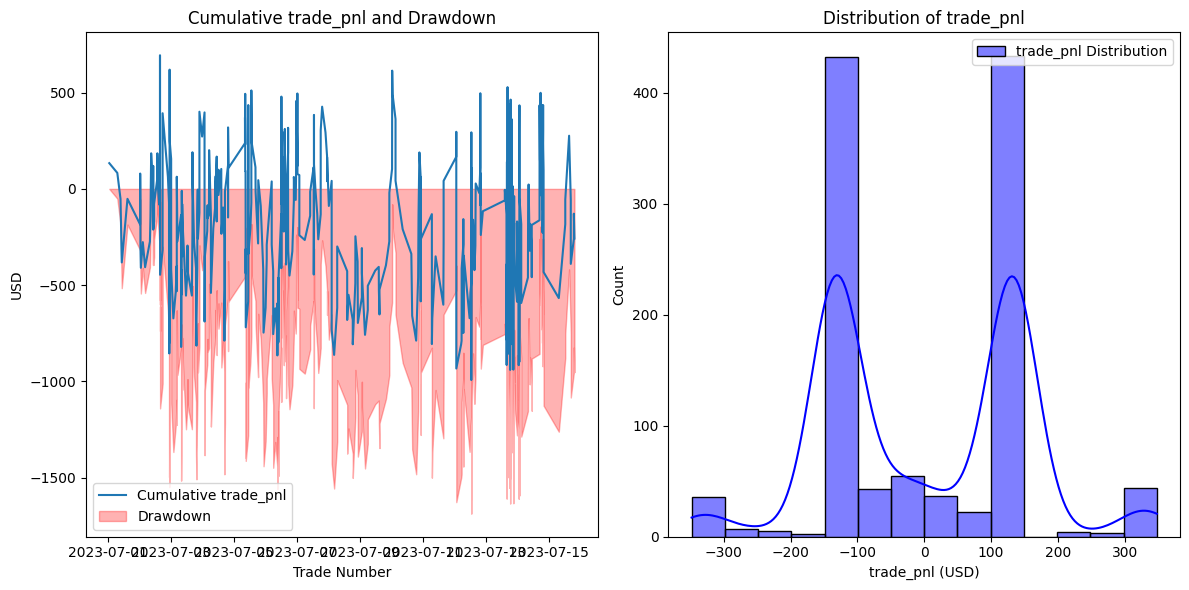

In [139]:
merged_data['max_cumulative_trade_pnl'] = merged_data['trade_pnl'].cumsum().cummax()
merged_data['drawdown_trade_pnl'] = merged_data['trade_pnl'].cumsum() - merged_data['max_cumulative_trade_pnl']

max_drawdown_trade_pnl = merged_data['drawdown_trade_pnl'].min()
volatility_trade_pnl = merged_data['trade_pnl'].std()
win_rate_trade_pnl = len(merged_data[merged_data['trade_pnl'] > 0]) / len(merged_data)
loss_rate_trade_pnl = len(merged_data[merged_data['trade_pnl'] < 0]) / len(merged_data)
gross_profits_trade_pnl = merged_data[merged_data['trade_pnl'] > 0]['trade_pnl'].sum()
gross_losses_trade_pnl = abs(merged_data[merged_data['trade_pnl'] < 0]['trade_pnl'].sum())
profit_factor_trade_pnl = gross_profits_trade_pnl / gross_losses_trade_pnl if gross_losses_trade_pnl != 0 else np.nan
average_win_trade_pnl = merged_data[merged_data['trade_pnl'] > 0]['trade_pnl'].mean()
average_loss_trade_pnl = merged_data[merged_data['trade_pnl'] < 0]['trade_pnl'].mean()
expectancy_trade_pnl = (win_rate_trade_pnl * average_win_trade_pnl) + (loss_rate_trade_pnl * average_loss_trade_pnl)
net_profit_trade_pnl = merged_data['trade_pnl'].sum()
recovery_factor_trade_pnl = net_profit_trade_pnl / abs(max_drawdown_trade_pnl) if max_drawdown_trade_pnl != 0 else np.nan
skewness_trade_pnl = merged_data['trade_pnl'].skew()
kurtosis_trade_pnl = merged_data['trade_pnl'].kurtosis()

print(f"Metrics for trade_pnl:")
print(f"Maximum Drawdown: {max_drawdown_trade_pnl:.2f}")
print(f"Volatility of Returns: {volatility_trade_pnl:.2f}")
print(f"Win Rate: {win_rate_trade_pnl:.2%}")
print(f"Loss Rate: {loss_rate_trade_pnl:.2%}")
print(f"Profit Factor: {profit_factor_trade_pnl:.2f}")
print(f"Expectancy: {expectancy_trade_pnl:.2f}")
print(f"Recovery Factor: {recovery_factor_trade_pnl:.2f}")
print(f"Skewness: {skewness_trade_pnl:.2f}")
print(f"Kurtosis: {kurtosis_trade_pnl:.2f}")

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].plot(merged_data['trade_pnl'].cumsum(), label='Cumulative trade_pnl')
axs[0].fill_between(merged_data.index, merged_data['drawdown_trade_pnl'], alpha=0.3, color='red', label='Drawdown')
axs[0].set_title('Cumulative trade_pnl and Drawdown')
axs[0].set_xlabel('Trade Number')
axs[0].set_ylabel('USD')
axs[0].legend()

sns.histplot(merged_data['trade_pnl'], kde=True, ax=axs[1], color='blue', label='trade_pnl Distribution')
axs[1].set_title('Distribution of trade_pnl')
axs[1].set_xlabel('trade_pnl (USD)')
axs[1].legend()

fig.tight_layout()
plt.show()


In `trade_pnl`, we can observe that the maximum drawdown is quite significant at -1686.76 USD, suggesting a potential for large losses within the strategy. The high volatility of 150.54 indicates that the strategy's returns are quite erratic. The negative expectancy (-0.23) means the strategy is expected to lose money on average for each trade. The negative recovery factor (-0.15) indicates the strategy does not recover well from drawdowns, showing a lack of robustness. Near-zero skewness (0.05) suggests the returns are symmetrically distributed around the mean. Negative kurtosis (-0.75) indicates fewer outliers than a normal distribution, implying fewer extreme returns. Furthermore, the win and lose rate are slightly bent towards the lose rate, and with the Profit Factor at 1.00, the trading strategy is almost certain to produce a losing trade as it is a winning trade. Looking at the drawdown plot shows a series of peaks and valleys, with the red area indicating periods where the strategy is off its peak performance. The repeated dips into the red zone indicate frequent and substantial drawdown periods, reflecting a strategy that might be quite risky.

Metrics for inventory_pnl:
Maximum Drawdown: -1530.37
Volatility of Returns: 150.86
Win Rate: 51.65%
Loss Rate: 48.26%
Profit Factor: 1.01
Expectancy: 0.36
Recovery Factor: 0.26
Skewness: -0.06
Kurtosis: -0.75


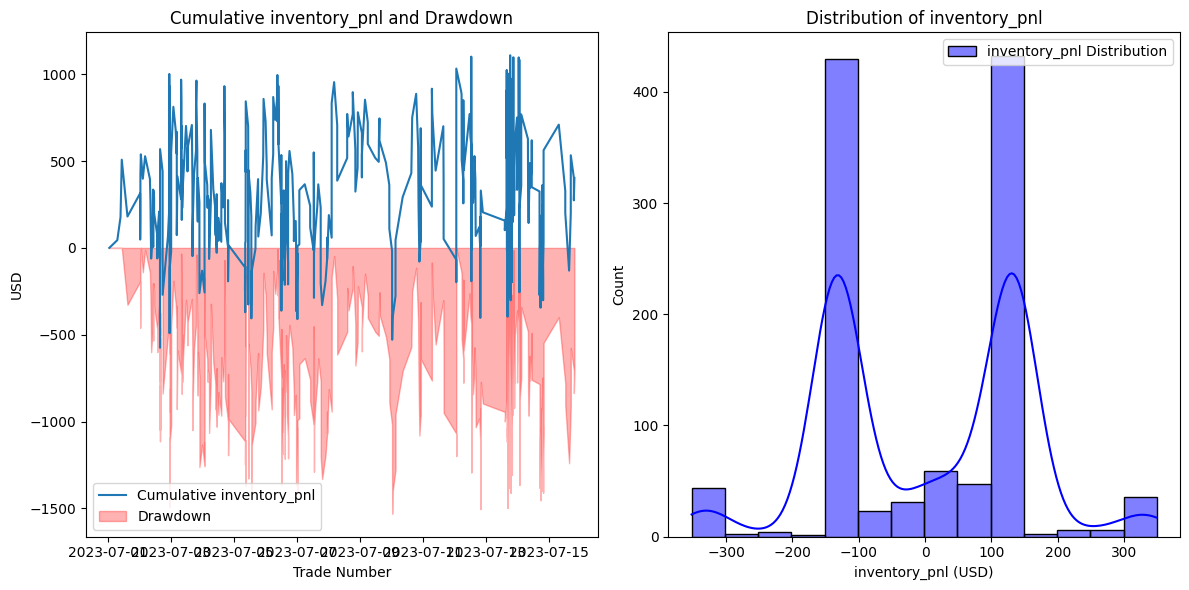

In [137]:

merged_data['max_cumulative_inventory_pnl'] = merged_data['inventory_pnl'].cumsum().cummax()
merged_data['drawdown_inventory_pnl'] = merged_data['inventory_pnl'].cumsum() - merged_data['max_cumulative_inventory_pnl']

max_drawdown_inventory_pnl = merged_data['drawdown_inventory_pnl'].min()
volatility_inventory_pnl = merged_data['inventory_pnl'].std()
win_rate_inventory_pnl = len(merged_data[merged_data['inventory_pnl'] > 0]) / len(merged_data)
loss_rate_inventory_pnl = len(merged_data[merged_data['inventory_pnl'] < 0]) / len(merged_data)
gross_profits_inventory_pnl = merged_data[merged_data['inventory_pnl'] > 0]['inventory_pnl'].sum()
gross_losses_inventory_pnl = abs(merged_data[merged_data['inventory_pnl'] < 0]['inventory_pnl'].sum())
profit_factor_inventory_pnl = gross_profits_inventory_pnl / gross_losses_inventory_pnl if gross_losses_inventory_pnl != 0 else np.nan
average_win_inventory_pnl = merged_data[merged_data['inventory_pnl'] > 0]['inventory_pnl'].mean()
average_loss_inventory_pnl = merged_data[merged_data['inventory_pnl'] < 0]['inventory_pnl'].mean()
expectancy_inventory_pnl = (win_rate_inventory_pnl * average_win_inventory_pnl) + (loss_rate_inventory_pnl * average_loss_inventory_pnl)
net_profit_inventory_pnl = merged_data['inventory_pnl'].sum()
recovery_factor_inventory_pnl = net_profit_inventory_pnl / abs(max_drawdown_inventory_pnl) if max_drawdown_inventory_pnl != 0 else np.nan
skewness_inventory_pnl = merged_data['inventory_pnl'].skew()
kurtosis_inventory_pnl = merged_data['inventory_pnl'].kurtosis()

print(f"Metrics for inventory_pnl:")
print(f"Maximum Drawdown: {max_drawdown_inventory_pnl:.2f}")
print(f"Volatility of Returns: {volatility_inventory_pnl:.2f}")
print(f"Win Rate: {win_rate_inventory_pnl:.2%}")
print(f"Loss Rate: {loss_rate_inventory_pnl:.2%}")
print(f"Profit Factor: {profit_factor_inventory_pnl:.2f}")
print(f"Expectancy: {expectancy_inventory_pnl:.2f}")
print(f"Recovery Factor: {recovery_factor_inventory_pnl:.2f}")
print(f"Skewness: {skewness_inventory_pnl:.2f}")
print(f"Kurtosis: {kurtosis_inventory_pnl:.2f}")

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].plot(merged_data['inventory_pnl'].cumsum(), label='Cumulative inventory_pnl')
axs[0].fill_between(merged_data.index, merged_data['drawdown_inventory_pnl'], alpha=0.3, color='red', label='Drawdown')
axs[0].set_title('Cumulative inventory_pnl and Drawdown')
axs[0].set_xlabel('Trade Number')
axs[0].set_ylabel('USD')
axs[0].legend()

sns.histplot(merged_data['inventory_pnl'], kde=True, ax=axs[1], color='blue', label='inventory_pnl Distribution')
axs[1].set_title('Distribution of inventory_pnl')
axs[1].set_xlabel('inventory_pnl (USD)')
axs[1].legend()

fig.tight_layout()
plt.show()


For `inventory_pnl`, we can observe that the maximum drawdown is quite significant at -1530.37 USD, suggesting a potential for large losses within the strategy. The high volatility of 150.86 indicates that the strategy's returns are quite erratic. The positive expectancy (0.36) means the strategy is expected to make money on average for each trade. The positive recovery factor (0.26) indicates the strategy does recover well from drawdowns, showing a robustness. Near-zero skewness (-0.06) suggests the returns are symmetrically distributed around the mean. Negative kurtosis (-0.75) indicates fewer outliers than a normal distribution, implying fewer extreme returns. Furthermore, the win and lose rate are slightly bent towards the win rate, and with the Profit Factor at 1.01, the trading strategy is almost certain to produce a winning trade as it is a losing trade. Looking at the drawdown plot shows large drawdowns, indicating potential for significant declines in unrealized profit, which can be concerning for the overall strategy health.

Metrics for net_pnl:
Maximum Drawdown: -78.39
Volatility of Returns: 4.58
Win Rate: 54.50%
Loss Rate: 45.50%
Profit Factor: 1.22
Expectancy: 0.13
Recovery Factor: 1.85
Skewness: 22.31
Kurtosis: 648.92


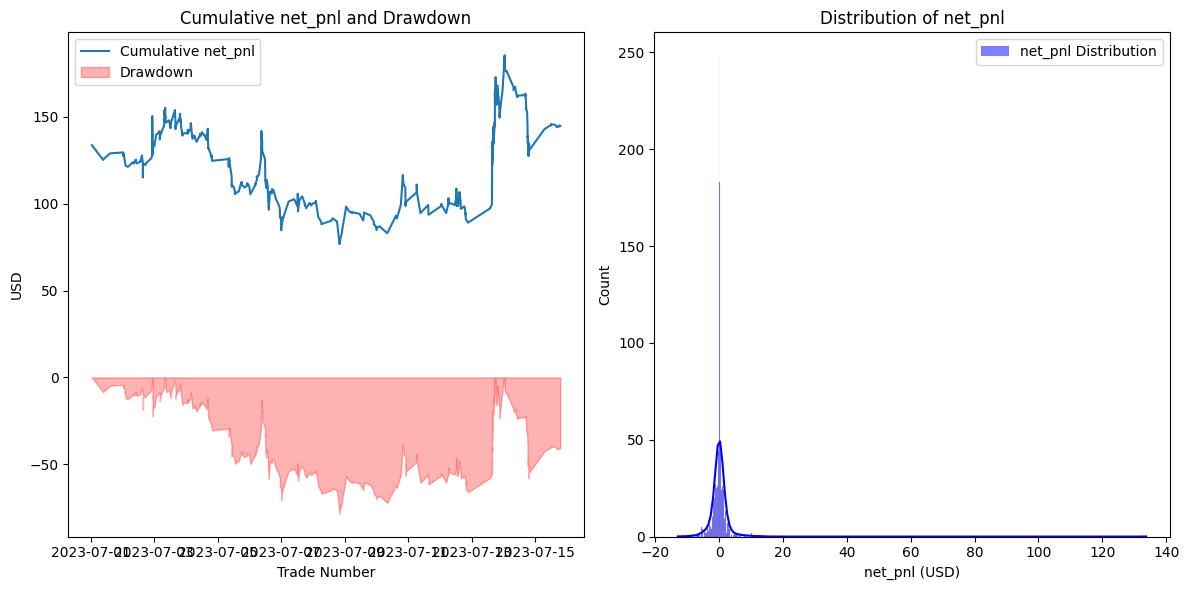

In [138]:
merged_data['max_cumulative_net_pnl'] = merged_data['net_pnl'].cumsum().cummax()
merged_data['drawdown_net_pnl'] = merged_data['net_pnl'].cumsum() - merged_data['max_cumulative_net_pnl']

max_drawdown_net_pnl = merged_data['drawdown_net_pnl'].min()
volatility_net_pnl = merged_data['net_pnl'].std()
win_rate_net_pnl = len(merged_data[merged_data['net_pnl'] > 0]) / len(merged_data)
loss_rate_net_pnl = len(merged_data[merged_data['net_pnl'] < 0]) / len(merged_data)
gross_profits_net_pnl = merged_data[merged_data['net_pnl'] > 0]['net_pnl'].sum()
gross_losses_net_pnl = abs(merged_data[merged_data['net_pnl'] < 0]['net_pnl'].sum())
profit_factor_net_pnl = gross_profits_net_pnl / gross_losses_net_pnl if gross_losses_net_pnl != 0 else np.nan
average_win_net_pnl = merged_data[merged_data['net_pnl'] > 0]['net_pnl'].mean()
average_loss_net_pnl = merged_data[merged_data['net_pnl'] < 0]['net_pnl'].mean()
expectancy_net_pnl = (win_rate_net_pnl * average_win_net_pnl) + (loss_rate_net_pnl * average_loss_net_pnl)
net_profit_net_pnl = merged_data['net_pnl'].sum()
recovery_factor_net_pnl = net_profit_net_pnl / abs(max_drawdown_net_pnl) if max_drawdown_net_pnl != 0 else np.nan
skewness_net_pnl = merged_data['net_pnl'].skew()
kurtosis_net_pnl = merged_data['net_pnl'].kurtosis()

print(f"Metrics for net_pnl:")
print(f"Maximum Drawdown: {max_drawdown_net_pnl:.2f}")
print(f"Volatility of Returns: {volatility_net_pnl:.2f}")
print(f"Win Rate: {win_rate_net_pnl:.2%}")
print(f"Loss Rate: {loss_rate_net_pnl:.2%}")
print(f"Profit Factor: {profit_factor_net_pnl:.2f}")
print(f"Expectancy: {expectancy_net_pnl:.2f}")
print(f"Recovery Factor: {recovery_factor_net_pnl:.2f}")
print(f"Skewness: {skewness_net_pnl:.2f}")
print(f"Kurtosis: {kurtosis_net_pnl:.2f}")

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].plot(merged_data['net_pnl'].cumsum(), label='Cumulative net_pnl')
axs[0].fill_between(merged_data.index, merged_data['drawdown_net_pnl'], alpha=0.3, color='red', label='Drawdown')
axs[0].set_title('Cumulative net_pnl and Drawdown')
axs[0].set_xlabel('Trade Number')
axs[0].set_ylabel('USD')
axs[0].legend()

sns.histplot(merged_data['net_pnl'], kde=True, ax=axs[1], color='blue', label='net_pnl Distribution')
axs[1].set_title('Distribution of net_pnl')
axs[1].set_xlabel('net_pnl (USD)')
axs[1].legend()

fig.tight_layout()
plt.show()


The `net_pnl` analysis shows that the maximum drawdown for net PnL is much lower (-78.39 USD), suggesting that when trade and inventory PnL are combined, the strategy is less risky. The low volatility (4.58) indicates that net PnL is much more stable than either trade or inventory PnL. A better win rate (54.50%) compared to loss rate (45.50%) for net PnL suggests that when combined, the wins slightly outweigh the losses. At 1.22, the Profit Factor suggests that net gains are 22% higher than losses, which is a good sign for the strategy. A positive expectancy (0.13) implies the strategy expects a small profit on average per trade. The recovery factor is quite high (1.85), suggesting the strategy recovers well from its drawdowns. Extremely high skewness (22.31) and kurtosis (648.92) indicate a highly abnormal distribution of returns, with a strong bias towards a few very high returns and the potential for extreme outcomes. The drawdown plot for net PnL shows that the overall strategy experiences less severe drawdowns compared to trading or inventory PnL alone, which might indicate that combining the two can lead to a more balanced and less volatile performance.

Overall, the trading strategy shows high volatility and potential for large drawdowns when looking at trade and inventory PnL separately. However, the combined net PnL presents a more stable and profitable outlook with a better recovery from losses. The extreme values of skewness and kurtosis for net PnL suggest that the strategy's performance is heavily influenced by a few trades that result in large gains, which could indicate an inconsistent performance or reliance on outlier events for profitability.

When looking at the drawdown plots, the trade PnL shows frequent and deep drawdowns, which points to higher risk and a lack of consistency. The inventory PnL is similar to trade PnL in terms of frequency and depth of drawdowns, indicating significant risks in the holding positions as well. The net PnL exhibits shallower and less frequent drawdowns, which suggests that when trade and inventory PnLs are combined, the strategy is better at mitigating losses and recovering.

In the PnL distribution histograms, trade and inventory PnL histograms show a more leptokurtic distribution, which means there are more frequent moderate outcomes and fewer extreme ones. The net PnL appears to be more normally distributed with fewer outliers, indicating that the net effect of trades and inventory management leads to a more stable performance.

### Bucketing the PnL 

In this section, I will bucket the PnL into different segments that may provide us with more insight into the strategy's performance.

#### Segmenting PnL by Trading PnL and Inventory PnL

Following the results from the previous cells, it seems natural that one of the first segments we should look at is the proportion of total PnL that comes from trading and inventory. Since the PnL of a single trading session may not be so informative, I want to highlight the proportion of **cumulative PnL** that comes from tradings and inventory. To demonstrate what I mean, let me first plot the proportion of net PnL coming from a single trading session, and then show the cumulative proportion of PnL coming from trading and inventory.

In [23]:
# Verify that net pnl does not contain zeros
assert not (merged_data['net_pnl'] == 0).any()
df = merged_data.copy()
df['proportion_trade_pnl'] = df['trade_pnl'] / df['net_pnl']
df['proportion_inventory_pnl'] = df['inventory_pnl'] / df['net_pnl']

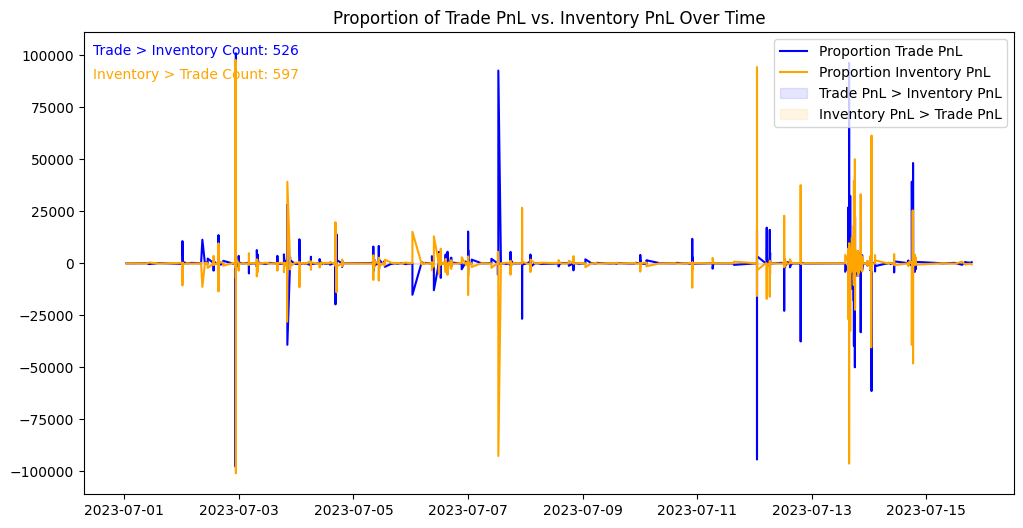

In [24]:
plt.figure(figsize=(12, 6))

plt.plot(df.index, df['proportion_trade_pnl'], label='Proportion Trade PnL', color='blue')
plt.plot(df.index, df['proportion_inventory_pnl'], label='Proportion Inventory PnL', color='orange')

# Highlight periods where trade pnl is larger than inventory pnl
trade_higher = df['proportion_trade_pnl'] > df['proportion_inventory_pnl']
plt.fill_between(df.index, 0, trade_higher, color='blue', alpha=0.1, label='Trade PnL > Inventory PnL')

# Highlight periods where inventory pnl is larger than trade pnl
inventory_higher = df['proportion_trade_pnl'] < df['proportion_inventory_pnl']
plt.fill_between(df.index, 0, inventory_higher, color='orange', alpha=0.1, label='Inventory PnL > Trade PnL')

trade_higher_count = trade_higher.sum()
inventory_higher_count = inventory_higher.sum()

plt.text(0.01, 0.95, f'Trade > Inventory Count: {trade_higher_count}', transform=plt.gca().transAxes, color='blue')
plt.text(0.01, 0.90, f'Inventory > Trade Count: {inventory_higher_count}', transform=plt.gca().transAxes, color='orange')

plt.title('Proportion of Trade PnL vs. Inventory PnL Over Time')
plt.xlabel = 'Time'
plt.ylabel = 'Proportion'
plt.legend(loc='upper right',)
plt.show()

As we can see, simply plotting the proportion of `net_pnl` over `trade_pnl` and `inventory_pnl` for each transaction is not very informative. There is a lot of noise. Let's refine our analysis by looking at the proportion of cumulative PnL over time.

In [25]:
assert not (merged_data['cumulative_net_pnl'] == 0).any()
df['proportion_cumulative_trade_pnl'] = df['cumulative_trade_pnl'] / df['cumulative_net_pnl']
df['proportion_cumulative_inventory_pnl'] = df['cumulative_inventory_pnl'] / df['cumulative_net_pnl']
df.describe()

order_id     fill_prc     fill_qty          fee  fee_ccy_usd_rate  \
count  1.123000e+03  1123.000000  1123.000000  1123.000000       1123.000000   
mean   6.700046e+14  1934.634034     0.070110     0.000020        242.613197   
std    2.450876e+09    48.484356     0.033944     0.000073          4.742499   
min    6.700020e+14  1827.960000     0.000100     0.000000        235.954209   
25%    6.700034e+14  1895.555000     0.066300     0.000000        241.419819   
50%    6.700034e+14  1933.270000     0.068300     0.000000        241.419819   
75%    6.700040e+14  1974.705000     0.070200     0.000000        243.423520   
max    6.700096e+14  2029.450000     0.171900     0.000310        259.829225   

            fill_id      balance      bid_prc      ask_prc    trade_pnl  \
count  1.123000e+03  1123.000000  1123.000000  1123.000000  1123.000000   
mean   1.688934e+18     0.537670  1934.183001  1934.244078    -0.229504   
std    3.829630e+14     0.181855    48.309006    48.299740   150.536345   
min    1.688172e+18     0.080200  1827.500000  1827.510000  -348.172338   
25%    1.688554e+18     0.400750  1895.155000  1895.190000  -132.044110   
50%    1.689163e+18     0.545900  1932.340000  1932.350000   -14.639200   
75%    1.689270e+18     0.679150  1974.270000  1974.280000   131.984646   
max    1.689448e+18     0.962300  2027.970000  2027.980000   348.024299   

       cumulative_trade_pnl  balance_value  inventory_pnl  \
count           1123.000000    1123.000000    1123.000000   
mean            -183.293630    1042.039456       0.358441   
std              351.663327     357.325240     150.857925   
min             -992.703029     152.459398    -352.146492   
25%             -455.292608     766.094432    -131.842933   
50%             -194.069366    1056.635700      14.634960   
75%               84.295896    1309.237288     132.358610   
max              694.057345    1837.057266     349.460637   

       cumulative_inventory_pnl      net_pnl  cumulative_net_pnl  \
count               1123.000000  1123.000000         1123.000000   
mean                 314.342986     0.128937          131.049356   
std                  357.325240     4.575246           25.942323   
min                 -575.237072   -12.966081           76.735116   
25%                   38.397962    -0.464986          106.936711   
50%                  328.939230     0.025080          131.225344   
75%                  581.540818     0.462003          153.031198   
max                 1109.360796   133.710270          185.402966   

       proportion_trade_pnl  proportion_inventory_pnl  \
count           1123.000000               1123.000000   
mean              81.223476                -80.223476   
std             8407.701774               8407.701774   
min           -97701.500029            -100912.635012   
25%             -228.229837               -462.850856   
50%              -21.325938                 22.325938   
75%              463.850856                229.229837   
max           100913.635012              97702.500029   

       proportion_cumulative_trade_pnl  proportion_cumulative_inventory_pnl  
count                      1123.000000                          1123.000000  
mean                         -1.356097                             2.356097  
std                           2.892579                             2.892579  
min                          -9.354586                            -6.200503  
25%                          -3.472661                             0.315097  
50%                          -1.427146                             2.427146  
75%                           0.684903                             4.472661  
max                           7.200503                            10.354586

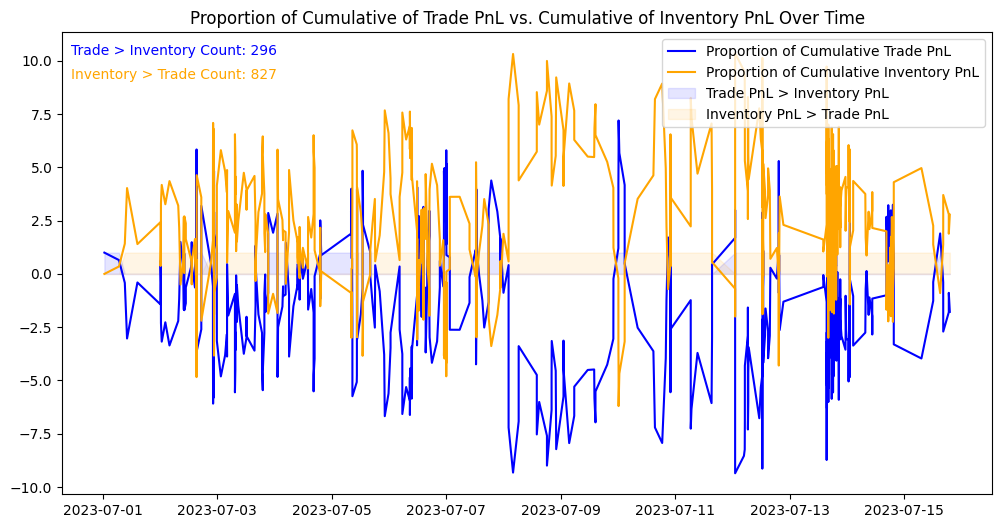

In [26]:
plt.figure(figsize=(12, 6))

plt.plot(df.index, df['proportion_cumulative_trade_pnl'], label='Proportion of Cumulative Trade PnL', color='blue')
plt.plot(df.index, df['proportion_cumulative_inventory_pnl'], label='Proportion of Cumulative Inventory PnL', color='orange')

# Highlight periods where trade pnl is larger than inventory pnl
trade_higher = df['proportion_cumulative_trade_pnl'] > df['proportion_cumulative_inventory_pnl']
plt.fill_between(df.index, 0, trade_higher, color='blue', alpha=0.1, label='Trade PnL > Inventory PnL')

# Highlight periods where inventory pnl is larger than trade pnl
inventory_higher = df['proportion_cumulative_trade_pnl'] < df['proportion_cumulative_inventory_pnl']
plt.fill_between(df.index, 0, inventory_higher, color='orange', alpha=0.1, label='Inventory PnL > Trade PnL')

trade_higher_count = trade_higher.sum()
inventory_higher_count = inventory_higher.sum()

plt.text(0.01, 0.95, f'Trade > Inventory Count: {trade_higher_count}', transform=plt.gca().transAxes, color='blue')
plt.text(0.01, 0.90, f'Inventory > Trade Count: {inventory_higher_count}', transform=plt.gca().transAxes, color='orange')

plt.title('Proportion of Cumulative of Trade PnL vs. Cumulative of Inventory PnL Over Time')
plt.xlabel = 'Time'
plt.ylabel = 'Proportion'
plt.legend(loc='upper right',)
plt.show()

In [27]:
# Finding when the trade pnl is larger than the inventory pnl
trade_higher_periods = df[trade_higher]
# There seems to be a pattern where trade pnl is larger than inventory pnl for a short period of time, and then followed by a much longer period of inventory pnl being larger than trade pnl.
# The ratio seems to be that inventory pnl is larger than trade pnl for about 73.64% of the time.

print(f"The proportion of time where trade pnl is larger than inventory pnl is {trade_higher_count / df.shape[0]:.2%}")
print(f"The proportion of time where inventory pnl is larger than trade pnl is {inventory_higher_count / df.shape[0]:.2%}")

trade_higher_periods_sells = trade_higher_periods[trade_higher_periods['side'] == 'S']
trade_higher_periods_buys = trade_higher_periods[trade_higher_periods['side'] == 'B']

print(f"The number of sells during trade higher periods: {trade_higher_periods_sells.shape[0]}")
print(f"The number of buys during trade higher periods: {trade_higher_periods_buys.shape[0]}")
print(f"The proportion of sells during trade higher periods: {trade_higher_periods_sells.shape[0] / trade_higher_count:.2%}")
print(f"The proportion of buys during trade higher periods: {trade_higher_periods_buys.shape[0] / trade_higher_count:.2%}")
trade_higher_periods
# Furthermore, even during this time, while there is a higher proportion of sells than buys, the difference is not that significant to me.

The proportion of time where trade pnl is larger than inventory pnl is 26.36%
The proportion of time where inventory pnl is larger than trade pnl is 73.64%
The number of sells during trade higher periods: 171
The number of buys during trade higher periods: 125
The proportion of sells during trade higher periods: 57.77%
The proportion of buys during trade higher periods: 42.23%


order_id side  fill_prc  fill_qty  \
timestamp                                                              
2023-07-01 00:46:05.617580  670003026938216    S   1937.83    0.0690   
2023-07-01 06:52:59.387733  670003026940777    B   1920.53    0.0264   
2023-07-02 00:18:38.297309  670003026944574    S   1919.58    0.0679   
2023-07-02 08:40:07.007292  670003026946968    S   1913.56    0.1719   
2023-07-02 10:13:45.795938  670003026947317    S   1917.62    0.1719   
...                                     ...  ...       ...       ...   
2023-07-14 19:13:42.475528  670008617124529    S   1918.36    0.0656   
2023-07-14 19:13:46.010801  670008617124591    B   1921.50    0.0699   
2023-07-14 19:13:59.996069  670008617124626    B   1923.39    0.0341   
2023-07-14 19:35:34.092633  670008617124966    B   1919.23    0.0708   
2023-07-15 15:01:52.361156  670008617129403    S   1930.18    0.1719   

                           liquidity       fee fee_ccy  fee_ccy_usd_rate  \
timestamp                                                                  
2023-07-01 00:46:05.617580     Maker  0.000000     bnb        237.395823   
2023-07-01 06:52:59.387733     Maker  0.000000     bnb        237.395823   
2023-07-02 00:18:38.297309     Maker  0.000000     bnb        237.395823   
2023-07-02 08:40:07.007292     Taker  0.000301     bnb        237.395823   
2023-07-02 10:13:45.795938     Taker  0.000302     bnb        237.395823   
...                              ...       ...     ...               ...   
2023-07-14 19:13:42.475528     Maker  0.000000     bnb        259.829225   
2023-07-14 19:13:46.010801     Maker  0.000000     bnb        259.829225   
2023-07-14 19:13:59.996069     Maker  0.000000     bnb        259.829225   
2023-07-14 19:35:34.092633     Maker  0.000000     bnb        259.829225   
2023-07-15 15:01:52.361156     Taker  0.000298     bnb        259.829225   

                                        fill_id  symbol_x  ...  \
timestamp                                                  ...   
2023-07-01 00:46:05.617580  1688172365615000000  eth_usdc  ...   
2023-07-01 06:52:59.387733  1688194379383000000  eth_usdc  ...   
2023-07-02 00:18:38.297309  1688257118287000000  eth_usdc  ...   
2023-07-02 08:40:07.007292  1688287207003000000  eth_usdc  ...   
2023-07-02 10:13:45.795938  1688292825737000000  eth_usdc  ...   
...                                         ...       ...  ...   
2023-07-14 19:13:42.475528  1689362022386000001  eth_usdc  ...   
2023-07-14 19:13:46.010801  1689362026008000000  eth_usdc  ...   
2023-07-14 19:13:59.996069  1689362039993000000  eth_usdc  ...   
2023-07-14 19:35:34.092633  1689363334015000000  eth_usdc  ...   
2023-07-15 15:01:52.361156  1689433312356000000  eth_usdc  ...   

                           cumulative_trade_pnl  balance_value  inventory_pnl  \
timestamp                                                                       
2023-07-01 00:46:05.617580           133.710270     727.696470       0.000000   
2023-07-01 06:52:59.387733            83.008278     772.343287      44.646817   
2023-07-02 00:18:38.297309            79.660017     775.629540    -130.327260   
2023-07-02 08:40:07.007292           184.776967     666.117198    -328.840402   
2023-07-02 10:13:45.795938           119.285148     732.910542    -330.357489   
...                                         ...            ...            ...   
2023-07-14 19:13:42.475528           435.424700     426.361804    -125.874592   
2023-07-14 19:13:46.010801           301.111850     561.065680     134.703876   
2023-07-14 19:13:59.996069           235.524251     627.152120      66.086440   
2023-07-14 19:35:34.092633            99.642767     761.835060     134.682940   
2023-07-15 15:01:52.361156           276.136560     596.899826    -332.169246   

                            cumulative_inventory_pnl     net_pnl  \
timestamp                                                          
2023-07-01 00:46:05.617580                  0.000000  133.71

Looking at the graph, I noticed that the direction of `trade_pnl` and `inventory_pnl` are often times inverse to each other. This suggests to me that the strategy hegdes its risk by balancing gains from trading activities with the valuation of held positions.

#### Segmenting PnL by Momentum

Since I made the assumption that the strategy is long-term and may not be too concerned with short-term fluctuations in the market, I will investigate the impact of momentum on the PnL. To accomplish this, I will need to engineer a new categorical that capture the momentum on whether the asset is bull, bear, or neutral. Here, I define momentum as the price momentum of the asset. If the percentage change in the price of an asset is above the bull threshold, then the momentum is bull, and if it is below the bear threshold, then the momentum is bear. Otherwise, the momentum is neutral.

In [28]:
df = merged_data.copy()
df

order_id side  fill_prc  fill_qty  \
timestamp                                                              
2023-07-01 00:46:05.617580  670003026938216    S   1937.83    0.0690   
2023-07-01 06:52:59.387733  670003026940777    B   1920.53    0.0264   
2023-07-01 09:19:52.809436  670003026941465    B   1914.23    0.0707   
2023-07-01 10:16:21.048157  670003026941676    B   1916.97    0.1719   
2023-07-01 14:37:25.452850  670003026943147    S   1921.43    0.1719   
...                                     ...  ...       ...       ...   
2023-07-15 16:18:25.726018  670008617129681    B   1935.21    0.1719   
2023-07-15 16:19:06.461829  670008617129719    B   1936.04    0.1719   
2023-07-15 18:39:02.613882  670008617130081    S   1939.44    0.0670   
2023-07-15 18:39:02.614281  670008617130071    S   1939.87    0.0674   
2023-07-15 19:04:52.935896  670008617130139    B   1935.97    0.0666   

                           liquidity       fee fee_ccy  fee_ccy_usd_rate  \
timestamp                                                                  
2023-07-01 00:46:05.617580     Maker  0.000000     bnb        237.395823   
2023-07-01 06:52:59.387733     Maker  0.000000     bnb        237.395823   
2023-07-01 09:19:52.809436     Maker  0.000000     bnb        237.395823   
2023-07-01 10:16:21.048157     Taker  0.000305     bnb        237.395823   
2023-07-01 14:37:25.452850     Maker  0.000000     bnb        237.395823   
...                              ...       ...     ...               ...   
2023-07-15 16:18:25.726018     Taker  0.000299     bnb        259.829225   
2023-07-15 16:19:06.461829     Taker  0.000299     bnb        259.829225   
2023-07-15 18:39:02.613882     Maker  0.000000     bnb        259.829225   
2023-07-15 18:39:02.614281     Maker  0.000000     bnb        259.829225   
2023-07-15 19:04:52.935896     Maker  0.000000     bnb        259.829225   

                                        fill_id  symbol_x  ...  bid_prc  \
timestamp                                                  ...            
2023-07-01 00:46:05.617580  1688172365615000000  eth_usdc  ...  1937.94   
2023-07-01 06:52:59.387733  1688194379383000000  eth_usdc  ...  1921.73   
2023-07-01 09:19:52.809436  1688203192806000000  eth_usdc  ...  1915.36   
2023-07-01 10:16:21.048157  1688206581043000000  eth_usdc  ...  1917.32   
2023-07-01 14:37:25.452850  1688222245450000000  eth_usdc  ...  1921.86   
...                                         ...       ...  ...      ...   
2023-07-15 16:18:25.726018  1689437905700000000  eth_usdc  ...  1932.34   
2023-07-15 16:19:06.461829  1689437946423000000  eth_usdc  ...  1932.34   
2023-07-15 18:39:02.613882  1689446342610000000  eth_usdc  ...  1932.34   
2023-07-15 18:39:02.614281  1689446342610000001  eth_usdc  ...  1932.34   
2023-07-15 19:04:52.935896  1689447892932000000  eth_usdc  ...  1932.34   

                            ask_prc          symbol_y   trade_pnl  \
timestamp                                                           
2023-07-01 00:46:05.617580  1937.95  binance_eth_usdt  133.710270   
2023-07-01 06:52:59.387733  1921.74  binance_eth_usdt  -50.701992   
2023-07-01 09:19:52.809436  1915.37  binance_eth_usdt -135.336061   
2023-07-01 10:16:21.048157  1917.33  binance_eth_usdt -329.599496   
2023-07-01 14:37:25.452850  1921.87  binance_eth_usdt  330.293817   
...                             ...               ...         ...   
2023-07-15 16:18:25.726018  1932.35  binance_eth_usdt -332.740259   
2023-07-15 16:19:06.461829  1932.35  binance_eth_usdt -332.882936   
2023-07-15 18:39:02.613882  1932.35  binance_eth_usdt  129.942480   
2023-07-15 18:39:02.614281  1932.35  binance_eth_usdt  130.747238   
2023-07-15 19:04:52.935896  1932.35  binance_eth_usdt -128.935602   

                           cumulative_trade_pnl  balance_value  inventory_pnl  \
timestamp                                                                       
2023-07-01 00:46:05.617580           133.710270     727.696470       0.00

In [29]:
# The feature `mid_prc` is a new feature which is the average between `bid_prc` and `ask_prc`.
df['mid_prc'] = (df['bid_prc'] + df['ask_prc']) / 2
df['mid_prc_pct_change'] = df['mid_prc'].pct_change()

bull_threshold = 0.0005
bear_threshold = -0.0005

def categorize_momentum_condition(row):
  if row['mid_prc_pct_change'] > bull_threshold:
    return 'Bull'
  elif row['mid_prc_pct_change'] < bear_threshold:
    return 'Bear'
  else:
    return 'Neutral'

df['momentum_condition'] = df.apply(categorize_momentum_condition, axis=1)
df['momentum_condition'].value_counts()

momentum_condition
Neutral    582
Bear       276
Bull       265
Name: count, dtype: int64

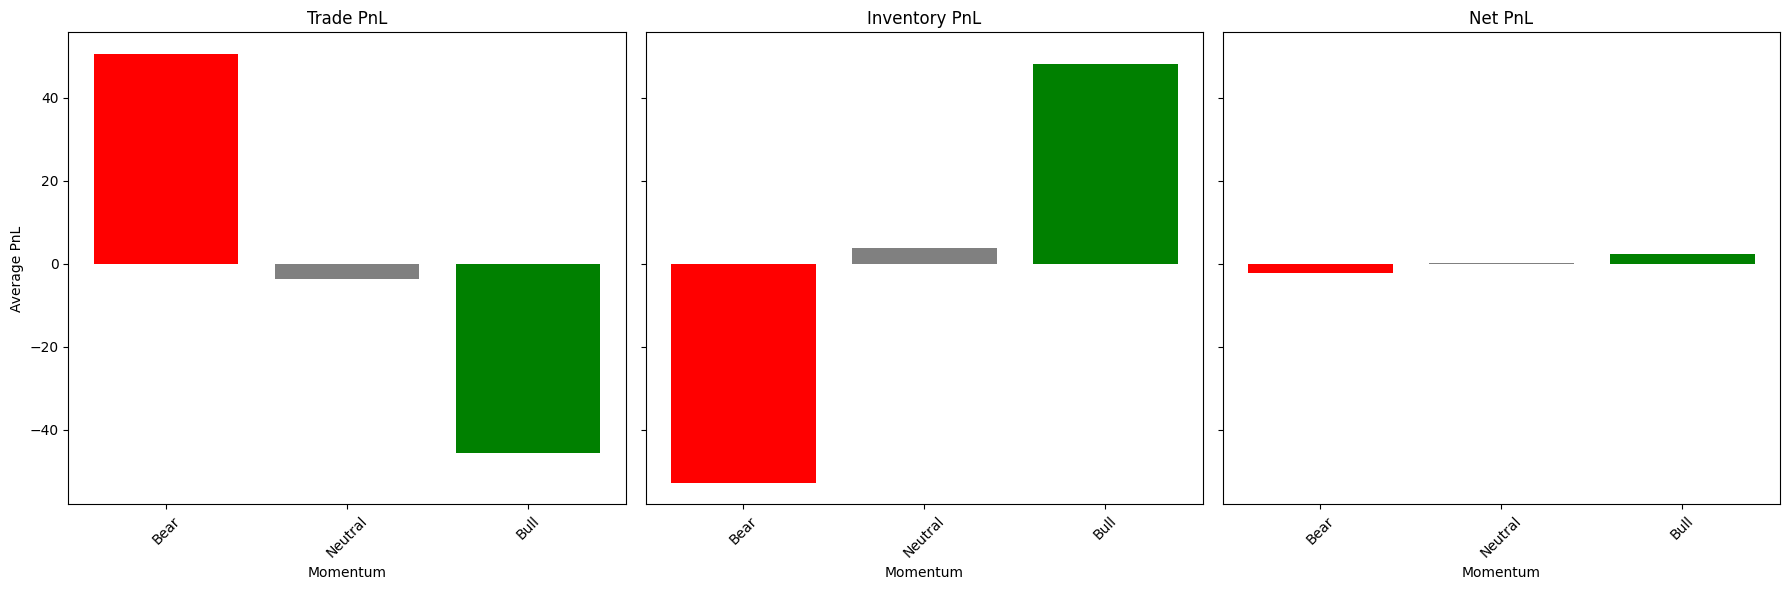

In [30]:
df['momentum_condition'] = pd.Categorical(df['momentum_condition'], categories=['Bear', 'Neutral', 'Bull'], ordered=True)
avg_pnls_by_condition = df.groupby('momentum_condition', observed=True)[['trade_pnl', 'inventory_pnl', 'net_pnl']].mean().reindex(['Bear', 'Neutral', 'Bull'])

fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
titles = ['Trade PnL', 'Inventory PnL', 'Net PnL']
momentum_conditions = avg_pnls_by_condition.index
x = range(len(momentum_conditions))

for i, pnl_type in enumerate(['trade_pnl', 'inventory_pnl', 'net_pnl']):
    axs[i].bar(x, avg_pnls_by_condition[pnl_type], color=['red', 'gray', 'green'])
    axs[i].set_title(titles[i])
    axs[i].set_xlabel('Momentum')
    axs[i].set_ylabel('Average PnL' if i == 0 else '')
    
    axs[i].set_xticks(x)
    axs[i].set_xticklabels(momentum_conditions, rotation=45)

plt.tight_layout()
plt.show()

In [31]:
# A helper function because I will be using this a lot
def interpret_p_value(p_value, message, alpha=0.05):
    if p_value < alpha:
        print(f"There is a statistical significance in {message} (p-value: {p_value:.3f})")
    else:
        print(f"There is no statistical significance in {message} (p-value: {p_value:.3f})")

In [32]:
# I will use the Kruskal-Wallis test to check if there is a statistically significant difference in the average trade pnl, inventory pnl, and net pnl across momentums.
# I am using this test because trade pnl and inventory pnl does not have a normal distribution and the Kruskal-Wallis test is a non-parametric test that does not assume normality vs. ANOVA which requires normality.
for pnl_type in ['trade_pnl', 'inventory_pnl', 'net_pnl']:
    groups = [group[pnl_type].dropna() for name, group in df.groupby('momentum_condition')]
    stat, p_value = stats.kruskal(*groups)
    print(f"{pnl_type} Kruskal-Wallis test: H={stat:.3f}, p={p_value:.5f}")
    interpret_p_value(p_value, f"average {pnl_type} across momentums")

trade_pnl Kruskal-Wallis test: H=35.633, p=0.00000
There is a statistical significance in average trade_pnl across momentums (p-value: 0.000)
inventory_pnl Kruskal-Wallis test: H=75.011, p=0.00000
There is a statistical significance in average inventory_pnl across momentums (p-value: 0.000)
net_pnl Kruskal-Wallis test: H=918.543, p=0.00000
There is a statistical significance in average net_pnl across momentums (p-value: 0.000)


In [33]:
# Values from net pnl
print("Average Net PnL by momentum")
avg_pnls_by_condition['net_pnl']

Average Net PnL by momentum


momentum_condition
Bear      -2.265329
Neutral    0.266084
Bull       2.321384
Name: net_pnl, dtype: float64

From the plots above, we identified that `trade_pnl` is more profitable during a bear momentum, while `inventory_pnl` is more profitable during a bull momentum. This tells me that the strategy emphasizes `trade_pnl` during bear momentums, quickly turning over inventory to avoid holding declining assets. Furthermore, `inventory_pnl` seems to outweight `trade_pnl` during all momentum conditions. One interpretation for this observation is that the strategy hedges its positional risk by trading activities. During a bear momentum, `trade_pnl` ensures the strategy does not lose as much as it could, but at the same time limits the `net_pnl` from earning as much as it could during neutral and bull momentums. However, this is a worthwhile trade-off as it ensures that the profits gained from the strategy are not lost during a bear momentum.

One of my concerns is that the gains during a neutral momentum may be too little when inflation is put into consideration. Furthermore, the majority of our profits is concentrated in unrealized gains from holding more assets and not cash. In a more broader context, it increases our exposure to momentum and runs the risk of not being able to sell assets during a crash, which is a real concern for crypto assets.

#### Segmenting PnL by Volatility

Like I mentioned before, I want to investigate the impact of market volatility on the PnL of the strategy. I will calculate the volatility of the market and then plot the PnL against the volatility.

In [34]:
# Check how many transactions happen per day 
df = merged_data.copy()
df['date'] = df.index.date

transactions_per_day = df.groupby('date').size()
transactions_per_day

date
2023-07-01      5
2023-07-02    119
2023-07-03     61
2023-07-04     56
2023-07-05     61
2023-07-06     82
2023-07-07     66
2023-07-08     19
2023-07-09     16
2023-07-10     33
2023-07-11     12
2023-07-12     96
2023-07-13    383
2023-07-14    104
2023-07-15     10
dtype: int64

Since the trading strategy makes several transactions in a day, we can take advantage of this and aggregate same transactions in a day to calculate the daily volatility.

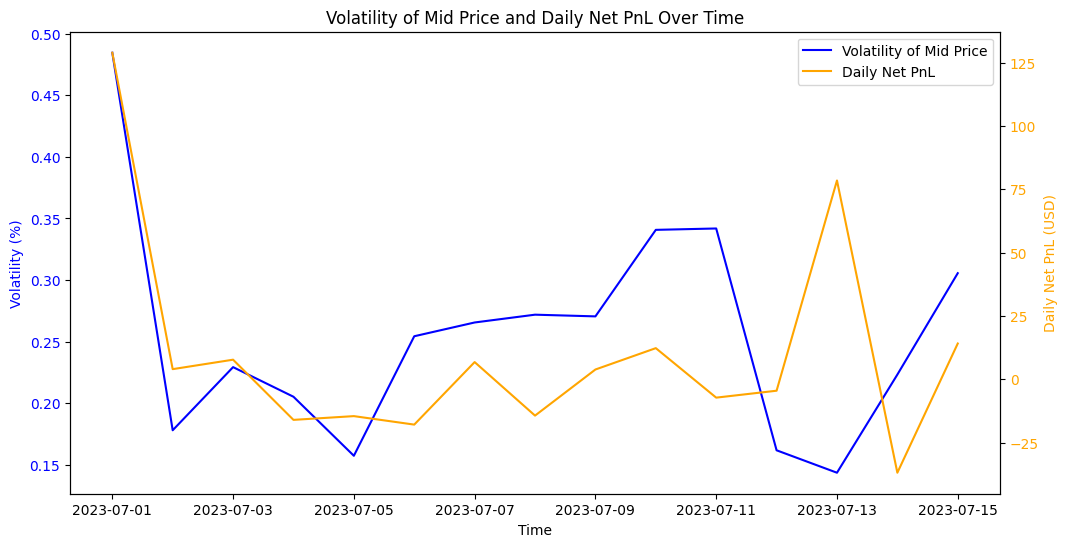

In [35]:
df.sort_index(inplace=True)

# Using `mid_prc` to calculate the volatility of the Mid Price.
df['mid_prc'] = (df['bid_prc'] + df['ask_prc']) / 2
df['mid_prc_pct_change'] = df['mid_prc'].pct_change()
# The reason I am using `mid_prc` instead of the `mid_prc` is because `fill_pcr` data reflects the prices of buys and sells, so it is difficult to obtain a gauge the average trading volatility from this data.
mid_prc_daily_volatility = df.groupby('date')['mid_prc_pct_change'].std() * 100
daily_net_pnl = df.groupby('date')['net_pnl'].sum()

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(mid_prc_daily_volatility.index, mid_prc_daily_volatility, label="Volatility of Mid Price", color='blue')
ax1.set_ylabel('Volatility (%)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xlabel("Time")
plt.title("Volatility of Mid Price and Daily Net PnL Over Time")

ax2 = ax1.twinx()
ax2.plot(daily_net_pnl.index, daily_net_pnl, label="Daily Net PnL", color='orange')
ax2.set_ylabel('Daily Net PnL (USD)', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.show()

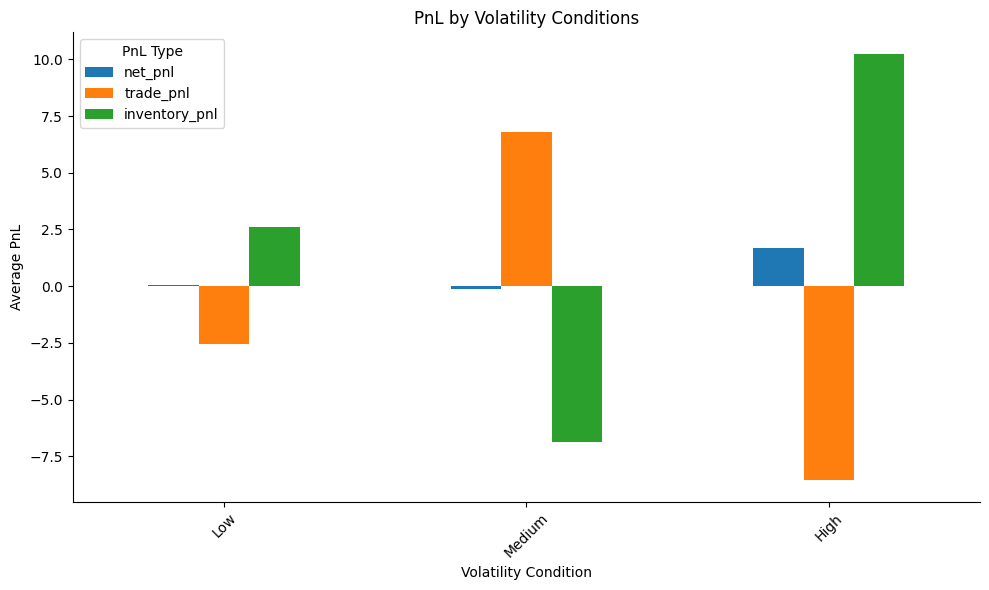

net_pnl  trade_pnl  inventory_pnl
volatility_category                                    
Low                  0.066319  -2.533121       2.599440
Medium              -0.110621   6.776228      -6.886849
High                 1.693333  -8.556075      10.249408

In [36]:
volatility_bins = pd.qcut(mid_prc_daily_volatility, q=3, labels=['Low', 'Medium', 'High'])
df['volatility_category'] = df['date'].map(volatility_bins)

pnl_by_volatility = df.groupby('volatility_category')[['net_pnl', 'trade_pnl', 'inventory_pnl']].mean()

fig, ax = plt.subplots(figsize=(10, 6))
pnl_by_volatility.plot(kind='bar', ax=ax)

ax.set_title('PnL by Volatility Conditions')
ax.set_xlabel('Volatility Condition')
ax.set_ylabel('Average PnL')
ax.set_xticklabels(pnl_by_volatility.index, rotation=45)

ax.legend(title='PnL Type')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

pnl_by_volatility

Inspecting the figure, we can observe that the `daily_net_pnl` generally follows the same trend as `mid_prc` volatility except in some instances, most notably the periods between 2023-07-12 - 2023-07-14. During this time period, volatility falls very low but the `daily_net_pnl` increases.

Furthermore, the second plot shows the behaviour of `net_pnl`, `trade_pnl`, and `inventory_pnl` against `mid_prc` daily volatility in three categories: low, medium, high. With this, I noticed the pattern that the PnL for `trade_pnl` and `inventory_pnl` by volatility conditions are in the inverse direction to each other in all three categories. This suggests that the strategy hedges against risk in all volatility conditions. This aligns with the finding in the previous section where we observed that the strategy hedges against risk in bear, bull, and neutral momentum conditions.

In calculating volatility, I have the choice of either using `fill_prc` or `mid_prc`. Here, I believe using `mid_prc` is more representative in investigating trading volatility because the data in `fill_prc` flips between buys and sells, making it more difficult to gain an good gauge of the general market volatility.

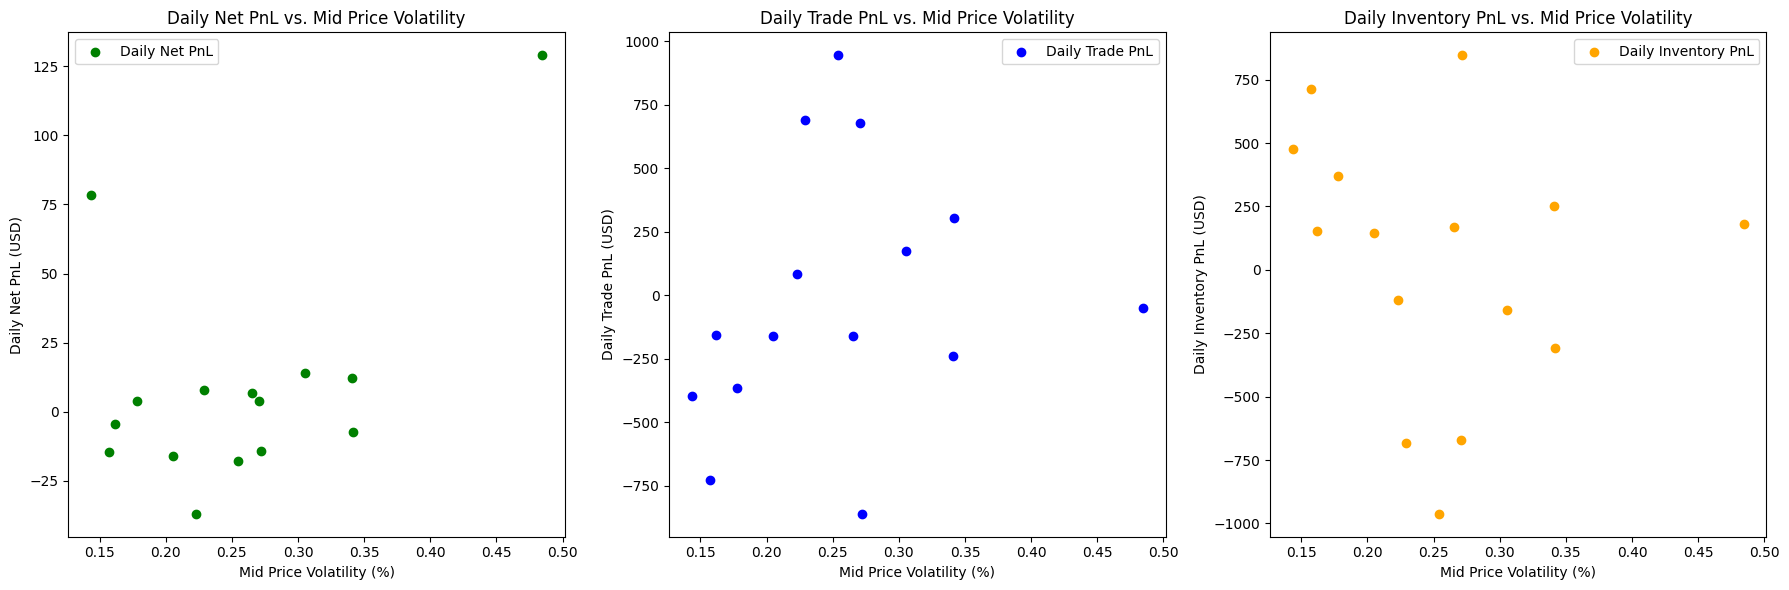

In [37]:
# Aggregate pnl data by date so we can plot the pnl against volatility
daily_trade_pnl = df.groupby('date')['trade_pnl'].sum()
daily_inventory_pnl = df.groupby('date')['inventory_pnl'].sum()
plot_data = pd.DataFrame({
    'Mid Price Volatility': mid_prc_daily_volatility,
    'Daily Net PnL': daily_net_pnl,
    'Daily Trade PnL': daily_trade_pnl,
    'Daily Inventory PnL': daily_inventory_pnl
}).dropna()

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Scatter Plot 1: Daily Net PnL vs. Mid Price Volatility
axs[0].scatter(plot_data['Mid Price Volatility'], plot_data['Daily Net PnL'], color='green', label='Daily Net PnL')
axs[0].set_title('Daily Net PnL vs. Mid Price Volatility')
axs[0].set_xlabel('Mid Price Volatility (%)')
axs[0].set_ylabel('Daily Net PnL (USD)')
axs[0].legend()

# Scatter Plot 2: Daily Trade PnL vs. Mid Price Volatility
axs[1].scatter(plot_data['Mid Price Volatility'], plot_data['Daily Trade PnL'], color='blue', label='Daily Trade PnL')
axs[1].set_title('Daily Trade PnL vs. Mid Price Volatility')
axs[1].set_xlabel('Mid Price Volatility (%)')
axs[1].set_ylabel('Daily Trade PnL (USD)')
axs[1].legend()

# Scatter Plot 3: Daily Inventory PnL vs. Mid Price Volatility
axs[2].scatter(plot_data['Mid Price Volatility'], plot_data['Daily Inventory PnL'], color='orange', label='Daily Inventory PnL')
axs[2].set_title('Daily Inventory PnL vs. Mid Price Volatility')
axs[2].set_xlabel('Mid Price Volatility (%)')
axs[2].set_ylabel('Daily Inventory PnL (USD)')
axs[2].legend()

fig.tight_layout()
plt.show()

In [38]:
corr_volatility_net_pnl, p_value_net_pnl = pearsonr(plot_data['Mid Price Volatility'], plot_data['Daily Net PnL'])
print(f"Correlation between Volatility and Net PnL: {corr_volatility_net_pnl}, P-value: {p_value_net_pnl}")
interpret_p_value(p_value_net_pnl, "correlation between volatility and net pnl")

corr_volatility_trade_pnl, p_value_trade_pnl = pearsonr(plot_data['Mid Price Volatility'], plot_data['Daily Trade PnL'])
print(f"Correlation between Volatility and Trade PnL: {corr_volatility_trade_pnl}, P-value: {p_value_trade_pnl}")
interpret_p_value(p_value_trade_pnl, "correlation between volatility and trade pnl")

corr_volatility_inventory_pnl, p_value_inventory_pnl = pearsonr(plot_data['Mid Price Volatility'], plot_data['Daily Inventory PnL'])
print(f"Correlation between Volatility and Inventory PnL: {corr_volatility_inventory_pnl}, P-value: {p_value_inventory_pnl}")
interpret_p_value(p_value_inventory_pnl, "correlation between volatility and inventory pnl")

Correlation between Volatility and Net PnL: 0.4823970501428044, P-value: 0.06858227450991461
There is no statistical significance in correlation between volatility and net pnl (p-value: 0.069)
Correlation between Volatility and Trade PnL: 0.2232965414989115, P-value: 0.4237251947813019
There is no statistical significance in correlation between volatility and trade pnl (p-value: 0.424)
Correlation between Volatility and Inventory PnL: -0.1820071416866053, P-value: 0.5161998590433359
There is no statistical significance in correlation between volatility and inventory pnl (p-value: 0.516)


Observing the scatterplots, we can see that the volatility of `mid_prc` is not correlated with `net_pnl`, `daily_trade_pnl` and `daily_inventory_pnl`. We verified this using a Pearson correlation. This is an important result as it tells us that the PnL of our strategy is not affected by volatility. This is good because it means that the PnL of the strategy shows characteristics of genuine alpha.

#### Segmenting PnL by Market Stress Periods (Trading Volume)

Next, I want to identify if market stress, or trading volume, has an impact on the PnL of the strategy. I will aggregate the volume of trades transacted in a day by aggregating `fill_qty` and then plot the PnL against the volume.

In [39]:
# Calculate daily volume
df = merged_data.copy()
df['date'] = df.index.date
trading_volume = df.groupby('date')['fill_qty'].sum()
trading_volume

date
2023-07-01     0.5099
2023-07-02     8.6067
2023-07-03     4.5653
2023-07-04     4.1824
2023-07-05     4.3114
2023-07-06     6.2745
2023-07-07     3.7855
2023-07-08     1.9526
2023-07-09     1.1085
2023-07-10     2.6732
2023-07-11     1.1461
2023-07-12     6.9174
2023-07-13    24.4383
2023-07-14     7.2115
2023-07-15     1.0497
Name: fill_qty, dtype: float64

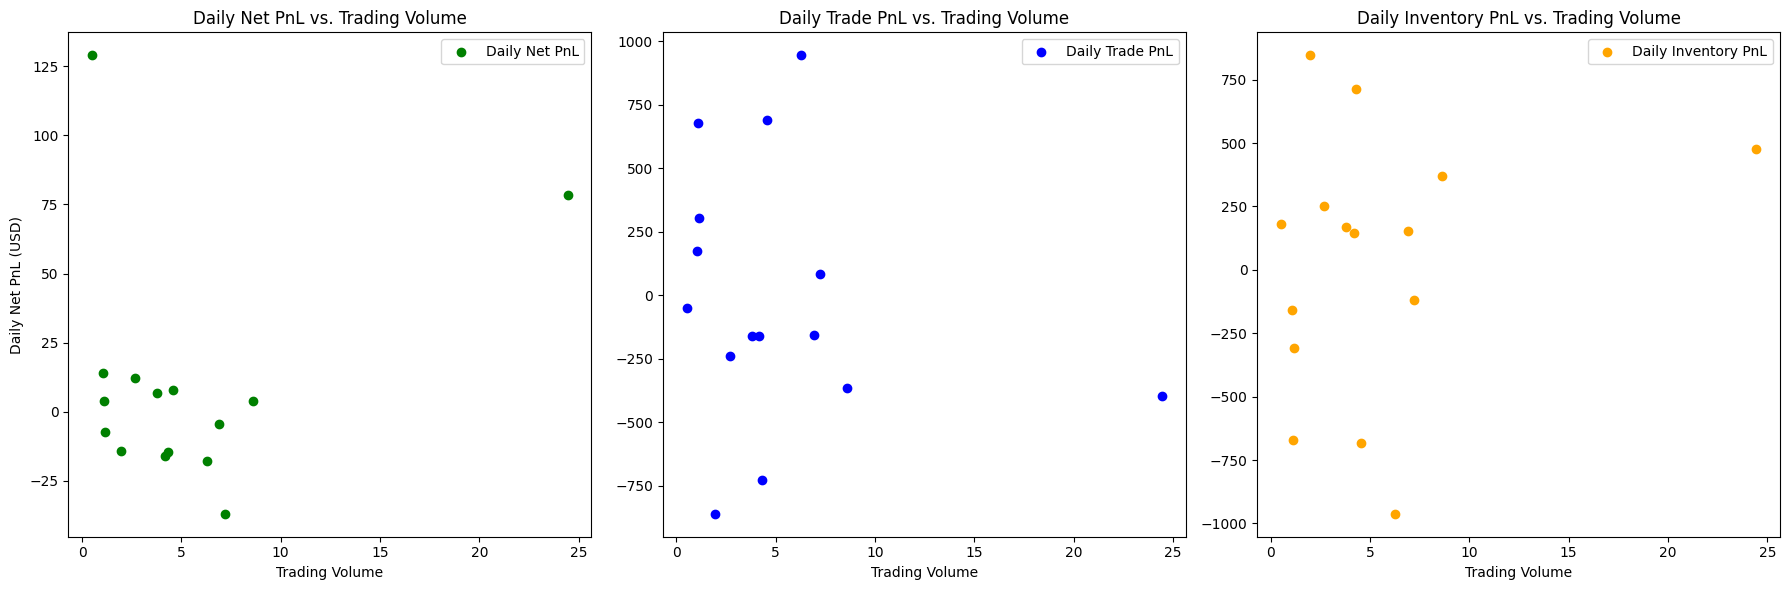

In [40]:
plot_data = pd.DataFrame({
    'Trading Volume': trading_volume,
    'Daily Net PnL': daily_net_pnl,
    'Daily Trade PnL': daily_trade_pnl,
    'Daily Inventory PnL': daily_inventory_pnl
}).dropna() # Ensuring clean plotting data


fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Scatter Plot 1: Daily Net PnL vs. Trading Volume
axs[0].scatter(plot_data['Trading Volume'], plot_data['Daily Net PnL'], color='green', label='Daily Net PnL')
axs[0].set_title('Daily Net PnL vs. Trading Volume')
axs[0].set_xlabel('Trading Volume')
axs[0].set_ylabel('Daily Net PnL (USD)')
axs[0].legend()

# Scatter Plot 2: Daily Trade PnL vs. Trading Volume
axs[1].scatter(plot_data['Trading Volume'], plot_data['Daily Trade PnL'], color='blue', label='Daily Trade PnL')
axs[1].set_title('Daily Trade PnL vs. Trading Volume')
axs[1].set_xlabel('Trading Volume')
axs[1].legend()

# Scatter Plot 3: Daily Inventory PnL vs. Trading Volume
axs[2].scatter(plot_data['Trading Volume'], plot_data['Daily Inventory PnL'], color='orange', label='Daily Inventory PnL')
axs[2].set_title('Daily Inventory PnL vs. Trading Volume')
axs[2].set_xlabel('Trading Volume')
axs[2].legend()

fig.tight_layout()
plt.show()


In [41]:
corr_volume_net_pnl, p_value_volume_net_pnl = pearsonr(plot_data['Trading Volume'], plot_data['Daily Net PnL'])
print(f"Correlation between Trading Volume and Net PnL: {corr_volume_net_pnl}, P-value: {p_value_volume_net_pnl}")
interpret_p_value(p_value_volume_net_pnl, "correlation between trading volume and net pnl")

corr_volume_trade_pnl, p_value_volume_trade_pnl = pearsonr(plot_data['Trading Volume'], plot_data['Daily Trade PnL'])
print(f"Correlation between Trading Volume and Trade PnL: {corr_volume_trade_pnl}, P-value: {p_value_volume_trade_pnl}")
interpret_p_value(p_value_volume_trade_pnl, "correlation between trading volume and trade pnl")

corr_volume_inventory_pnl, p_value_volume_inventory_pnl = pearsonr(plot_data['Trading Volume'], plot_data['Daily Inventory PnL'])
print(f"Correlation between Trading Volume and Inventory PnL: {corr_volume_inventory_pnl}, P-value: {p_value_volume_inventory_pnl}")
interpret_p_value(p_value_volume_inventory_pnl, "correlation between trading volume and inventory pnl")

Correlation between Trading Volume and Net PnL: 0.23221069228018756, P-value: 0.4049575970726101
There is no statistical significance in correlation between trading volume and net pnl (p-value: 0.405)
Correlation between Trading Volume and Trade PnL: -0.20094110793006886, P-value: 0.47269447984944774
There is no statistical significance in correlation between trading volume and trade pnl (p-value: 0.473)
Correlation between Trading Volume and Inventory PnL: 0.2176161935432314, P-value: 0.43591324305288714
There is no statistical significance in correlation between trading volume and inventory pnl (p-value: 0.436)


Likewise, there is no correlation between trading volume and `net_pnl`, `daily_trade_pnl` and `daily_inventory_pnl`. This is a good sign as it means that the strategy is robust and can handle market stress

#### Segmenting PnL by Liquidity (Spread)

Another interesting point to consider is the impact of liquidity on the PnL of the strategy. Formulating the question more formally, does the spread between the bid and ask price have an impact on the PnL of the strategy? I will calculate the spread and then plot the PnL against the spread. I want to consider the behavior of the strategy in different liquidity conditions.

In [42]:
df = merged_data.copy()
df['spread'] = df['ask_prc'] - df['bid_prc']
df['spread'].describe() # Checking the spread column, we do not have negative values, which verifies that my calculation is correct.

count    1123.000000
mean        0.061077
std         0.221057
min         0.010000
25%         0.010000
50%         0.010000
75%         0.010000
max         2.840000
Name: spread, dtype: float64

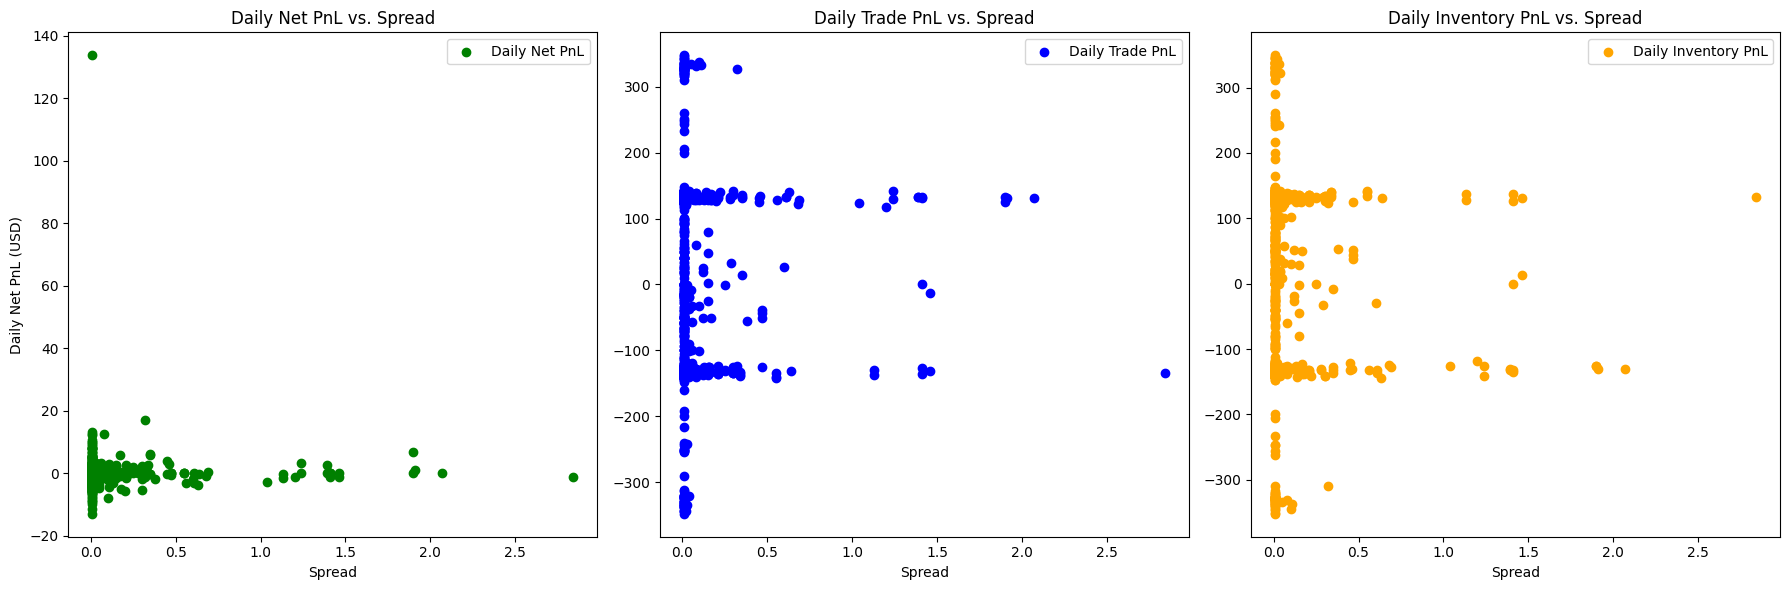

In [43]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Scatter Plot 1: Daily Net PnL vs. Spread
axs[0].scatter(df['spread'], df['net_pnl'], color='green', label='Daily Net PnL')
axs[0].set_title('Daily Net PnL vs. Spread')
axs[0].set_xlabel('Spread')
axs[0].set_ylabel('Daily Net PnL (USD)')
axs[0].legend()

# Scatter Plot 2: Daily Trade PnL vs. Spread
axs[1].scatter(df['spread'], df['trade_pnl'], color='blue', label='Daily Trade PnL')
axs[1].set_title('Daily Trade PnL vs. Spread')
axs[1].set_xlabel('Spread')
axs[1].legend()

# Scatter Plot 3: Daily Inventory PnL vs. Spread
axs[2].scatter(df['spread'], df['inventory_pnl'], color='orange', label='Daily Inventory PnL')
axs[2].set_title('Daily Inventory PnL vs. Spread')
axs[2].set_xlabel('Spread')
axs[2].legend()

fig.tight_layout()
plt.show()

In [44]:
corr_spread_net_pnl, p_value_spread_net_pnl = pearsonr(df['spread'], df['net_pnl'])
print(f"Correlation between Spread and Net PnL: {corr_spread_net_pnl}, P-value: {p_value_spread_net_pnl}")
interpret_p_value(p_value_spread_net_pnl, "correlation between spread and net pnl")

corr_spread_trade_pnl, p_value_spread_trade_pnl = pearsonr(df['spread'], df['trade_pnl'])
print(f"Correlation between Spread and Trade PnL: {corr_spread_trade_pnl}, P-value: {p_value_spread_trade_pnl}")
interpret_p_value(p_value_spread_trade_pnl, "correlation between spread and trade pnl")

corr_spread_inventory_pnl, p_value_spread_inventory_pnl = pearsonr(df['spread'], df['inventory_pnl'])
print(f"Correlation between Spread and Inventory PnL: {corr_spread_inventory_pnl}, P-value: {p_value_spread_inventory_pnl}")
interpret_p_value(p_value_spread_inventory_pnl, "correlation between spread and inventory pnl")

Correlation between Spread and Net PnL: 0.005224927137521384, P-value: 0.8611584174235888
There is no statistical significance in correlation between spread and net pnl (p-value: 0.861)
Correlation between Spread and Trade PnL: 0.03144792496162126, P-value: 0.29236654638174125
There is no statistical significance in correlation between spread and trade pnl (p-value: 0.292)
Correlation between Spread and Inventory PnL: -0.03122242555886627, P-value: 0.2958425983905244
There is no statistical significance in correlation between spread and inventory pnl (p-value: 0.296)


Similarly, the PnL of the strategy is not correlated with the spread. This is a good sign as it means that the strategy is robust and can handle different liquidity conditions.

#### Segmenting PnL by Deviation from Target Inventory

As stated in the problem statement, the strategy is market making around a target inventory. I want to investigate the `balance` of our trading strategy and what this target inventory might be. Furthermore, I want to see if there are any trends in the PnL when the inventory deviates from my estimated target inventory.

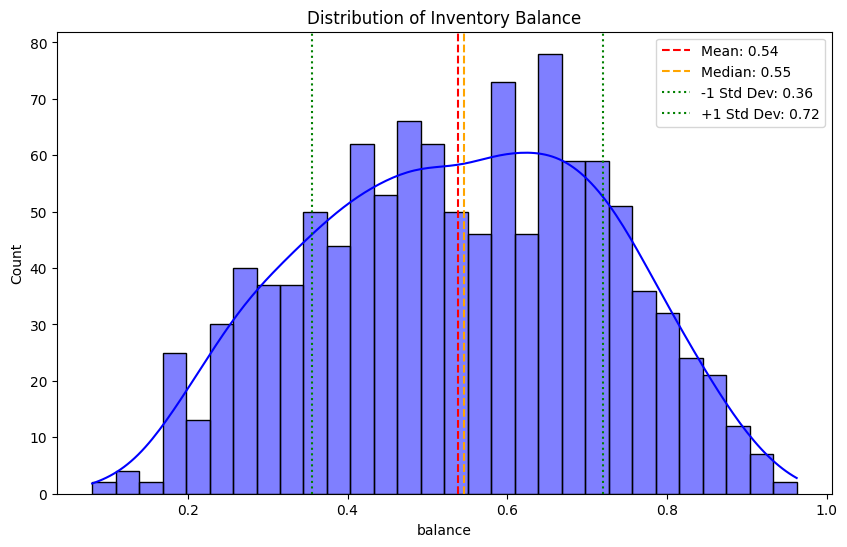

In [45]:
# Firstly, let us investigate the distribution of our inventory balance 
df = merged_data.copy()

plt.figure(figsize=(10, 6))
sns.histplot(df['balance'], bins = 30, kde = True, color = 'blue')

mean_balance = df['balance'].mean()
median_balance = df['balance'].median()
std_balance = df['balance'].std()

plt.axvline(mean_balance, color ='red', linestyle='--', label = f'Mean: {mean_balance:.2f}')
plt.axvline(median_balance, color ='orange', linestyle='--', label = f'Median: {median_balance:.2f}')
plt.axvline(mean_balance - std_balance, color='green', linestyle=':', label=f'-1 Std Dev: {mean_balance - std_balance:.2f}')
plt.axvline(mean_balance + std_balance, color='green', linestyle=':', label=f'+1 Std Dev: {mean_balance + std_balance:.2f}')

plt.legend()
plt.title('Distribution of Inventory Balance')
plt.xlabel='Balance'
plt.ylabel='Frequency'


In [46]:
stat, p = shapiro(df['balance'])

print("Shapiro-Wilk Test for balance:")
print(f"Statistics={stat:.3f}, p={p:.3f}")
# The distribution of balance is not normal. Let's see if we can apply the Central Limit Theorem to construct a confidence interval for the mean of the balance.

Shapiro-Wilk Test for balance:
Statistics=0.986, p=0.000


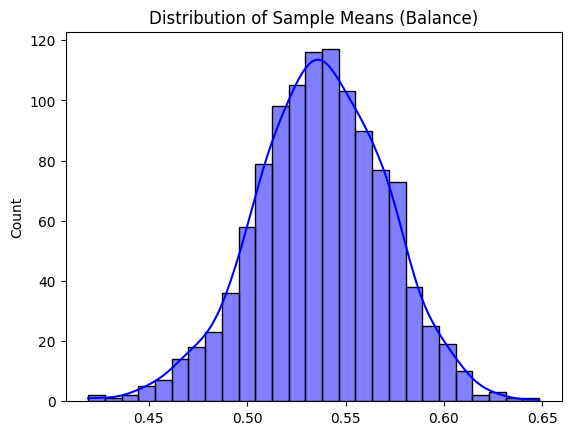

In [47]:
n_samples = 1123  # Number of samples to take
sample_size = 30  # Size of each sample

sample_means = [df['balance'].sample(sample_size).mean() for _ in range(n_samples)]

sns.histplot(sample_means, kde=True, color='blue')
plt.title('Distribution of Sample Means (Balance)')
plt.xlabel = 'Sample Means of Balance'
plt.ylabel = 'Frequency'
plt.show()

In [48]:
stat, p = shapiro(sample_means)

print("Shapiro-Wilk Test for balance:")
print(f"Statistics={stat:.3f}, p={p:.3f}")
# Indeed our sample means is normal as our p-value is greater than 0.05 for the Shapiro-Wilk test.

Shapiro-Wilk Test for balance:
Statistics=0.998, p=0.169


In [49]:
mean_of_sample_means = np.mean(sample_means)
std_of_sample_means = np.std(sample_means)

# Calculate the 95% confidence interval for the mean balance
z_score = 1.96  # Z-score for 95% confidence
margin_of_error = z_score * (std_of_sample_means / np.sqrt(n_samples))

lower_bound_balance = mean_of_sample_means - margin_of_error
upper_bound_balance = mean_of_sample_means + margin_of_error

print(f"95% confidence interval for the target inventory: {lower_bound_balance:.2f} to {upper_bound_balance:.2f}")

95% confidence interval for the target inventory: 0.54 to 0.54


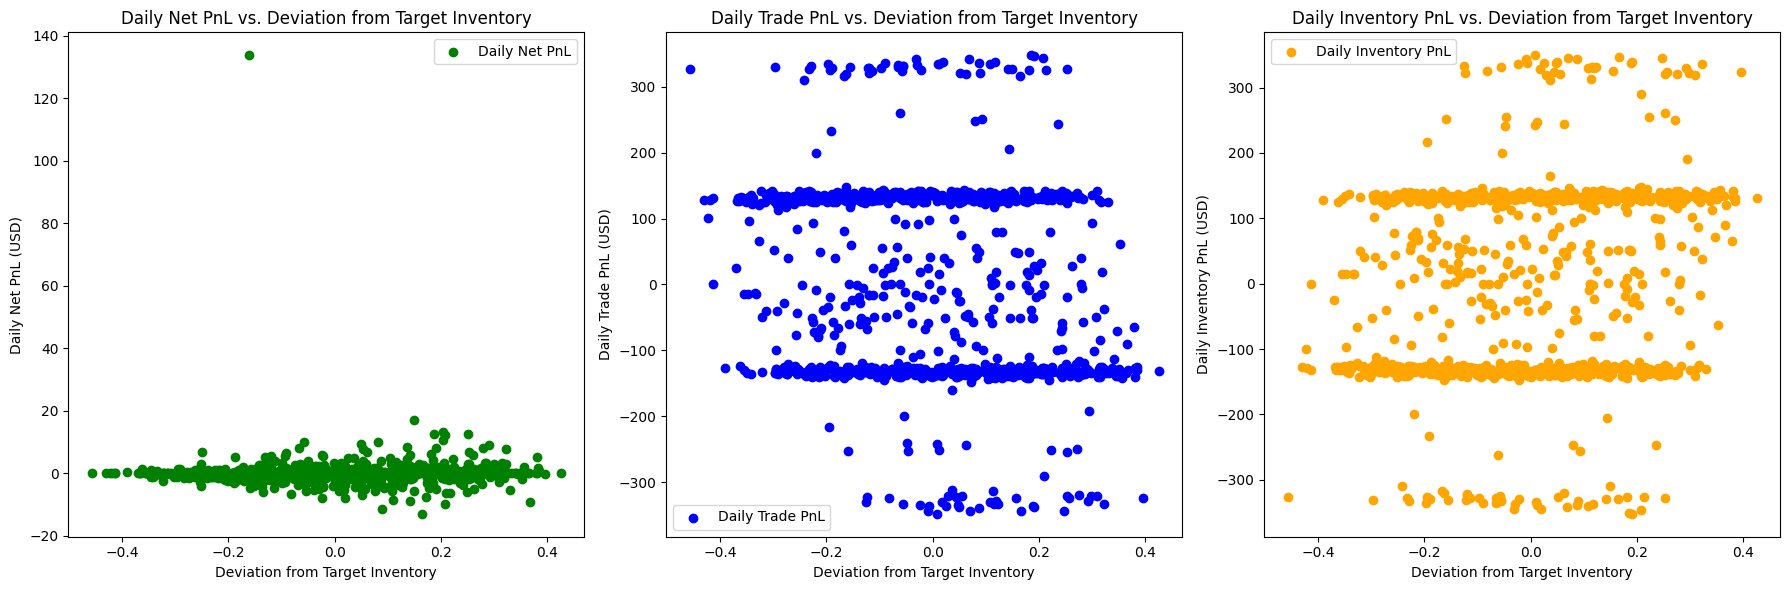

Spearman Correlation - Net PnL: Correlation=0.06907218276817076, P-value=0.020619581243518786
Spearman Correlation - Trade PnL: Correlation=-0.1866928699001399, P-value=2.884840462763195e-10
Spearman Correlation - Inventory PnL: Correlation=0.1925225276128721, P-value=7.747419089121426e-11


In [50]:
target_inventory = (lower_bound_balance + upper_bound_balance) / 2
df['deviation_from_target'] = df['balance'] - target_inventory # I do not calculate the absolute value because perhaps the direction of the deviation might be influential

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Scatter Plot 1: Daily Net PnL vs. Deviation from Target Inventory
axs[0].scatter(df['deviation_from_target'], df['net_pnl'], color='green', label='Daily Net PnL')
axs[0].set_title('Daily Net PnL vs. Deviation from Target Inventory')
axs[0].set_xlabel('Deviation from Target Inventory')
axs[0].set_ylabel('Daily Net PnL (USD)')
axs[0].legend()

# Scatter Plot 2: Daily Trade PnL vs. Deviation from Target Inventory
axs[1].scatter(df['deviation_from_target'], df['trade_pnl'], color='blue', label='Daily Trade PnL')
axs[1].set_title('Daily Trade PnL vs. Deviation from Target Inventory')
axs[1].set_xlabel('Deviation from Target Inventory')
axs[1].set_ylabel('Daily Trade PnL (USD)')
axs[1].legend()

# Scatter Plot 3: Daily Inventory PnL vs. Deviation from Target Inventory
axs[2].scatter(df['deviation_from_target'], df['inventory_pnl'], color='orange', label='Daily Inventory PnL')
axs[2].set_title('Daily Inventory PnL vs. Deviation from Target Inventory')
axs[2].set_xlabel('Deviation from Target Inventory')
axs[2].set_ylabel('Daily Inventory PnL (USD)')
axs[2].legend()

fig.tight_layout()
plt.show()

correlation_net_pnl, p_value_net_pnl = stats.spearmanr(df['deviation_from_target'], df['net_pnl'])
correlation_trade_pnl, p_value_trade_pnl = stats.spearmanr(df['deviation_from_target'], df['trade_pnl'])
correlation_inventory_pnl, p_value_inventory_pnl = stats.spearmanr(df['deviation_from_target'], df['inventory_pnl'])

print(f"Spearman Correlation - Net PnL: Correlation={correlation_net_pnl}, P-value={p_value_net_pnl}")
print(f"Spearman Correlation - Trade PnL: Correlation={correlation_trade_pnl}, P-value={p_value_trade_pnl}")
print(f"Spearman Correlation - Inventory PnL: Correlation={correlation_inventory_pnl}, P-value={p_value_inventory_pnl}")

From the plot, we can see that the net PnL, trade PnL, and inventory PnL have a statistically significant relationship with the deviation from the target inventory. This makes sense as we are told the strategy market makes around a target inventory. However, the correlation with net PnL is weak, which is a good sign as we would not want a strategy whose PnL is highly sensitive to one particular factor.

In [51]:
outlier = df[df['net_pnl'] > 120] # Identifying the outlier
outlier 

order_id side  fill_prc  fill_qty  \
timestamp                                                              
2023-07-01 00:46:05.617580  670003026938216    S   1937.83     0.069   

                           liquidity  fee fee_ccy  fee_ccy_usd_rate  \
timestamp                                                             
2023-07-01 00:46:05.617580     Maker  0.0     bnb        237.395823   

                                        fill_id  symbol_x  ...  ask_prc  \
timestamp                                                  ...            
2023-07-01 00:46:05.617580  1688172365615000000  eth_usdc  ...  1937.95   

                                    symbol_y  trade_pnl  cumulative_trade_pnl  \
timestamp                                                                       
2023-07-01 00:46:05.617580  binance_eth_usdt  133.71027             133.71027   

                           balance_value  inventory_pnl  \
timestamp                                                 
2023-07-01 00:46:05.617580     727.69647            0.0   

                            cumulative_inventory_pnl    net_pnl  \
timestamp                                                         
2023-07-01 00:46:05.617580                       0.0  133.71027   

                            cumulative_net_pnl  deviation_from_target  
timestamp                                                              
2023-07-01 00:46:05.617580           133.71027              -0.161802  

[1 rows x 23 columns]

This entry is the first entry in the dataset. It is an outlier because it is the first trade, and it is a sell. Therefore, the pnl during the first trading day is a large, strictly positive value, resulting in the outlier.

#### Segmenting PnL by Deviation from Mean Market Price

In this section, I will investigate if the PnL of the strategy is affected by the deviation from the mean market price. I will estimate the mean market price and then plot the PnL against the deviation from the mean market price.

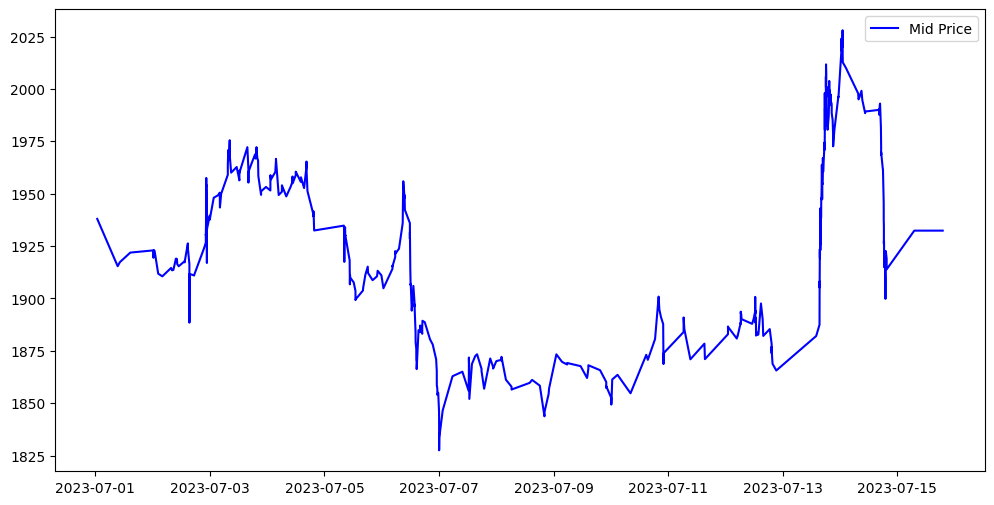

In [52]:
df = merged_data.copy()

df['mid_prc'] = (df['bid_prc'] + df['ask_prc']) / 2
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['mid_prc'], label='Mid Price', color='blue')
plt.xlabel = 'Time'
plt.ylabel = 'Mid Price'
plt.title = 'Mid Price Over Time'
plt.legend()
plt.show()

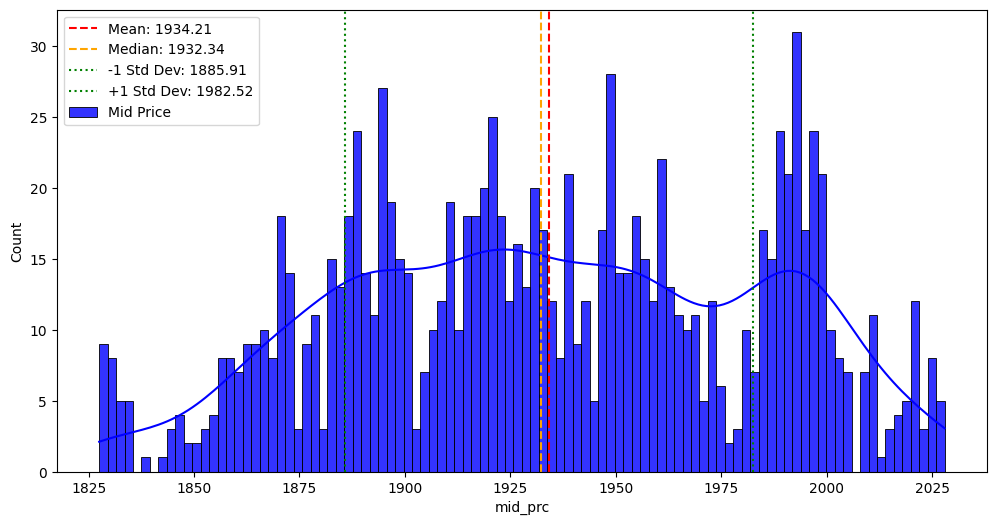

Shapiro-Wilk Test for mid_prc:
Statistics=0.977, p=0.000


In [53]:
plt.figure(figsize=(12, 6))
sns.histplot(df['mid_prc'], bins=100, kde=True, color='blue', alpha=0.8, label='Mid Price')

mean_mid_prc = df['mid_prc'].mean()
median_mid_prc = df['mid_prc'].median()
std_mid_prc = df['mid_prc'].std()

plt.axvline(mean_mid_prc, color='red', linestyle='--', label=f'Mean: {mean_mid_prc:.2f}')
plt.axvline(median_mid_prc, color='orange', linestyle='--', label=f'Median: {median_mid_prc:.2f}')
plt.axvline(mean_mid_prc - std_mid_prc, color='green', linestyle=':', label=f'-1 Std Dev: {mean_mid_prc - std_mid_prc:.2f}')
plt.axvline(mean_mid_prc + std_mid_prc, color='green', linestyle=':', label=f'+1 Std Dev: {mean_mid_prc + std_mid_prc:.2f}')

plt.legend()
plt.title = 'Distribution of Mid Price'
plt.xlabel = 'Mid Price'
plt.ylabel = 'Frequency'
plt.show()

stat, p = shapiro(df['mid_prc'])
print("Shapiro-Wilk Test for mid_prc:")
print(f"Statistics={stat:.3f}, p={p:.3f}")

Note that the distribution is not normal. I will use CLT to estimate the mean market price. This is because I also want to see the confidence interval of the mean market price.

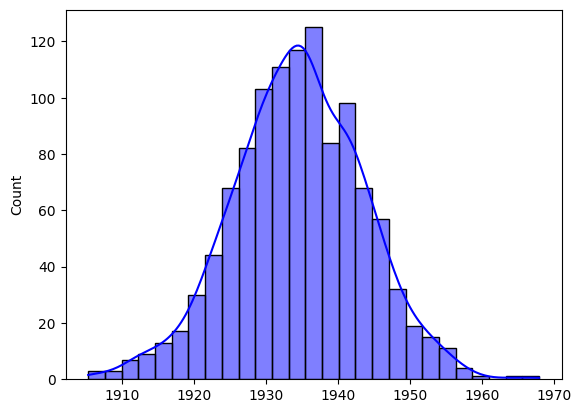

Shapiro-Wilk Test for balance:
Statistics=0.998, p=0.414


In [54]:
n_samples = 1123  # Number of samples to take
sample_size = 30  # Size of each sample

sample_means = [df['mid_prc'].sample(sample_size).mean() for _ in range(n_samples)]

sns.histplot(sample_means, kde=True, color='blue')
plt.title = 'Distribution of Sample Means (Fill Price)'
plt.xlabel = 'Sample Means of Fill Price'
plt.ylabel = 'Frequency'
plt.show()

stat, p = shapiro(sample_means)

print("Shapiro-Wilk Test for balance:")
print(f"Statistics={stat:.3f}, p={p:.3f}")
# Indeed our sample means is normal as our p-value is greater than 0.05 for the Shapiro-Wilk test.

In [55]:
mean_of_sample_means = np.mean(sample_means)
std_of_sample_means = np.std(sample_means)

# Calculate the 95% confidence interval for the mean balance
z_score = 1.96  # Z-score for 95% confidence
margin_of_error = z_score * (std_of_sample_means / np.sqrt(n_samples))

lower_bound_mid_prc = mean_of_sample_means - margin_of_error
upper_bound_mid_prc = mean_of_sample_means + margin_of_error

print(f"95% confidence interval for the fill price: {lower_bound_mid_prc:.2f} to {upper_bound_mid_prc:.2f}")

95% confidence interval for the fill price: 1933.93 to 1934.99


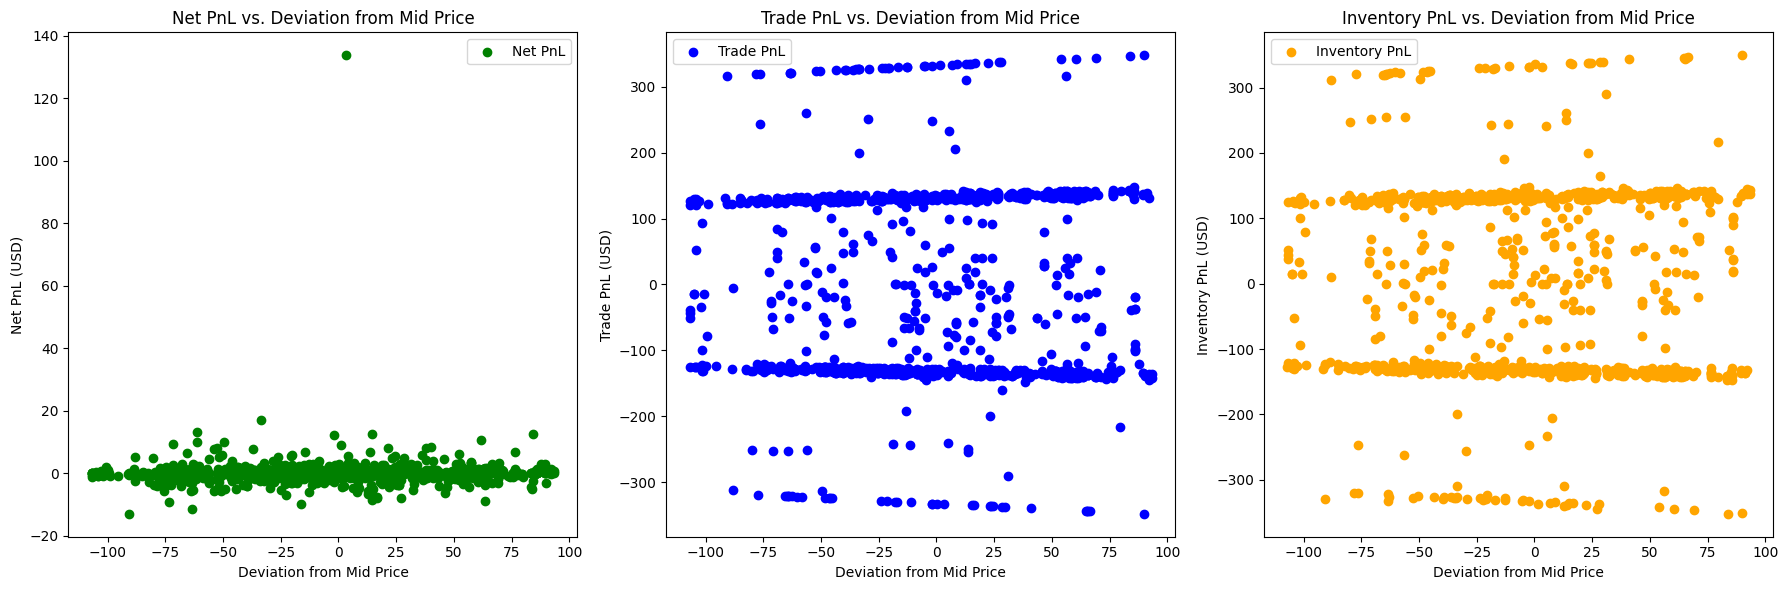

Spearman Correlation - Net PnL: Correlation=0.07145633920378337, P-value=0.01662116533175156
Spearman Correlation - Trade PnL: Correlation=0.028075195167534164, P-value=0.3472325526673893
Spearman Correlation - Inventory PnL: Correlation=-0.0232100567916356, P-value=0.4371380357803356


In [56]:
mean_mid_prc = (lower_bound_mid_prc + upper_bound_mid_prc) / 2
df['deviation_from_mid_price'] = df['mid_prc'] - mean_mid_prc

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Scatter Plot 1: Net PnL vs. Deviation from Mid Price
axs[0].scatter(df['deviation_from_mid_price'], df['net_pnl'], color='green', label='Net PnL')
axs[0].set_title('Net PnL vs. Deviation from Mid Price')
axs[0].set_xlabel('Deviation from Mid Price')
axs[0].set_ylabel('Net PnL (USD)')
axs[0].legend()

# Scatter Plot 2: Trade PnL vs. Deviation from Mid Price
axs[1].scatter(df['deviation_from_mid_price'], df['trade_pnl'], color='blue', label='Trade PnL')
axs[1].set_title('Trade PnL vs. Deviation from Mid Price')
axs[1].set_xlabel('Deviation from Mid Price')
axs[1].set_ylabel('Trade PnL (USD)')
axs[1].legend()

# Scatter Plot 3: Inventory PnL vs. Deviation from Mid Price
axs[2].scatter(df['deviation_from_mid_price'], df['inventory_pnl'], color='orange', label='Inventory PnL')
axs[2].set_title('Inventory PnL vs. Deviation from Mid Price')
axs[2].set_xlabel('Deviation from Mid Price')
axs[2].set_ylabel('Inventory PnL (USD)')
axs[2].legend()

fig.tight_layout()
plt.show()

correlation_net_pnl, p_value_net_pnl = stats.spearmanr(df['deviation_from_mid_price'], df['net_pnl'])
correlation_trade_pnl, p_value_trade_pnl = stats.spearmanr(df['deviation_from_mid_price'], df['trade_pnl'])
correlation_inventory_pnl, p_value_inventory_pnl = stats.spearmanr(df['deviation_from_mid_price'], df['inventory_pnl'])

print(f"Spearman Correlation - Net PnL: Correlation={correlation_net_pnl}, P-value={p_value_net_pnl}")
print(f"Spearman Correlation - Trade PnL: Correlation={correlation_trade_pnl}, P-value={p_value_trade_pnl}")
print(f"Spearman Correlation - Inventory PnL: Correlation={correlation_inventory_pnl}, P-value={p_value_inventory_pnl}")

Here, we observe that the net PnL of the strategy is statistically significant from the deviation from the mean market price. However, trade PnL and inventory PnL are not. Furthermore, the correlation between net PnL and deviation from the mean market price, while statistically significant, is very weak. 

A possible explanation for the lack of a significant correlation between trade PnL and market price deviation could be that the strategy's trading profits or losses might be derived more from the execution quality, trading timing, or arbitrage opportunities that are not directly tied to broad market price movements. This could indicate a strategy effectively capturing profits in various market conditions without direct dependence on the direction of market price movements.

Furthermore, inventory PnL's lack of significant correlation with market price deviation might seem counterintuitive since inventory values are directly impacted by market prices. However, this can be explained by the fact that inventory PnL reflects only the change in valuation of the held inventory, which might not directly correlate with short-term market price deviations due to the strategy's hedging, timing of trades, or diversification approaches that mitigate direct market impacts.

Meanwhile, net PnL captures the combined effects of both trading performance and inventory valuation changes, making it more sensitive to market price deviations. This sensitivity could explain why net PnL shows a significant correlation with market price deviations, albeit a weak one

#### Segmenting PnL by Post-Fill Price Difference

In this section, I want to investigate if the PnL of the strategy is affected by the difference between the price at which the order is filled and the respective bid/ask price if we are buying/selling. I want to investigate post-fill price difference because it is a good indicator of more favorable buy or sell conditions compared to the bid/ask price. If the post-fill price difference is positive, then the order was filled at a better price than the bid/ask price. If the post-fill price difference is negative, then the order was filled at a worse price than the bid/ask price.

In [57]:
def calculate_price_difference(row):
    if row['side'] == 'B':
        return row['ask_prc'] - row['fill_prc']  # positive if buy below the asking price.
    elif row['side'] == 'S':
        return row['fill_prc'] - row['bid_prc']  # positive if sell above the bid price.

In [58]:
df = merged_data.copy()
df['price_difference'] = df.apply(calculate_price_difference, axis=1)
df['price_difference'].describe()

count    1123.000000
mean        0.382511
std         1.265957
min        -3.930000
25%        -0.290000
50%         0.360000
75%         0.970000
max        12.640000
Name: price_difference, dtype: float64

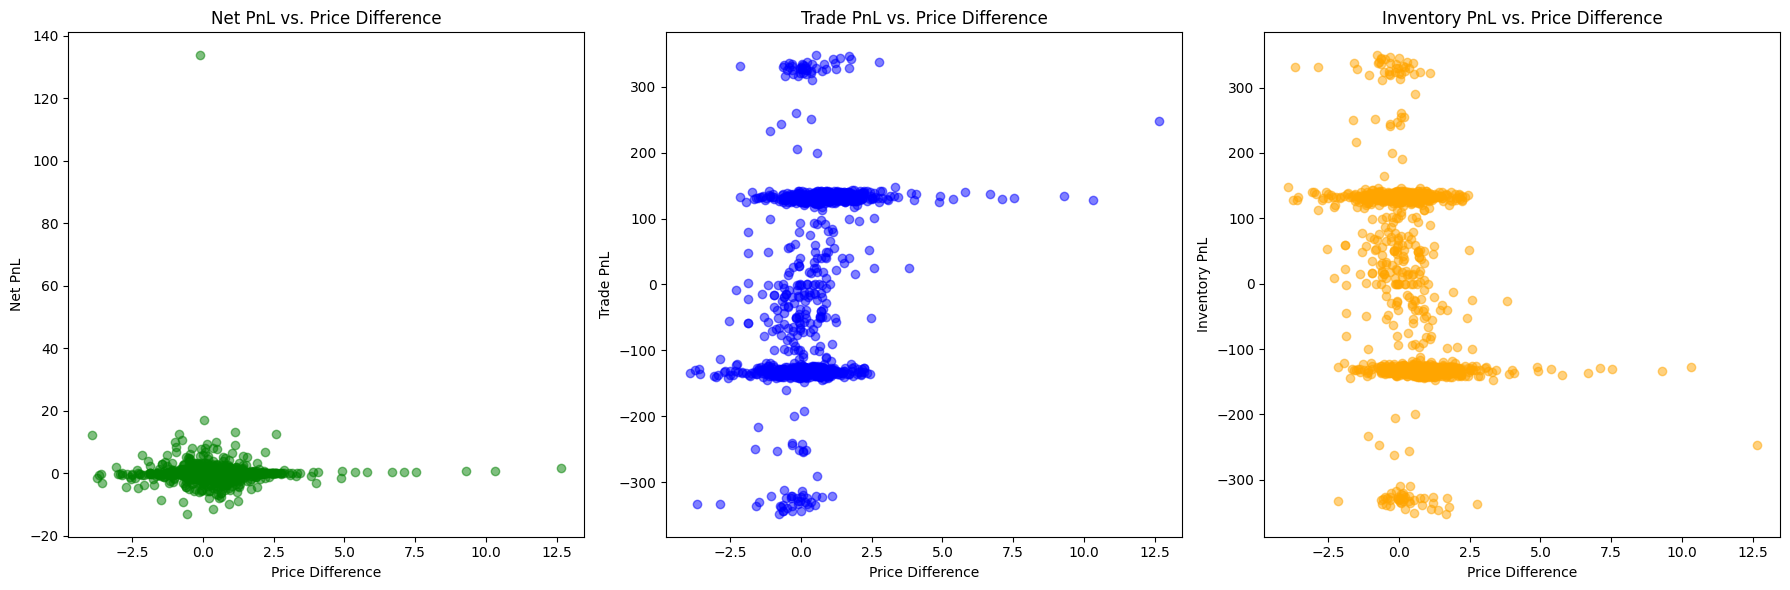

Net PnL vs. Price Difference: Correlation Coefficient = -0.014169414466543044, P-value = 0.6352653300238198
Trade PnL vs. Price Difference: Correlation Coefficient = 0.3117067694184602, P-value = 9.984391886699616e-27
Inventory PnL vs. Price Difference: Correlation Coefficient = -0.3114720432598224, P-value = 1.0941544536495787e-26


In [59]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

axs[0].scatter(df['price_difference'], df['net_pnl'], alpha=0.5, color='green')
axs[0].set_title('Net PnL vs. Price Difference')
axs[0].set_xlabel('Price Difference')
axs[0].set_ylabel('Net PnL')

axs[1].scatter(df['price_difference'], df['trade_pnl'], alpha=0.5, color='blue')
axs[1].set_title('Trade PnL vs. Price Difference')
axs[1].set_xlabel('Price Difference')
axs[1].set_ylabel('Trade PnL')

axs[2].scatter(df['price_difference'], df['inventory_pnl'], alpha=0.5, color='orange')
axs[2].set_title('Inventory PnL vs. Price Difference')
axs[2].set_xlabel('Price Difference')
axs[2].set_ylabel('Inventory PnL')

plt.tight_layout()
plt.show()

corr_coef_net_pnl, p_value_net_pnl = pearsonr(df['price_difference'], df['net_pnl'])
print(f"Net PnL vs. Price Difference: Correlation Coefficient = {corr_coef_net_pnl}, P-value = {p_value_net_pnl}")
corr_coef_trade_pnl, p_value_trade_pnl = pearsonr(df['price_difference'], df['trade_pnl'])
print(f"Trade PnL vs. Price Difference: Correlation Coefficient = {corr_coef_trade_pnl}, P-value = {p_value_trade_pnl}")
corr_coef_inventory_pnl, p_value_inventory_pnl = pearsonr(df['price_difference'], df['inventory_pnl'])
print(f"Inventory PnL vs. Price Difference: Correlation Coefficient = {corr_coef_inventory_pnl}, P-value = {p_value_inventory_pnl}")


The results show that trade PnL and price difference have a positive and statisstically significant correlation. This result is intuitive because executing buys below the asking price or sells above the bid price directly translates to better immediate profit margins on trades. The strategy effectively capitalizes on favorable trading conditions, leading to higher trade profitability.

Meanwhile, inventory PnL has a negative and statistically significant correlation, indicating an inverse relationship between price difference and inventory PnL. This could imply that when trades are executed more favorably relative to the bid/ask price, it might lead to holding inventory that decreases in value, possibly because the market moves against the position after the fill. This scenario can occur in volatile markets where rapid price movements make the valuation of held inventory less favorable, despite initial favorable trade executions.

But as a whole, the net PnL shows a lack of statistical significance and the very weak correlation coefficient, which suggests no meaningful relationship between net PnL and price difference for filled orders. This outcome might indicate that the overall performance of the strategy, encompassing both realized and unrealized gains/losses, is resilient to the immediate price differences achieved at order fills. The net effect of trading performance and inventory valuation on overall profitability may balance out, or other factors not captured by price difference (such as overall market conditions, strategy execution timing, and risk management practices) might play a more critical role in determining net PnL.


#### Segementing PnL by Fill Value

In this section, I want to investigate if the PnL of the strategy is affected by the trade size. I will calculate the fill value and then plot the PnL against the fill value.

In [60]:
df = merged_data.copy()
df['fill_value'] = df['fill_qty'] * df['fill_prc']

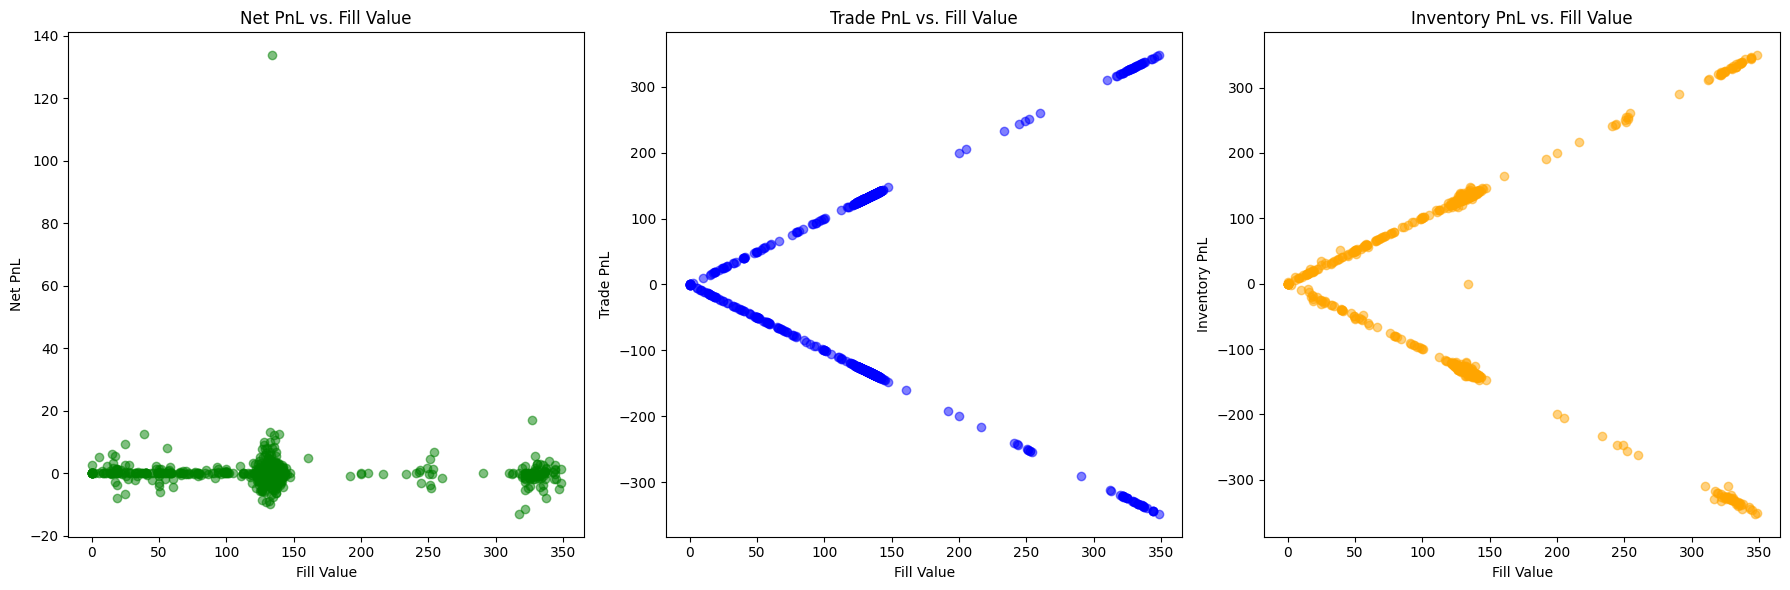

In [61]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

axs[0].scatter(df['fill_value'], df['net_pnl'], alpha=0.5, color='green')
axs[0].set_title('Net PnL vs. Fill Value')
axs[0].set_xlabel('Fill Value')
axs[0].set_ylabel('Net PnL')

axs[1].scatter(df['fill_value'], df['trade_pnl'], alpha=0.5, color='blue')
axs[1].set_title('Trade PnL vs. Fill Value')
axs[1].set_xlabel('Fill Value')
axs[1].set_ylabel('Trade PnL')

axs[2].scatter(df['fill_value'], df['inventory_pnl'], alpha=0.5, color='orange')
axs[2].set_title('Inventory PnL vs. Fill Value')
axs[2].set_xlabel('Fill Value')
axs[2].set_ylabel('Inventory PnL')

plt.tight_layout()
plt.show()


In [62]:
# Let me further segment the data by buys and sells to obtain a more informative plot
buys = df[df['side'] == 'B']
sells = df[df['side'] == 'S']

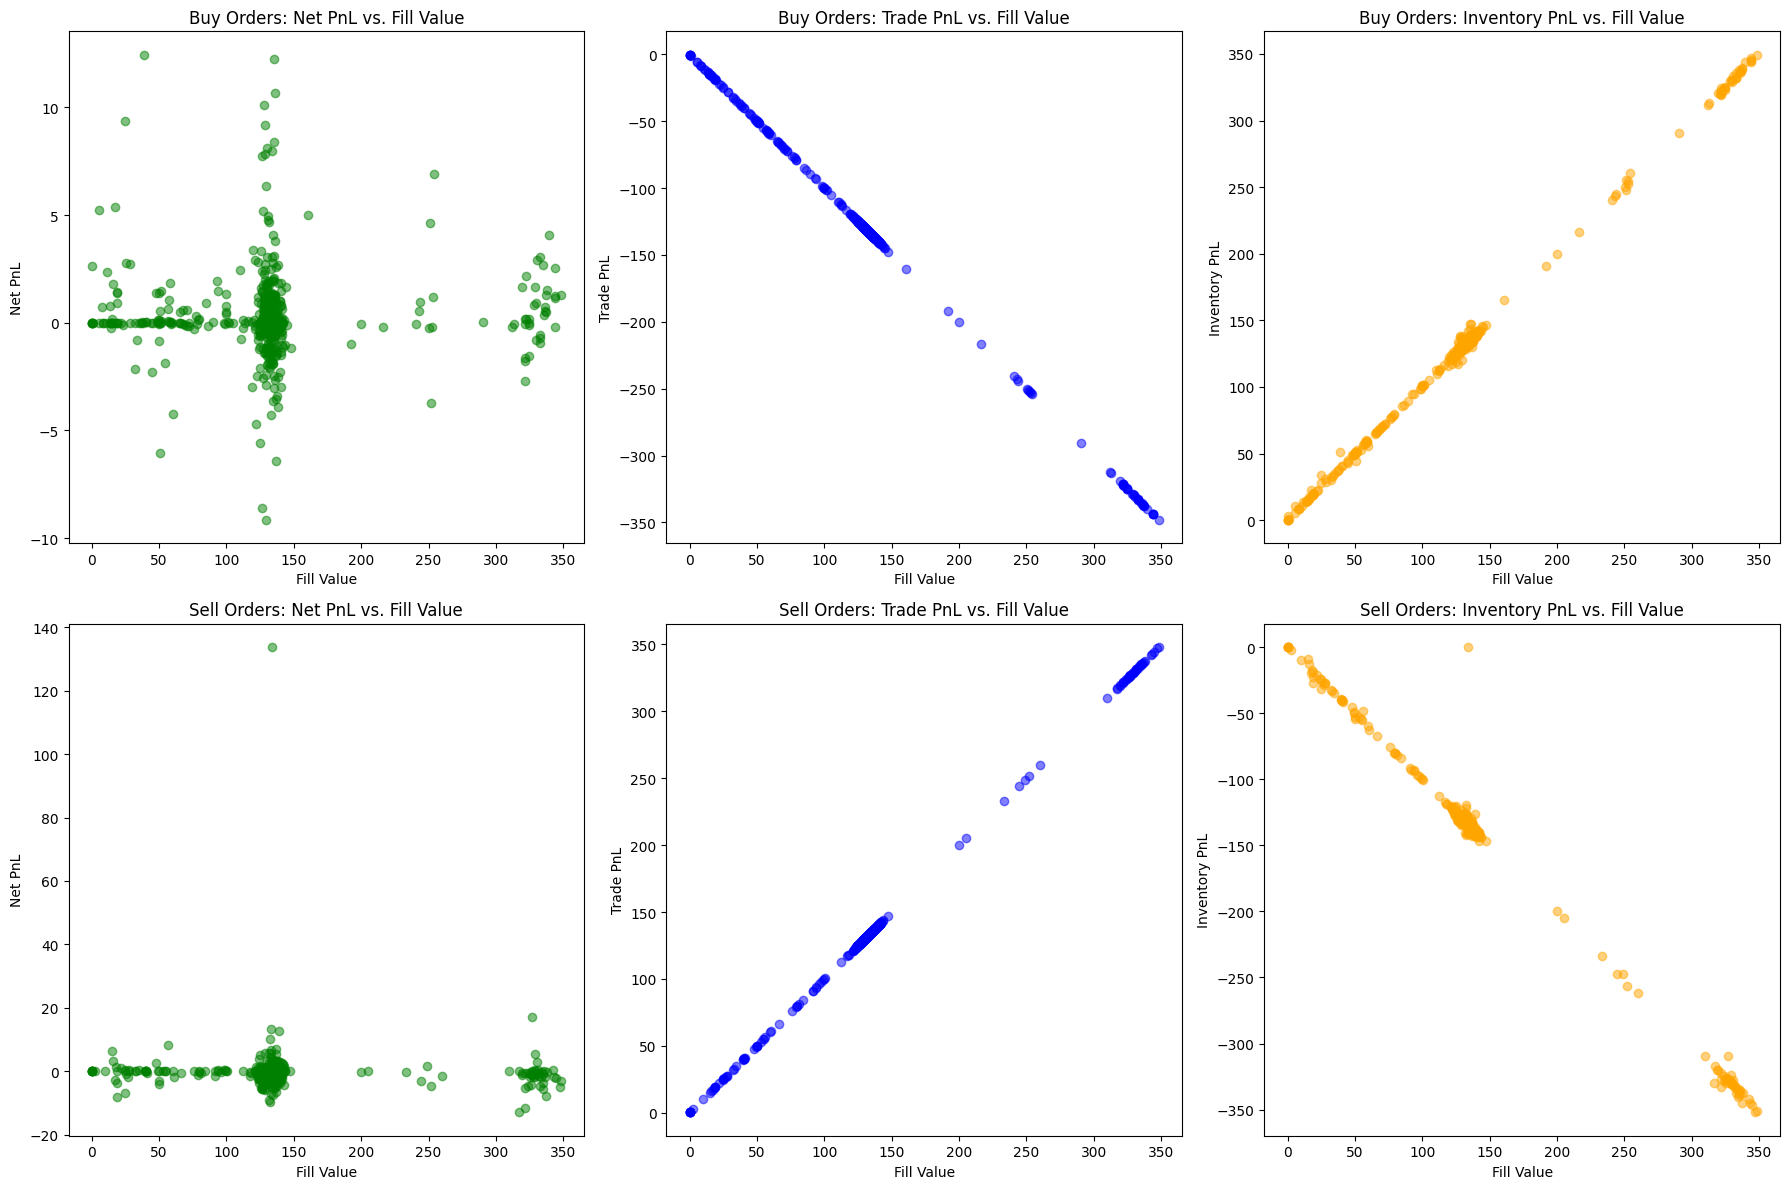

In [63]:
fig, axs = plt.subplots(2, 3, figsize=(18, 12))

axs[0, 0].scatter(buys['fill_value'], buys['net_pnl'], alpha=0.5, color='green')
axs[0, 0].set_title('Buy Orders: Net PnL vs. Fill Value')
axs[0, 0].set_xlabel('Fill Value')
axs[0, 0].set_ylabel('Net PnL')

axs[0, 1].scatter(buys['fill_value'], buys['trade_pnl'], alpha=0.5, color='blue')
axs[0, 1].set_title('Buy Orders: Trade PnL vs. Fill Value')
axs[0, 1].set_xlabel('Fill Value')
axs[0, 1].set_ylabel('Trade PnL')

axs[0, 2].scatter(buys['fill_value'], buys['inventory_pnl'], alpha=0.5, color='orange')
axs[0, 2].set_title('Buy Orders: Inventory PnL vs. Fill Value')
axs[0, 2].set_xlabel('Fill Value')
axs[0, 2].set_ylabel('Inventory PnL')

axs[1, 0].scatter(sells['fill_value'], sells['net_pnl'], alpha=0.5, color='green')
axs[1, 0].set_title('Sell Orders: Net PnL vs. Fill Value')
axs[1, 0].set_xlabel('Fill Value')
axs[1, 0].set_ylabel('Net PnL')

axs[1, 1].scatter(sells['fill_value'], sells['trade_pnl'], alpha=0.5, color='blue')
axs[1, 1].set_title('Sell Orders: Trade PnL vs. Fill Value')
axs[1, 1].set_xlabel('Fill Value')
axs[1, 1].set_ylabel('Trade PnL')

axs[1, 2].scatter(sells['fill_value'], sells['inventory_pnl'], alpha=0.5, color='orange')
axs[1, 2].set_title('Sell Orders: Inventory PnL vs. Fill Value')
axs[1, 2].set_xlabel('Fill Value')
axs[1, 2].set_ylabel('Inventory PnL')

plt.tight_layout()
plt.show()

In [64]:
# Buying
corr_coef_buy_net, p_value_buy_net = pearsonr(buys['fill_value'], buys['net_pnl'])
print(f"Buying - Net PnL vs. Fill Value: Correlation Coefficient = {corr_coef_buy_net}, P-value = {p_value_buy_net}")
corr_coef_buy_trade, p_value_buy_trade = pearsonr(buys['fill_value'], buys['trade_pnl'])
print(f"Buying - Trade PnL vs. Fill Value: Correlation Coefficient = {corr_coef_buy_trade}, P-value = {p_value_buy_trade}")
corr_coef_buy_inventory, p_value_buy_inventory = pearsonr(buys['fill_value'], buys['inventory_pnl'])
print(f"Buying - Inventory PnL vs. Fill Value: Correlation Coefficient = {corr_coef_buy_inventory}, P-value = {p_value_buy_inventory}")

# Selling
corr_coef_sell_net, p_value_sell_net = pearsonr(sells['fill_value'], sells['net_pnl'])
print(f"Selling - Net PnL vs. Fill Value: Correlation Coefficient = {corr_coef_sell_net}, P-value = {p_value_sell_net}")
corr_coef_sell_trade, p_value_sell_trade = pearsonr(sells['fill_value'], sells['trade_pnl'])
print(f"Selling - Trade PnL vs. Fill Value: Correlation Coefficient = {corr_coef_sell_trade}, P-value = {p_value_sell_trade}")
corr_coef_sell_inventory, p_value_sell_inventory = pearsonr(sells['fill_value'], sells['inventory_pnl'])
print(f"Selling - Inventory PnL vs. Fill Value: Correlation Coefficient = {corr_coef_sell_inventory}, P-value = {p_value_sell_inventory}")

Buying - Net PnL vs. Fill Value: Correlation Coefficient = 0.006231685977645554, P-value = 0.8809566834684721
Buying - Trade PnL vs. Fill Value: Correlation Coefficient = -0.9999999836710824, P-value = 0.0
Buying - Inventory PnL vs. Fill Value: Correlation Coefficient = 0.9995404667011665, P-value = 0.0
Selling - Net PnL vs. Fill Value: Correlation Coefficient = -0.05283348940444591, P-value = 0.21900939556150936
Selling - Trade PnL vs. Fill Value: Correlation Coefficient = 0.9999999831275445, P-value = 0.0
Selling - Inventory PnL vs. Fill Value: Correlation Coefficient = -0.9954918195112797, P-value = 0.0


Here, the results are very interesting because in both buying and selling, trade pnl and inventory pnl have a near perfect linear relationship with fill value. The negative correlation in trade pnl for buying suggests that as fill value increases, trade PnL decreases, which could be a result of data interpretation or a specific anomaly in the buying data set. The positive correlation for selling indicates that as fill value increases, so does trade PnL. Essentially, this implies that the profitability of individual trades directly scales with the value of the asset being traded. This outcome is expected since fill value reflects the monetary size of the trade, and thus, larger trades inherently have a greater impact on trade PnL. Meanwhile, for inventory PnL, buying at a high fill value correlates with increased inventory PnL, possibly reflecting the accumulation of valuable assets that appreciate. Conversely, selling at a high fill value correlates with a decrease in inventory PnL, perhaps indicating the liquidation of assets at less favorable prices. These strong correlations are somewhat intuitive, as larger transactions have a more pronounced impact on the valuation of inventory held by the strategy.

However, with net PnL, the lack of statistical significance and the very weak correlation coefficients for both buying and selling suggest that net PnL is largely independent of the fill value of trades. This indicates that the overall profitability of the strategy is not directly impacted by the size of individual orders. It's a positive indication of the strategy's robustness, as it suggests that the strategy can maintain its performance irrespective of order size, potentially through effective risk management and a balanced portfolio approach.

### Multi-Linear Regression

In this section, I aim to construct a multi-linear regression model to indentify the factors that are significant to the PnL of the strategy. The goal of this multi-linear regression is not to formulate an accurate predictive model for PnL, but to identify the factors that are statistically significant to the PnL and see if the results converge with our analysis. Furthermore, I wil use the multi-linear regression model to rank which features are the most correlated with PnL. 

To accomplish my goal, I will:
1. Perform some feature engineering on my dataset to ensure it is compatible with multi-linear regression.
2. Comapre the results of multi-linear regression using OLS, Lassso (L1 Regularization), and Ridge (L2 Regularization) to check for consistency in the results.

Note that since my goal is to identify and investigate the factors that are significant to the PnL, I will formulate my multi-linear regression model to predict for `net_pnl`. If I wanted a more accurate predictive model, I would construct two multi-linear regression models, one for `trade_pnl` and oen for `inventory_pnl`, and then sum the predictions to get my predicted `net_pnl`.

In [65]:
df = merged_data.copy()

# Necessary for categorizing momentum
df['mid_prc'] = (df['bid_prc'] + df['ask_prc']) / 2
df['mid_prc_pct_change'] = df['mid_prc'].pct_change()

# From the previous analysis, we found that momentum, deviation from target inventory, deviation from mid price has a statistical significant impact on net pnl
df['momentum_condition'] = df.apply(categorize_momentum_condition, axis=1)
df['deviation_from_target'] = df['balance'] - target_inventory
df['deviation_from_mid_price'] = df['mid_prc'] - mean_mid_prc

# Some other features we may want to explore 
df['fill_qty_pct_change'] = df['fill_qty'].pct_change()
df['fill_prc_pct_change'] = df['fill_prc'].pct_change()
df['day'] = df.index.day # Add day, which is days since inception of trading, to see if time has an impact on pnl

df

order_id side  fill_prc  fill_qty  \
timestamp                                                              
2023-07-01 00:46:05.617580  670003026938216    S   1937.83    0.0690   
2023-07-01 06:52:59.387733  670003026940777    B   1920.53    0.0264   
2023-07-01 09:19:52.809436  670003026941465    B   1914.23    0.0707   
2023-07-01 10:16:21.048157  670003026941676    B   1916.97    0.1719   
2023-07-01 14:37:25.452850  670003026943147    S   1921.43    0.1719   
...                                     ...  ...       ...       ...   
2023-07-15 16:18:25.726018  670008617129681    B   1935.21    0.1719   
2023-07-15 16:19:06.461829  670008617129719    B   1936.04    0.1719   
2023-07-15 18:39:02.613882  670008617130081    S   1939.44    0.0670   
2023-07-15 18:39:02.614281  670008617130071    S   1939.87    0.0674   
2023-07-15 19:04:52.935896  670008617130139    B   1935.97    0.0666   

                           liquidity       fee fee_ccy  fee_ccy_usd_rate  \
timestamp                                                                  
2023-07-01 00:46:05.617580     Maker  0.000000     bnb        237.395823   
2023-07-01 06:52:59.387733     Maker  0.000000     bnb        237.395823   
2023-07-01 09:19:52.809436     Maker  0.000000     bnb        237.395823   
2023-07-01 10:16:21.048157     Taker  0.000305     bnb        237.395823   
2023-07-01 14:37:25.452850     Maker  0.000000     bnb        237.395823   
...                              ...       ...     ...               ...   
2023-07-15 16:18:25.726018     Taker  0.000299     bnb        259.829225   
2023-07-15 16:19:06.461829     Taker  0.000299     bnb        259.829225   
2023-07-15 18:39:02.613882     Maker  0.000000     bnb        259.829225   
2023-07-15 18:39:02.614281     Maker  0.000000     bnb        259.829225   
2023-07-15 19:04:52.935896     Maker  0.000000     bnb        259.829225   

                                        fill_id  symbol_x  ...     net_pnl  \
timestamp                                                  ...               
2023-07-01 00:46:05.617580  1688172365615000000  eth_usdc  ...  133.710270   
2023-07-01 06:52:59.387733  1688194379383000000  eth_usdc  ...   -6.055175   
2023-07-01 09:19:52.809436  1688203192806000000  eth_usdc  ...   -2.480212   
2023-07-01 10:16:21.048157  1688206581043000000  eth_usdc  ...    0.914108   
2023-07-01 14:37:25.452850  1688222245450000000  eth_usdc  ...    2.852113   
...                                         ...       ...  ...         ...   
2023-07-15 16:18:25.726018  1689437905700000000  eth_usdc  ...   -0.571013   
2023-07-15 16:19:06.461829  1689437946423000000  eth_usdc  ...   -0.713690   
2023-07-15 18:39:02.613882  1689446342610000000  eth_usdc  ...    0.475700   
2023-07-15 18:39:02.614281  1689446342610000001  eth_usdc  ...    0.507522   
2023-07-15 19:04:52.935896  1689447892932000000  eth_usdc  ...   -0.241758   

                            cumulative_net_pnl   mid_prc  mid_prc_pct_change  \
timestamp                                                                      
2023-07-01 00:46:05.617580          133.710270  1937.945                 NaN   
2023-07-01 06:52:59.387733          127.655095  1921.735           -0.008365   
2023-07-01 09:19:52.809436          125.174883  1915.365           -0.003315   
2023-07-01 10:16:21.048157          126.088991  1917.325            0.001023   
2023-07-01 14:37:25.452850          128.941104  1921.865            0.002368   
...                                        ...       ...                 ...   
2023-07-15 16:18:25.726018          144.768903  1932.345            0.000000   
2023-07-15 16:19:06.461829          144.055212  1932.345            0.000000   
2023-07-15 18:39:02.613882          144.530912  1932.345            0.000000   
2023-07-15 18:39:02.614281          145.038434  1932.345            0.000000   
2023-07-15 19:04:52.935896          144.796676  1932.345            0.000000   

                           momentum_condition  deviat

In [66]:
# Like we saw earlier, the first row is an outlier. We will remove it from the dataset
df = df.iloc[1:]

In [67]:
# Let's remove the features that are not meaningful to our analysis
df.drop(['order_id', 'fill_id', 'fee_ccy', 'symbol_x', 'exch', 'symbol_y'], axis=1, inplace=True)

In [68]:
# On a further note, since we are modelling net pnl, we do not need cumulative pnl features. This is because including them in the model would lead to data leakage.
df.drop(['cumulative_trade_pnl', 'cumulative_inventory_pnl', 'cumulative_net_pnl'], axis=1, inplace=True)

First, I want to check for multi-colinearity in my dataset.

In [69]:
# Let me identify the quantitative and categorical features in the training data
numerical_features = [feature for feature in df.columns if df[feature].dtype != 'O']
categorical_features = [feature for feature in df.columns if df[feature].dtype == 'O']

assert len(numerical_features) + len(categorical_features) == df.shape[1]

print(f"Numerical Features: {numerical_features}")
print(f"Categorical Features: {categorical_features}")

for feature in categorical_features:
    print(f"Unique values for {feature}: {df[feature].unique()}")

Numerical Features: ['fill_prc', 'fill_qty', 'fee', 'fee_ccy_usd_rate', 'balance', 'bid_prc', 'ask_prc', 'trade_pnl', 'balance_value', 'inventory_pnl', 'net_pnl', 'mid_prc', 'mid_prc_pct_change', 'deviation_from_target', 'deviation_from_mid_price', 'fill_qty_pct_change', 'fill_prc_pct_change', 'day']
Categorical Features: ['side', 'liquidity', 'momentum_condition']
Unique values for side: ['B' 'S']
Unique values for liquidity: ['Maker' 'Taker']
Unique values for momentum_condition: ['Bear' 'Bull' 'Neutral']


In [70]:
# I need this to investigate whether I should use a dummy variable or ordinal relationship for my market conditoon feature
states = ['Bull', 'Bear', 'Neutral']
momentum_condition_matrix = pd.DataFrame(0, index=states, columns=states, dtype=float)

for (current_state, next_state) in zip(df['momentum_condition'][:-1], df['momentum_condition'][1:]):
    momentum_condition_matrix.at[current_state, next_state] += 1

momentum_condition_matrix = momentum_condition_matrix.div(momentum_condition_matrix.sum(axis=1), axis=0)
momentum_condition_matrix

Bull      Bear   Neutral
Bull     0.283019  0.226415  0.490566
Bear     0.242754  0.336957  0.420290
Neutral  0.212069  0.210345  0.577586

In [71]:
# Encode the categorical features
df_encoded = pd.get_dummies(df, columns=['side', 'liquidity', 'momentum_condition'])
# Use one hot encoding for momentums since matrix shows that there is no ordinal relationship between the states
df_encoded

fill_prc  fill_qty       fee  fee_ccy_usd_rate  \
timestamp                                                                    
2023-07-01 06:52:59.387733   1920.53    0.0264  0.000000        237.395823   
2023-07-01 09:19:52.809436   1914.23    0.0707  0.000000        237.395823   
2023-07-01 10:16:21.048157   1916.97    0.1719  0.000305        237.395823   
2023-07-01 14:37:25.452850   1921.43    0.1719  0.000000        237.395823   
2023-07-02 00:15:18.613260   1922.02    0.0693  0.000000        237.395823   
...                              ...       ...       ...               ...   
2023-07-15 16:18:25.726018   1935.21    0.1719  0.000299        259.829225   
2023-07-15 16:19:06.461829   1936.04    0.1719  0.000299        259.829225   
2023-07-15 18:39:02.613882   1939.44    0.0670  0.000000        259.829225   
2023-07-15 18:39:02.614281   1939.87    0.0674  0.000000        259.829225   
2023-07-15 19:04:52.935896   1935.97    0.0666  0.000000        259.829225   

                            balance  bid_prc  ask_prc   trade_pnl  \
timestamp                                                           
2023-07-01 06:52:59.387733   0.4019  1921.73  1921.74  -50.701992   
2023-07-01 09:19:52.809436   0.4726  1915.36  1915.37 -135.336061   
2023-07-01 10:16:21.048157   0.6445  1917.32  1917.33 -329.599496   
2023-07-01 14:37:25.452850   0.4726  1921.86  1921.87  330.293817   
2023-07-02 00:15:18.613260   0.5419  1922.91  1922.92 -133.195986   
...                             ...      ...      ...         ...   
2023-07-15 16:18:25.726018   0.4808  1932.34  1932.35 -332.740259   
2023-07-15 16:19:06.461829   0.6527  1932.34  1932.35 -332.882936   
2023-07-15 18:39:02.613882   0.5857  1932.34  1932.35  129.942480   
2023-07-15 18:39:02.614281   0.5183  1932.34  1932.35  130.747238   
2023-07-15 19:04:52.935896   0.5849  1932.34  1932.35 -128.935602   

                            balance_value  inventory_pnl  ...  \
timestamp                                                 ...   
2023-07-01 06:52:59.387733     772.343287      44.646817  ...   
2023-07-01 09:19:52.809436     905.199136     132.855849  ...   
2023-07-01 10:16:21.048157    1235.712740     330.513604  ...   
2023-07-01 14:37:25.452850     908.271036    -327.441704  ...   
2023-07-02 00:15:18.613260    1042.024929     133.753893  ...   
...                                   ...            ...  ...   
2023-07-15 16:18:25.726018     929.069072     332.169246  ...   
2023-07-15 16:19:06.461829    1261.238318     332.169246  ...   
2023-07-15 18:39:02.613882    1131.771538    -129.466780  ...   
2023-07-15 18:39:02.614281    1001.531822    -130.239716  ...   
2023-07-15 19:04:52.935896    1130.225666     128.693844  ...   

                            fill_qty_pct_change  fill_prc_pct_change  day  \
timestamp                                                                   
2023-07-01 06:52:59.387733            -0.617391            -0.008928    1   
2023-07-01 09:19:52.809436             1.678030            -0.003280    1   
2023-07-01 10:16:21.048157             1.431400             0.001431    1   
2023-07-01 14:37:25.452850             0.000000             0.002327    1   
2023-07-02 00:15:18.613260            -0.596859             0.000307    2   
...                                         ...                  ...  ...   
2023-07-15 16:18:25.726018             0.000000             0.002606   15   
2023-07-15 16:19:06.461829             0.000000             0.000429   15   
2023-07-15 18:39:02.613882            -0.610239             0.001756   15   
2023-07-15 18:39:02.614281             0.005970             0.000222   15   
2023-07-15 19:04:52.935896            -0.011869            -0.002010   15   

                            side_B  side_S  liquidity_Maker  liquidity_Taker  \
timestamp                                                                      
2023-07-01 06:52:59.387733    True   False             True            False   
2023-07-01 09:19:52.809436 

In [72]:
# Before I proceed, I want to filter out categorical features that do not have a statistically significant relationship with net pnl

categorical_columns = ['side_B', 'side_S', 'liquidity_Maker', 'liquidity_Taker', 'momentum_condition_Bear', 'momentum_condition_Bull', 'momentum_condition_Neutral']

for col in categorical_columns:
    df_encoded[col] = df_encoded[col].astype('category').cat.codes

ordinal_relationships = {}

for column in categorical_columns:
    try:
        rho, p_value = spearmanr(df_encoded['net_pnl'], df_encoded[column])
        significance = p_value < 0.05
        ordinal_relationships[column] = {'rho': rho, 'p_value': p_value, 'significant': significance}
    except Exception as e:
        print(f"Error processing column {column}: {e}")

for column, results in ordinal_relationships.items():
    significance_msg = "significant" if results['significant'] else "no significant"
    print(f"There is {significance_msg} ordinal relationship between 'net_pnl' and '{column}' (rho = {results['rho']:.3f}, p-value = {results['p_value']:.3f})")

There is significant ordinal relationship between 'net_pnl' and 'side_B' (rho = 0.137, p-value = 0.000)
There is significant ordinal relationship between 'net_pnl' and 'side_S' (rho = -0.137, p-value = 0.000)
There is significant ordinal relationship between 'net_pnl' and 'liquidity_Maker' (rho = 0.087, p-value = 0.004)
There is significant ordinal relationship between 'net_pnl' and 'liquidity_Taker' (rho = -0.087, p-value = 0.004)
There is significant ordinal relationship between 'net_pnl' and 'momentum_condition_Bear' (rho = -0.742, p-value = 0.000)
There is significant ordinal relationship between 'net_pnl' and 'momentum_condition_Bull' (rho = 0.728, p-value = 0.000)
There is no significant ordinal relationship between 'net_pnl' and 'momentum_condition_Neutral' (rho = 0.021, p-value = 0.489)


In [73]:
# Remove `momentum_condition_Neutral` since they do not have a statistically significant relationship with net pnl
df_encoded.drop(['momentum_condition_Neutral'], axis=1, inplace=True)

<Axes: >

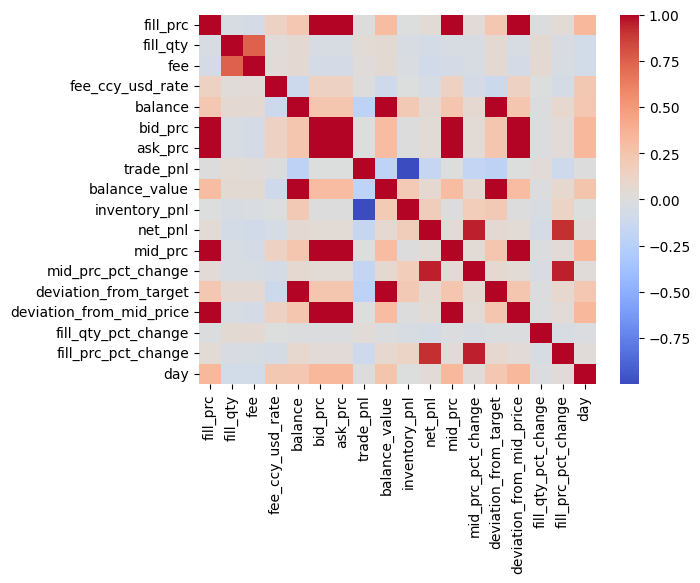

In [74]:
corr = df_encoded[numerical_features].corr()
sns.heatmap(corr, annot=False, cmap='coolwarm')

From the correlation matrix, we can see that there is multi-colinearity in our dataset. Let us investigate this further by calculating the VIF of our features.

In [75]:
features = df_encoded.drop(columns=['trade_pnl', 'inventory_pnl', 'net_pnl'])

X = features
X_with_constant = add_constant(X)

vif_df = pd.DataFrame()
vif_df["Feature"] = X.columns

vif_df["VIF"] = [variance_inflation_factor(X_with_constant.values, i) for i in range(1, X_with_constant.shape[1])]
vif_df.sort_values(by="VIF", ascending=False)

Feature          VIF
10     deviation_from_target          inf
11  deviation_from_mid_price          inf
18           liquidity_Taker          inf
17           liquidity_Maker          inf
4                    balance          inf
5                    bid_prc          inf
6                    ask_prc          inf
16                    side_S          inf
8                    mid_prc          inf
15                    side_B          inf
0                   fill_prc  2393.366604
7              balance_value  1685.103857
9         mid_prc_pct_change    16.387007
2                        fee    14.450758
13       fill_prc_pct_change    14.403786
1                   fill_qty     2.405389
19   momentum_condition_Bear     1.716237
20   momentum_condition_Bull     1.699684
14                       day     1.268030
3           fee_ccy_usd_rate     1.191083
12       fill_qty_pct_change     1.015012

In [76]:
features_to_remove = ['bid_prc', 'ask_prc', 'mid_prc', 'side_B', 'fill_prc_pct_change', 'fill_qty_pct_change', 'balance_value', 'mid_prc_pct_change', 'liquidity_Taker', 'liquidity_Maker', 'balance', 'deviation_from_mid_price']
features_reduced = features.drop(columns=features_to_remove)

X = features_reduced
X_with_constant = add_constant(X)

vif_df = pd.DataFrame()
vif_df["Feature"] = X.columns

vif_df["VIF"] = [variance_inflation_factor(X_with_constant.values, i) for i in range(1, X_with_constant.shape[1])]
vif_df.sort_values(by="VIF", ascending=False)

Feature       VIF
1                 fill_qty  2.263808
2                      fee  2.251413
5                      day  1.238253
4    deviation_from_target  1.198317
0                 fill_prc  1.190808
7  momentum_condition_Bear  1.183298
8  momentum_condition_Bull  1.138282
3         fee_ccy_usd_rate  1.114873
6                   side_S  1.093771

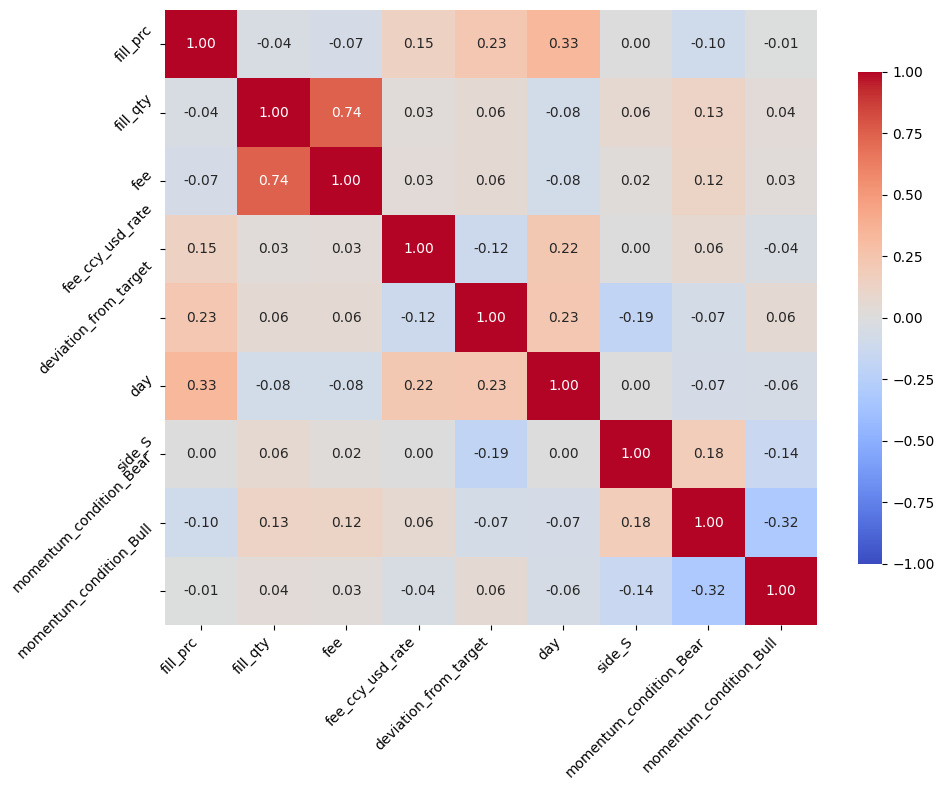

In [77]:
corr_matrix = X.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, cbar_kws={"shrink": .8})
plt.title = 'Correlation Matrix of Numeric Features'
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

Looking at our correlation matrix, our features look much better. Even though `fee` is somewhat correlated with `fill_qty`, which is expected, the VIF score is still less than 3. So we shall keep it still.

Let us proceed by constructing a preliminary multi-linear regression model using OLS. This serves as a further investigation to identify which features are statistically significant to the PnL of the strategy.

In [78]:
y_net_pnl = df_encoded['net_pnl']

In [79]:
# OLS for trade pnl

X_trade = sm.add_constant(features_reduced)

model_net_pnl = sm.OLS(y_net_pnl, X_trade).fit()

model_net_pnl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                net_pnl   R-squared:                       0.509
Model:                            OLS   Adj. R-squared:                  0.505
Method:                 Least Squares   F-statistic:                     128.1
Date:                Mon, 18 Mar 2024   Prob (F-statistic):          5.81e-165
Time:                        21:26:00   Log-Likelihood:                -2097.6
No. Observations:                1122   AIC:                             4215.
Df Residuals:                    1112   BIC:                             4265.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       2.2605      3.026      0.747      0.455      -3.676       8.197
fill_prc                   -0.0006      0.001     -0.535      0.593      -0.003       0.002
fill_qty                    0.5699      2.086      0.273      0.785      -3.523       4.663
fee                     -1700.5323    971.175     -1.751      0.080   -3606.075     205.011
fee_ccy_usd_rate           -0.0053      0.010     -0.507      0.612      -0.026       0.015
deviation_from_target       0.0287      0.283      0.101      0.919      -0.527       0.585
day                         0.0154      0.012      1.292      0.197      -0.008       0.039
side_S                     -0.0116      0.098     -0.118      0.906      -0.205       0.182
momentum_condition_Bear    -2.2536      0.119    -18.960      0.000      -2.487      -2.020
momentum_condition_Bull     2.3107      0.118     19.548      0.000       2.079       2.543
==============================================================================
Omnibus:                      569.461   Durbin-Watson:                   1.938
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            19917.175
Skew:                           1.691   Prob(JB):                         0.00
Kurtosis:                      23.362   Cond. No.                     4.03e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.03e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [80]:
def get_significant_coeffs(model, alpha=0.05):
    summary_frame = pd.DataFrame({
        'coef': model.params,
        'P>|t|': model.pvalues
    }).reset_index()
    summary_frame.rename(columns={'index': 'name'}, inplace=True)
    
    significant_coeffs = summary_frame[summary_frame['P>|t|'] < alpha]
    
    return significant_coeffs[['name', 'coef', 'P>|t|']]

get_significant_coeffs(model_net_pnl)

name      coef         P>|t|
8  momentum_condition_Bear -2.253563  1.105582e-69
9  momentum_condition_Bull  2.310660  2.222305e-73

The OLS regression indicates an R-squared value of `0.5091` and an adjusted R-squared value of `0.505`. This means that our model explains 50.5% of the variance in the PnL. While this is not a high R-squared value, the F-statistic and the p-value of the regression model is statistically significant, with values of `128.1` and `5.81e-165` respectively. This means that some coefficients in our model are statistically significant. There is also a further note that the condition number if large, indicating multicolinearity or other numerical problems. To address this, let us isolate the features that are statistically significant, namely `momentum_condition_Bear` and `momentum_condition_Bull`.

Thinking about the collection of statistically significant features, the fact that `momentum_condition_Bear` and `momentum_condition_Bull` are significant here aligns with our initial analysis when we bucketed the PnL by momentums.

With regards to the strategy's performance, the finding that only few of our features are significant to the PnL is a good sign. It means that the strategy is robust and can handle different market stress and other variables. When designing an algorithmic trading strategy, this is a quality we want to see as that means we have `alpha` in our strategy, or that our strategy is not dependent on external factors.

Let us further investigate our isolated features using Lasso and Ridge regression to see if the results are consistent.

In [81]:
selected_features = ['momentum_condition_Bear', 'momentum_condition_Bull']

# Function to standardize the data since our analysis focuses on the importance of the features in relation to each other on the net pnl
def standardize_data(data):
    return (data - data.mean()) / data.std()

for feature in selected_features:
      df_encoded[feature] = standardize_data(df_encoded[feature])


In [82]:
# Now that we have the features we want, let's split our data into training and testing sets
selection = selected_features + ['net_pnl']
train_data, test_data = train_test_split(df_encoded[selection], test_size=0.3, random_state=42)

print(f"I have {train_data.shape[0]} entries in my training set")
print(f"I have {test_data.shape[0]} entries in my testing set")
# The number of entries seem like a reasonable amount for a simple linear regression model

I have 785 entries in my training set
I have 337 entries in my testing set


In [83]:
# Implement an RMSE loss function
def rmse_cv(model, X_train, y_train, cv=5):
    # Calculate the cross-validated RMSE for a given model.
    neg_mse_scores = cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=cv)
    # Calculate RMSE from the negated MSE scores
    rmse_scores = np.sqrt(-neg_mse_scores)
    # Return the average RMSE
    return np.mean(rmse_scores)

In [84]:
X_train = train_data[selected_features]
y_train = train_data['net_pnl']

X_test = test_data[selected_features]
y_test = test_data['net_pnl']

In [85]:
# Lasso Regression
alphas = np.logspace(-6, 6, 100)
lasso_cv = LassoCV(alphas=alphas, cv=10, max_iter=10000)
lasso_cv.fit(X_train, y_train)

optimal_lambda = lasso_cv.alpha_
print(f"The best lambda is: {optimal_lambda}")

lasso_cv_rmse = rmse_cv(lasso_cv, X_train, y_train).mean()
print(f"Train Lasso RMSE: {lasso_cv_rmse}")

y_pred_lasso = lasso_cv.predict(X_test)
lasso_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
print(f"Test Lasso RMSE: {lasso_rmse}")


coefficients = dict(zip(selected_features, lasso_cv.coef_))
regression_equation = "net_pnl = " + " + ".join([f"({coef:.4f}){feature}" for feature, coef in coefficients.items()])
print("\nRegression equation:")
print(regression_equation)

The best lambda is: 1e-06
Train Lasso RMSE: 1.4262504930526139
Test Lasso RMSE: 1.8740163901679934

Regression equation:
net_pnl = (-1.0043)momentum_condition_Bear + (0.8639)momentum_condition_Bull


The Lasso regression model yields training and testing RMSE values of 1.426 and 1.874, respectively, indicating a reasonable fit to the data without overfitting. This model aligns with our previous analysis, highlighting the impacts of different market conditions on the PnL. Specifically, the `momentum_condition_Bear` coefficient is negatively significant, suggesting a pronounced detrimental effect on PnL during bear markets. Conversely, `momentum_condition_Bull` exhibits a positive influence, albeit with a smaller magnitude, implying a beneficial but less potent effect during bull markets. The larger absolute value of the `momentum_condition_Bear` coefficient compared to `momentum_condition_Bull` suggests the strategy's PnL is more adversely affected by market downturns than it benefits from upturns. This asymmetry could indicate the strategy's limitations in capitalizing on bullish trends or its vulnerability to bearish conditions, pointing to potential areas for enhancing its risk management and performance in diverse market environments. Finally, the optimal lambda value of `1e-06` signifies minimal regularization, emphasizing the model's reliance on the inherent data relationships rather than on constraint imposition for predictive accuracy.

Optimal alpha: 18.738174228603867 with Train RMSE: 1.4259647477374575
Test RMSE: 1.8776593776875328

Regression equation:
net_pnl = (-0.9858)momentum_condition_Bear + (0.8492)momentum_condition_Bull


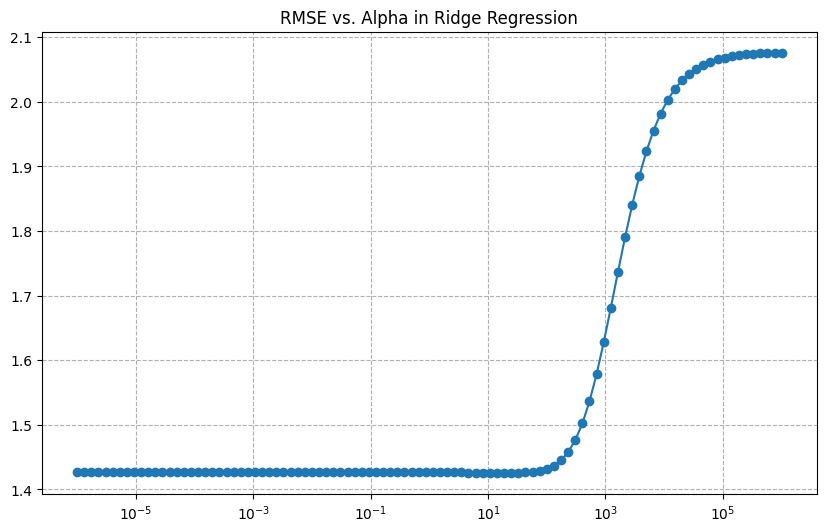

In [86]:
# Ridge Regression

ridge = Ridge()
cv_ridge_rmse = []

for alpha in alphas:
    model = Ridge(alpha=alpha)    
    # Use cross_val_score to calculate the negative mean squared error for each fold
    # Take the square root of the negative mean to get RMSE
    # np.mean is used to get the average RMSE across all folds
    rmse = rmse_cv(model, X_train, y_train).mean()
    cv_ridge_rmse.append(rmse)

# Convert the results into a numpy array for efficient operations
cv_ridge_rmse = np.array(cv_ridge_rmse)
min_rmse_alpha = alphas[np.argmin(cv_ridge_rmse)]
print(f"Optimal alpha: {min_rmse_alpha} with Train RMSE: {np.min(cv_ridge_rmse)}")

ridge_model = Ridge(alpha=min_rmse_alpha).fit(X_train, y_train)

y_pred_ridge = ridge_model.predict(X_test)
ridge_rmse = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
print(f"Test RMSE: {ridge_rmse}")

coefficients = dict(zip(selected_features, ridge_model.coef_))
regression_equation = "net_pnl = " + " + ".join([f"({coef:.4f}){feature}" for feature, coef in coefficients.items()])
print("\nRegression equation:")
print(regression_equation)

cv_ridge_series = pd.Series(cv_ridge_rmse, index=alphas)
plt.figure(figsize=(10, 6))
cv_ridge_series.plot(logx=True, marker='o', linestyle='-', title='RMSE vs. Alpha in Ridge Regression')
plt.xlabel = "Alpha (log scale)"
plt.ylabel = "Root Mean Squared Error (RMSE)"
plt.grid(True, which="both", ls="--")
plt.show()

The graph that plots RMSE against the alpha parameter in Ridge regression clearly shows that as the regularization strength increases, the RMSE decreases to a point before increasing sharply. This indicates an effective regularization range where the model performance is optimized. The selected alpha is near the lower end of this range, which reflects that our model requires some regularization but not to a degree that significantly constrains the coefficient estimates

On the Ridge regression itself, the optimal alpha value was determined to be approximately `18.738`, which minimizes the RMSE to `1.426` on the training set, indicating that the model fits the training data well. The slight increase in RMSE to `1.878` on the test set suggests that the model is generalizing well to unseen data.

The regression equation derived from the Ridge model is also very similar to that from Lasso. This equation indicates that bear market conditions are negatively associated with net PnL, and bull market conditions have a positive association, consistent with the previous Lasso analysis. The negative coefficient for bear market conditions is larger in absolute value than the positive coefficient for bull market conditions, once again suggesting a greater sensitivity to downturns.

In [87]:
# OLS RMSE
X_train_const = sm.add_constant(X_train)
model_ols = sm.OLS(y_train, X_train_const).fit()
X_test_const = sm.add_constant(X_test)

y_train_pred_ols = model_ols.predict(X_train_const)
ols_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_ols))
print(f"OLS Train RMSE: {ols_train_rmse}")

y_pred_ols = model_ols.predict(X_test_const)
ols_rmse = np.sqrt(mean_squared_error(y_test, y_pred_ols))
print(f"OLS Test RMSE: {ols_rmse}")

coefficients = dict(zip(selected_features, model_ols.params[1:]))
regression_equation = "net_pnl = " + " + ".join([f"({coef:.4f}){feature}" for feature, coef in coefficients.items()])
print("\nRegression equation:")
print(regression_equation)
model_ols.summary()

OLS Train RMSE: 1.4339825869420624
OLS Test RMSE: 1.874016210271347

Regression equation:
net_pnl = (-1.0043)momentum_condition_Bear + (0.8639)momentum_condition_Bull


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                net_pnl   R-squared:                       0.530
Model:                            OLS   Adj. R-squared:                  0.528
Method:                 Least Squares   F-statistic:                     440.3
Date:                Mon, 18 Mar 2024   Prob (F-statistic):          8.14e-129
Time:                        21:26:01   Log-Likelihood:                -1396.8
No. Observations:                 785   AIC:                             2800.
Df Residuals:                     782   BIC:                             2814.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -0.0491      0.051     -0.958      0.339      -0.150       0.052
momentum_condition_Bear    -1.0043      0.053    -18.771      0.000      -1.109      -0.899
momentum_condition_Bull     0.8639      0.055     15.797      0.000       0.757       0.971
==============================================================================
Omnibus:                      243.104   Durbin-Watson:                   2.098
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10021.269
Skew:                           0.639   Prob(JB):                         0.00
Kurtosis:                      20.457   Cond. No.                         1.39
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Likewise, for OLS, the RMSE and coefficient results are consistent with our results for Lasso and Ridge.

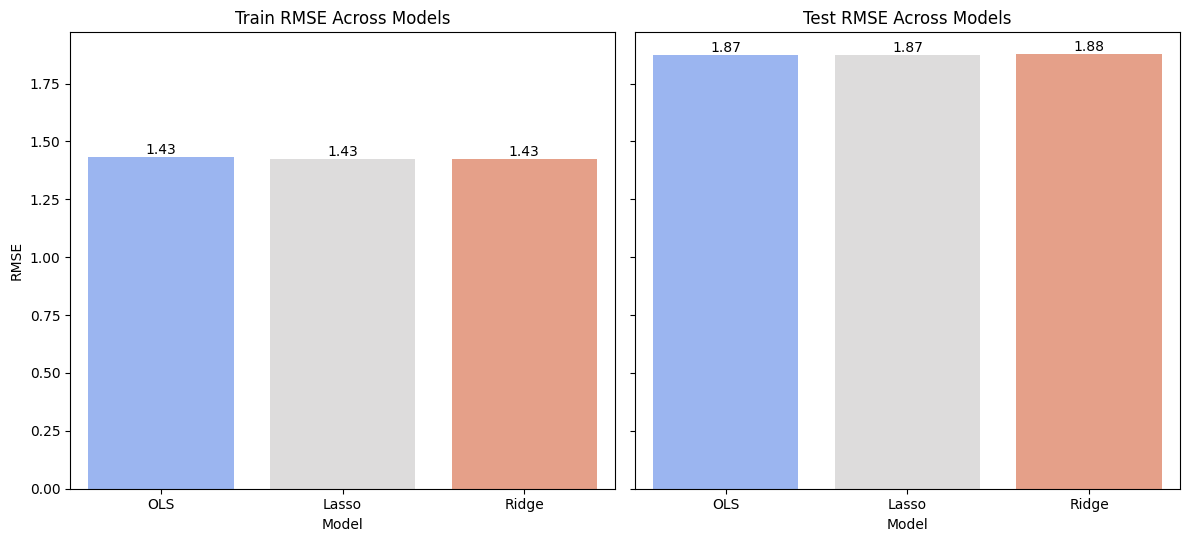

In [88]:
train_rmse_values = [ols_train_rmse, lasso_cv_rmse, np.min(cv_ridge_rmse)]
test_rmse_values = [ols_rmse, lasso_rmse, ridge_rmse]
models = ['OLS', 'Lasso', 'Ridge']

fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Train RMSE Barplot
sns.barplot(ax=axs[0], x=models, y=train_rmse_values, palette='coolwarm')
axs[0].set_title('Train RMSE Across Models')
axs[0].set_xlabel('Model')
axs[0].set_ylabel('RMSE')
for index, value in enumerate(train_rmse_values):
    axs[0].text(index, value, f'{value:.2f}', ha='center', va='bottom')

# Test RMSE Barplot
sns.barplot(ax=axs[1], x=models, y=test_rmse_values, palette='coolwarm')
axs[1].set_title('Test RMSE Across Models')
axs[1].set_xlabel('Model')
for index, value in enumerate(test_rmse_values):
    axs[1].text(index, value, f'{value:.2f}', ha='center', va='bottom')

plt.suptitle = 'Comparison of RMSE Values Across Models'
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

We can see that the RMSEs of the three models are roughly the same. This is expected, as the equations provided by each model are very similar, differing only slightly in the values of the coefficients.

Next, let us calculate the R-squared of our models and plot the observed vs predicted PnL to see how well our models are performing.

In [89]:
r_squared_lasso = r2_score(y_test, y_pred_lasso)
r_squared_ridge = r2_score(y_test, y_pred_ridge)
r_squared_ols = r2_score(y_test, y_pred_ols)

print(f"R-squared for Lasso: {r_squared_lasso}")
print(f"R-squared for Ridge: {r_squared_ridge}")
print(f"R-squared for OLS: {r_squared_ols}")

R-squared for Lasso: 0.45508500518265593
R-squared for Ridge: 0.452964374842585
R-squared for OLS: 0.45508510980113837


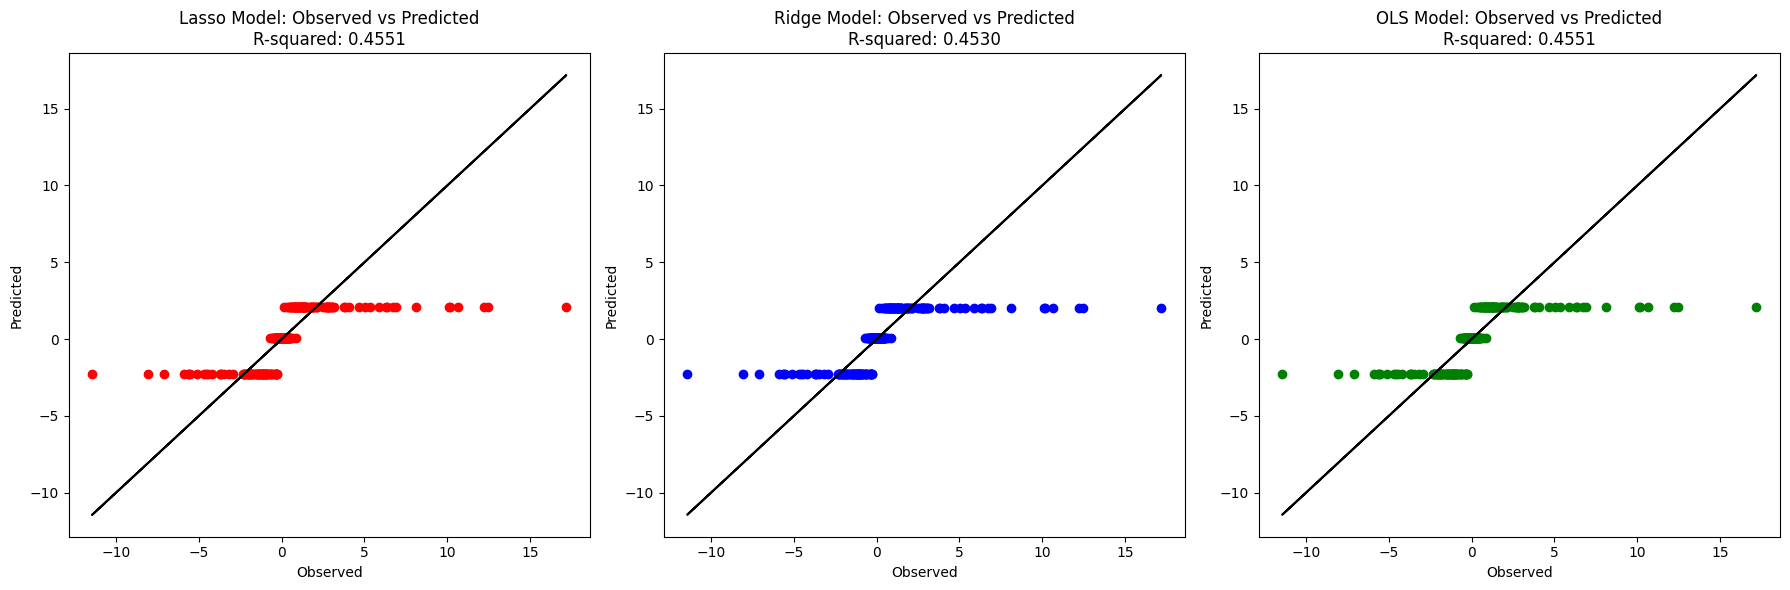

In [90]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

axs[0].scatter(y_test, y_pred_lasso, color="red")
axs[0].plot(y_test, y_test, color="black") 
axs[0].set_title(f"Lasso Model: Observed vs Predicted\nR-squared: {r_squared_lasso:.4f}")
axs[0].set_xlabel("Observed")
axs[0].set_ylabel("Predicted")

axs[1].scatter(y_test, y_pred_ridge, color="blue")
axs[1].plot(y_test, y_test, color="black") 
axs[1].set_title(f"Ridge Model: Observed vs Predicted\nR-squared: {r_squared_ridge:.4f}")
axs[1].set_xlabel("Observed")
axs[1].set_ylabel("Predicted")

axs[2].scatter(y_test, y_pred_ols, color="green")
axs[2].plot(y_test, y_test, color="black") 
axs[2].set_title(f"OLS Model: Observed vs Predicted\nR-squared: {r_squared_ols:.4f}")
axs[2].set_xlabel("Observed")
axs[2].set_ylabel("Predicted")

plt.tight_layout()
plt.show()

From the plots above, we can see that our model deviates from the observed values when the PnL deviates far from zero. Furthermore, note that the there seems to be three cluster of points, a cluster of points above zero, a cluster of points near zero, and a cluster of points below zero. This pattern suggests that the model's performance is inconsistent across different ranges of PnL values due to aspects of the trading strategy that are not fully captured by the model.

Next, let us rank the impact of each feature on the PnL of the strategy.

In [91]:
# Extracting coefficients from the models
coefs_ols = model_ols.params[1:]  # Excluding the intercept
feature_importance_ols = pd.DataFrame({
    'Feature': coefs_ols.index,
    'Importance': (coefs_ols.values),
}).sort_values(by='Importance', ascending=False)

coefs_lasso = lasso_cv.coef_
feature_importance_lasso = pd.DataFrame({
    'Feature': selected_features,
    'Importance': (coefs_lasso),
}).sort_values(by='Importance', ascending=False)

coefs_ridge = ridge_model.coef_ 
feature_importance_ridge = pd.DataFrame({
    'Feature': selected_features, 
    'Importance': (coefs_ridge)
}).sort_values(by='Importance', ascending=False)

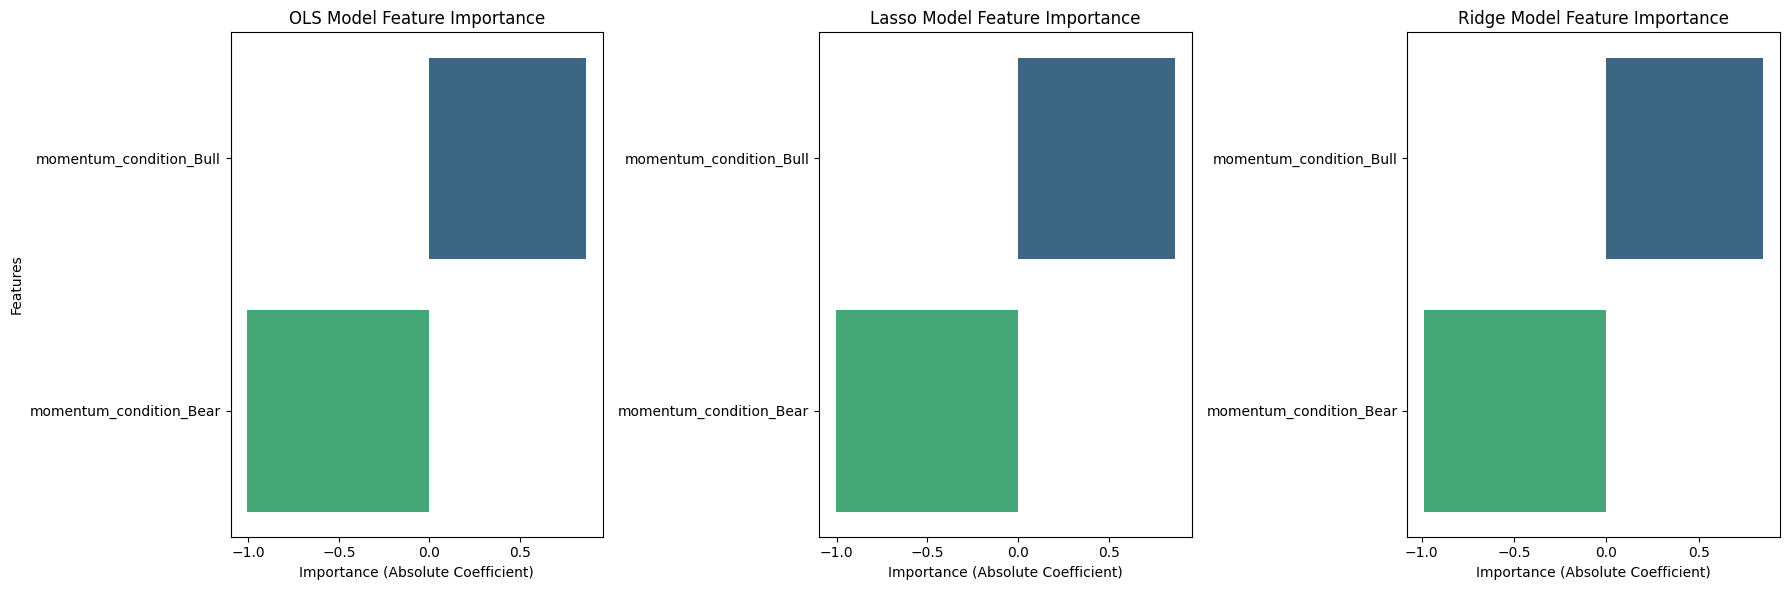

In [92]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# OLS Model Feature Importance
sns.barplot(x='Importance', y='Feature', data=feature_importance_ols.sort_values(by='Importance', ascending=False), ax=axs[0], palette='viridis')
axs[0].set_title('OLS Model Feature Importance')
axs[0].set_xlabel('Importance (Absolute Coefficient)')
axs[0].set_ylabel('Features')

# Lasso Model Feature Importance
sns.barplot(x='Importance', y='Feature', data=feature_importance_lasso.sort_values(by='Importance', ascending=False), ax=axs[1], palette='viridis')
axs[1].set_title('Lasso Model Feature Importance')
axs[1].set_xlabel('Importance (Absolute Coefficient)')
axs[1].set_ylabel('')

# Ridge Model Feature Importance
sns.barplot(x='Importance', y='Feature', data=feature_importance_ridge.sort_values(by='Importance', ascending=False), ax=axs[2], palette='viridis')
axs[2].set_title('Ridge Model Feature Importance')
axs[2].set_xlabel('Importance (Absolute Coefficient)')
axs[2].set_ylabel('')

fig.tight_layout()
plt.show()


As we have seen, the `momentum_condition_Bear` coefficient is negative and has a larger magnitude than the positive `momentum_condition_Bull` coefficient. This suggests the strategy's PnL is more adversely affected by market downturns than it benefits from upturns. This asymmetry could indicate the strategy's limitations in capitalizing on bullish trends or its vulnerability to bearish conditions, pointing to potential areas for enhancing its risk management and performance in diverse market environments.

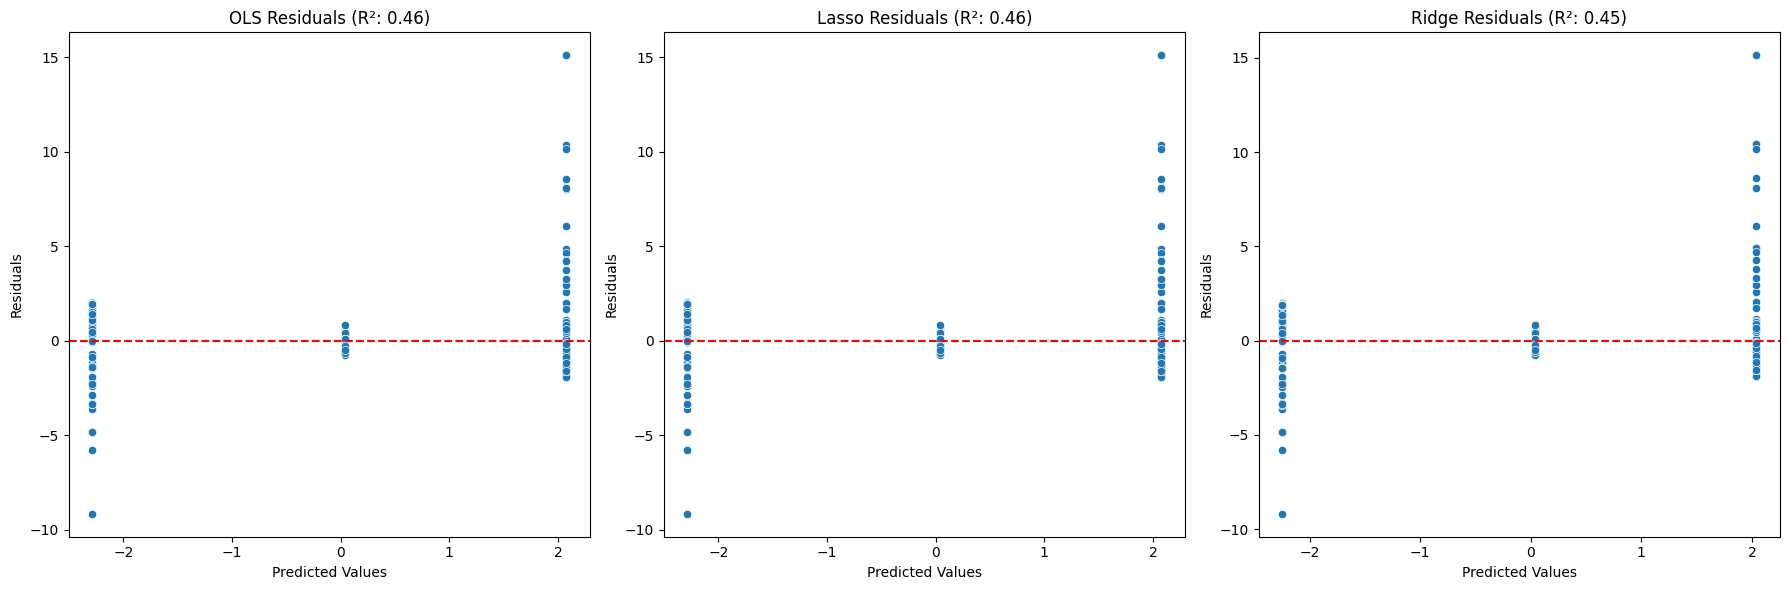

In [93]:
# Assuming y_pred_ols, y_pred_lasso, and y_pred_ridge are your predictions for each model
residuals_ols = y_test - y_pred_ols
residuals_lasso = y_test - y_pred_lasso
residuals_ridge = y_test - y_pred_ridge

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# OLS Residuals Plot
sns.scatterplot(ax=axs[0], x=y_pred_ols, y=residuals_ols)
axs[0].axhline(y=0, color='red', linestyle='--')
axs[0].set_title(f'OLS Residuals (R²: {r_squared_ols:.2f})')
axs[0].set_xlabel('Predicted Values')
axs[0].set_ylabel('Residuals')

# Lasso Residuals Plot
sns.scatterplot(ax=axs[1], x=y_pred_lasso, y=residuals_lasso)
axs[1].axhline(y=0, color='red', linestyle='--')
axs[1].set_title(f'Lasso Residuals (R²: {r_squared_lasso:.2f})')
axs[1].set_xlabel('Predicted Values')
axs[1].set_ylabel('Residuals')

# Ridge Residuals Plot
sns.scatterplot(ax=axs[2], x=y_pred_ridge, y=residuals_ridge)
axs[2].axhline(y=0, color='red', linestyle='--')
axs[2].set_title(f'Ridge Residuals (R²: {r_squared_ridge:.2f})')
axs[2].set_xlabel('Predicted Values')
axs[2].set_ylabel('Residuals')

plt.tight_layout()
plt.show()

From the results of our multi-linear regression, while we can see that while the residuals are distributed around the zero line, there is a noticeable spread of residuals as we move further from zero in predicted values, particularly in the extremes, suggesting that all models struggle with accurately predicting larger magnitudes of PnL. Furthermore, the R-squared value of our model is not high, indicating that our model does not explain a lot of the variance in the PnL. This is a sign that our model is not capturing all the information in the data. For future work, I would ideally like to investigate other features not present in the current dataset that may be significant to the PnL of the strategy or experimenting with non-linear models to see if they can capture the information in the data better. With regards to the strategy, my findings show that while the strategy is robust to many other variables, it is particularly more sensitive to bear momentums than bull momentums. This may be one potential area that warrants further testing as it may be a risk that the strategy may want to address.

## Strategy Behaviour: Exploring potential trading patterns by investigation and classification models

In this section, I will explore potential trading patterns and conditions which influence the strategy's behaviour. I will finalize my results by building a decision tree, random forest, and logistic regression model to classify better understand what features are most important to the strategy's behaviour. The goal of this section is to identify any interesting behaviour about the strategy.

#### Trading Patterns throughout the Day

The first pattern I want to investigate is if the strategy makes more or less trades during any particular hour of the day. This initial investigation will help me better understand the nature of the strategy.

In [94]:
df = merged_data.copy()
df

order_id side  fill_prc  fill_qty  \
timestamp                                                              
2023-07-01 00:46:05.617580  670003026938216    S   1937.83    0.0690   
2023-07-01 06:52:59.387733  670003026940777    B   1920.53    0.0264   
2023-07-01 09:19:52.809436  670003026941465    B   1914.23    0.0707   
2023-07-01 10:16:21.048157  670003026941676    B   1916.97    0.1719   
2023-07-01 14:37:25.452850  670003026943147    S   1921.43    0.1719   
...                                     ...  ...       ...       ...   
2023-07-15 16:18:25.726018  670008617129681    B   1935.21    0.1719   
2023-07-15 16:19:06.461829  670008617129719    B   1936.04    0.1719   
2023-07-15 18:39:02.613882  670008617130081    S   1939.44    0.0670   
2023-07-15 18:39:02.614281  670008617130071    S   1939.87    0.0674   
2023-07-15 19:04:52.935896  670008617130139    B   1935.97    0.0666   

                           liquidity       fee fee_ccy  fee_ccy_usd_rate  \
timestamp                                                                  
2023-07-01 00:46:05.617580     Maker  0.000000     bnb        237.395823   
2023-07-01 06:52:59.387733     Maker  0.000000     bnb        237.395823   
2023-07-01 09:19:52.809436     Maker  0.000000     bnb        237.395823   
2023-07-01 10:16:21.048157     Taker  0.000305     bnb        237.395823   
2023-07-01 14:37:25.452850     Maker  0.000000     bnb        237.395823   
...                              ...       ...     ...               ...   
2023-07-15 16:18:25.726018     Taker  0.000299     bnb        259.829225   
2023-07-15 16:19:06.461829     Taker  0.000299     bnb        259.829225   
2023-07-15 18:39:02.613882     Maker  0.000000     bnb        259.829225   
2023-07-15 18:39:02.614281     Maker  0.000000     bnb        259.829225   
2023-07-15 19:04:52.935896     Maker  0.000000     bnb        259.829225   

                                        fill_id  symbol_x  ...  bid_prc  \
timestamp                                                  ...            
2023-07-01 00:46:05.617580  1688172365615000000  eth_usdc  ...  1937.94   
2023-07-01 06:52:59.387733  1688194379383000000  eth_usdc  ...  1921.73   
2023-07-01 09:19:52.809436  1688203192806000000  eth_usdc  ...  1915.36   
2023-07-01 10:16:21.048157  1688206581043000000  eth_usdc  ...  1917.32   
2023-07-01 14:37:25.452850  1688222245450000000  eth_usdc  ...  1921.86   
...                                         ...       ...  ...      ...   
2023-07-15 16:18:25.726018  1689437905700000000  eth_usdc  ...  1932.34   
2023-07-15 16:19:06.461829  1689437946423000000  eth_usdc  ...  1932.34   
2023-07-15 18:39:02.613882  1689446342610000000  eth_usdc  ...  1932.34   
2023-07-15 18:39:02.614281  1689446342610000001  eth_usdc  ...  1932.34   
2023-07-15 19:04:52.935896  1689447892932000000  eth_usdc  ...  1932.34   

                            ask_prc          symbol_y   trade_pnl  \
timestamp                                                           
2023-07-01 00:46:05.617580  1937.95  binance_eth_usdt  133.710270   
2023-07-01 06:52:59.387733  1921.74  binance_eth_usdt  -50.701992   
2023-07-01 09:19:52.809436  1915.37  binance_eth_usdt -135.336061   
2023-07-01 10:16:21.048157  1917.33  binance_eth_usdt -329.599496   
2023-07-01 14:37:25.452850  1921.87  binance_eth_usdt  330.293817   
...                             ...               ...         ...   
2023-07-15 16:18:25.726018  1932.35  binance_eth_usdt -332.740259   
2023-07-15 16:19:06.461829  1932.35  binance_eth_usdt -332.882936   
2023-07-15 18:39:02.613882  1932.35  binance_eth_usdt  129.942480   
2023-07-15 18:39:02.614281  1932.35  binance_eth_usdt  130.747238   
2023-07-15 19:04:52.935896  1932.35  binance_eth_usdt -128.935602   

                           cumulative_trade_pnl  balance_value  inventory_pnl  \
timestamp                                                                       
2023-07-01 00:46:05.617580           133.710270     727.696470       0.00

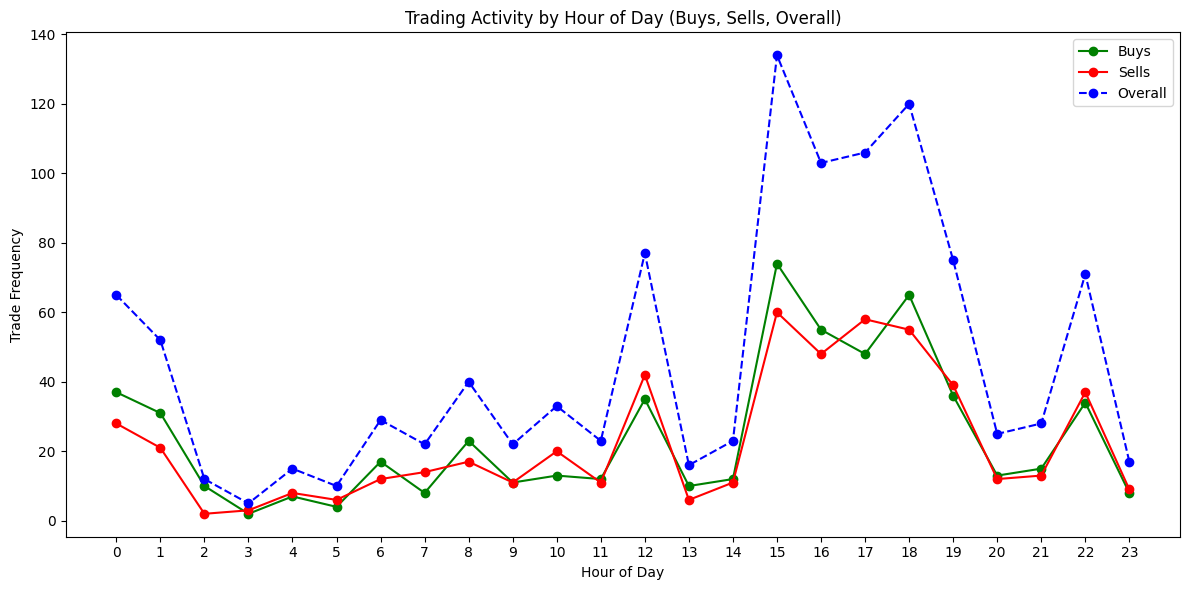

In [95]:
df['hour_of_day'] = df.index.hour

buy_trades_by_hour = df[df['side'] == 'B'].groupby('hour_of_day').size()
sell_trades_by_hour = df[df['side'] == 'S'].groupby('hour_of_day').size()
overall_trades_by_hour = df.groupby('hour_of_day').size()

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(buy_trades_by_hour.index, buy_trades_by_hour.values, label='Buys', color='green', marker='o', linestyle='-')
ax.plot(sell_trades_by_hour.index, sell_trades_by_hour.values, label='Sells', color='red', marker='o', linestyle='-')
ax.plot(overall_trades_by_hour.index, overall_trades_by_hour.values, label='Overall', color='blue', marker='o', linestyle='--')

ax.set_xlabel('Hour of Day')
ax.set_ylabel('Trade Frequency')
ax.set_title('Trading Activity by Hour of Day (Buys, Sells, Overall)')
ax.set_xticks(range(24))  # Ensure all hours are displayed

ax.legend()

plt.tight_layout()
plt.show()

In [96]:
contingency_table = pd.crosstab(df['hour_of_day'], df['side'])
chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-squared Test Statistic: {chi2_stat}")
print(f"P-value: {p_val}")
print(f"Degrees of Freedom: {dof}")
print(f"Expected Frequencies: {expected}")

Chi-squared Test Statistic: 18.78074859708902
P-value: 0.713874371933946
Degrees of Freedom: 23
Expected Frequencies: [[33.57079252 31.42920748]
 [26.85663402 25.14336598]
 [ 6.19768477  5.80231523]
 [ 2.58236866  2.41763134]
 [ 7.74710597  7.25289403]
 [ 5.16473731  4.83526269]
 [14.9777382  14.0222618 ]
 [11.36242208 10.63757792]
 [20.65894924 19.34105076]
 [11.36242208 10.63757792]
 [17.04363313 15.95636687]
 [11.87889581 11.12110419]
 [39.76847729 37.23152271]
 [ 8.2635797   7.7364203 ]
 [11.87889581 11.12110419]
 [69.20747996 64.79252004]
 [53.1967943  49.8032057 ]
 [54.74621549 51.25378451]
 [61.97684773 58.02315227]
 [38.73552983 36.26447017]
 [12.91184328 12.08815672]
 [14.46126447 13.53873553]
 [36.66963491 34.33036509]
 [ 8.78005343  8.21994657]]


From the results, while graph may sshowem that the strategy trades more from the periods between 3pm and 6pm, and the least amount at 2pm, the Chi-squared test shows that the frequency of trading is not statistically correlated with the hour of the day. The trend we see in the graph may be coincidental, driven by trading demand during that particular period in time and not part of the strategy's inherent behaviour or pattern. To me, this is intersting as my initial impression of algorithmic trading strategies is that they are more active during certain periods of the day. Let us investigate other factors which can tell us more about the behaviour of the strategy.

#### Trading Patterns by Mid Price

Here, I want to see if the behaviour of strategy follows the mid price of the asset. I will calculate the average mid price of the asset for each trading day and then plot the trading frequency against the average mid price for each day.

In [97]:
df = merged_data.copy()
df

order_id side  fill_prc  fill_qty  \
timestamp                                                              
2023-07-01 00:46:05.617580  670003026938216    S   1937.83    0.0690   
2023-07-01 06:52:59.387733  670003026940777    B   1920.53    0.0264   
2023-07-01 09:19:52.809436  670003026941465    B   1914.23    0.0707   
2023-07-01 10:16:21.048157  670003026941676    B   1916.97    0.1719   
2023-07-01 14:37:25.452850  670003026943147    S   1921.43    0.1719   
...                                     ...  ...       ...       ...   
2023-07-15 16:18:25.726018  670008617129681    B   1935.21    0.1719   
2023-07-15 16:19:06.461829  670008617129719    B   1936.04    0.1719   
2023-07-15 18:39:02.613882  670008617130081    S   1939.44    0.0670   
2023-07-15 18:39:02.614281  670008617130071    S   1939.87    0.0674   
2023-07-15 19:04:52.935896  670008617130139    B   1935.97    0.0666   

                           liquidity       fee fee_ccy  fee_ccy_usd_rate  \
timestamp                                                                  
2023-07-01 00:46:05.617580     Maker  0.000000     bnb        237.395823   
2023-07-01 06:52:59.387733     Maker  0.000000     bnb        237.395823   
2023-07-01 09:19:52.809436     Maker  0.000000     bnb        237.395823   
2023-07-01 10:16:21.048157     Taker  0.000305     bnb        237.395823   
2023-07-01 14:37:25.452850     Maker  0.000000     bnb        237.395823   
...                              ...       ...     ...               ...   
2023-07-15 16:18:25.726018     Taker  0.000299     bnb        259.829225   
2023-07-15 16:19:06.461829     Taker  0.000299     bnb        259.829225   
2023-07-15 18:39:02.613882     Maker  0.000000     bnb        259.829225   
2023-07-15 18:39:02.614281     Maker  0.000000     bnb        259.829225   
2023-07-15 19:04:52.935896     Maker  0.000000     bnb        259.829225   

                                        fill_id  symbol_x  ...  bid_prc  \
timestamp                                                  ...            
2023-07-01 00:46:05.617580  1688172365615000000  eth_usdc  ...  1937.94   
2023-07-01 06:52:59.387733  1688194379383000000  eth_usdc  ...  1921.73   
2023-07-01 09:19:52.809436  1688203192806000000  eth_usdc  ...  1915.36   
2023-07-01 10:16:21.048157  1688206581043000000  eth_usdc  ...  1917.32   
2023-07-01 14:37:25.452850  1688222245450000000  eth_usdc  ...  1921.86   
...                                         ...       ...  ...      ...   
2023-07-15 16:18:25.726018  1689437905700000000  eth_usdc  ...  1932.34   
2023-07-15 16:19:06.461829  1689437946423000000  eth_usdc  ...  1932.34   
2023-07-15 18:39:02.613882  1689446342610000000  eth_usdc  ...  1932.34   
2023-07-15 18:39:02.614281  1689446342610000001  eth_usdc  ...  1932.34   
2023-07-15 19:04:52.935896  1689447892932000000  eth_usdc  ...  1932.34   

                            ask_prc          symbol_y   trade_pnl  \
timestamp                                                           
2023-07-01 00:46:05.617580  1937.95  binance_eth_usdt  133.710270   
2023-07-01 06:52:59.387733  1921.74  binance_eth_usdt  -50.701992   
2023-07-01 09:19:52.809436  1915.37  binance_eth_usdt -135.336061   
2023-07-01 10:16:21.048157  1917.33  binance_eth_usdt -329.599496   
2023-07-01 14:37:25.452850  1921.87  binance_eth_usdt  330.293817   
...                             ...               ...         ...   
2023-07-15 16:18:25.726018  1932.35  binance_eth_usdt -332.740259   
2023-07-15 16:19:06.461829  1932.35  binance_eth_usdt -332.882936   
2023-07-15 18:39:02.613882  1932.35  binance_eth_usdt  129.942480   
2023-07-15 18:39:02.614281  1932.35  binance_eth_usdt  130.747238   
2023-07-15 19:04:52.935896  1932.35  binance_eth_usdt -128.935602   

                           cumulative_trade_pnl  balance_value  inventory_pnl  \
timestamp                                                                       
2023-07-01 00:46:05.617580           133.710270     727.696470       0.00

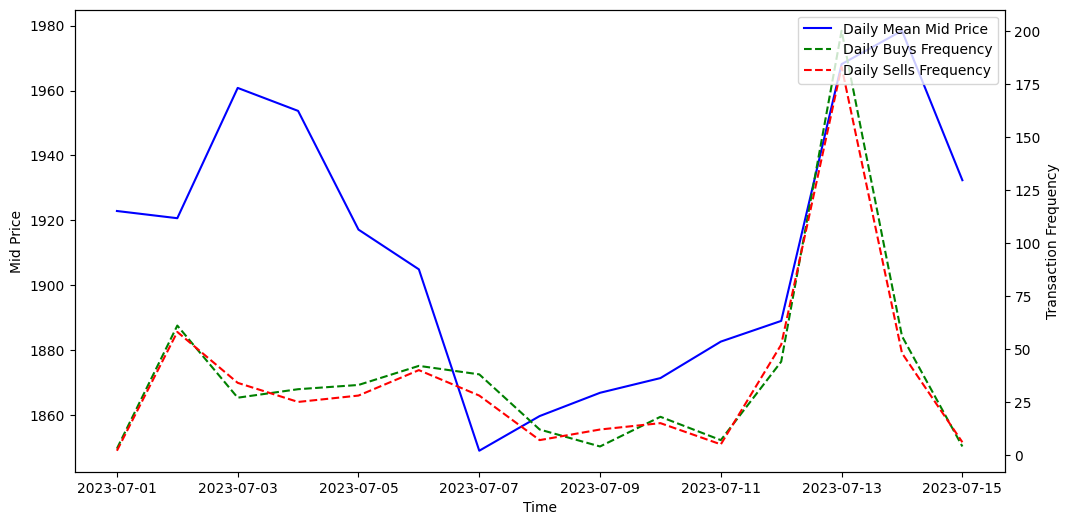

Spearman's Correlation Coefficient: 0.306 and P-value: 0.268


In [98]:
df['date'] = df.index.date
df['mid_prc'] = (df['bid_prc'] + df['ask_prc']) / 2

daily_mid_price = df.groupby('date')['mid_prc'].mean()
daily_buys = df[df['side'] == 'B'].groupby('date').size()
daily_sells = df[df['side'] == 'S'].groupby('date').size()

fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(daily_mid_price.index, daily_mid_price.values, color='blue', label='Daily Mean Mid Price')
ax1.set_ylabel('Mid Price')
ax1.set_xlabel('Time')

ax2 = ax1.twinx()
ax2.plot(daily_buys.index, daily_buys.values, color='green', linestyle='--', label='Daily Buys Frequency')
ax2.plot(daily_sells.index, daily_sells.values, color='red', linestyle='--', label='Daily Sells Frequency')
ax2.set_ylabel('Transaction Frequency')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

plt.title = 'Mid Price and Transaction Frequency Over Time'
plt.show()

daily_transaction_frequency = df.groupby('date').size()
spearman_corr, spearman_p_value = stats.spearmanr(daily_mid_price, daily_transaction_frequency)

print(f"Spearman's Correlation Coefficient: {spearman_corr:.3f} and P-value: {spearman_p_value:.3f}")

A first look at the graph may seem like the frequency of buying and selling follows the same trend as `mid_prc`. However, the Spearman correlation is not statistically significant. To me, this makes sense as the behaviour of the strategy should not be dependent on the price of the asset. A market making strategy should continue to provide liquidity regardless of the mid price. 

#### Mean Reverting Behaviour from Mean Mid Price

In this section, I will investigate if the strategy exhibits mean reverting behaviour from the mid price. This is different from the previous section as I will investigate the behaviour of strategy as it deviates from the estimated mean mid price of the asset. To maximize profitability, I hypothesize the strategy will make more buys when the price of the asset falls below the mean and sell more when the price of the asset rises above the mean.

First, let us plot the distribution of the `mid_prc`. I am using `mid_prc` because it more reflects the general market sentiment of what the asset is worth.

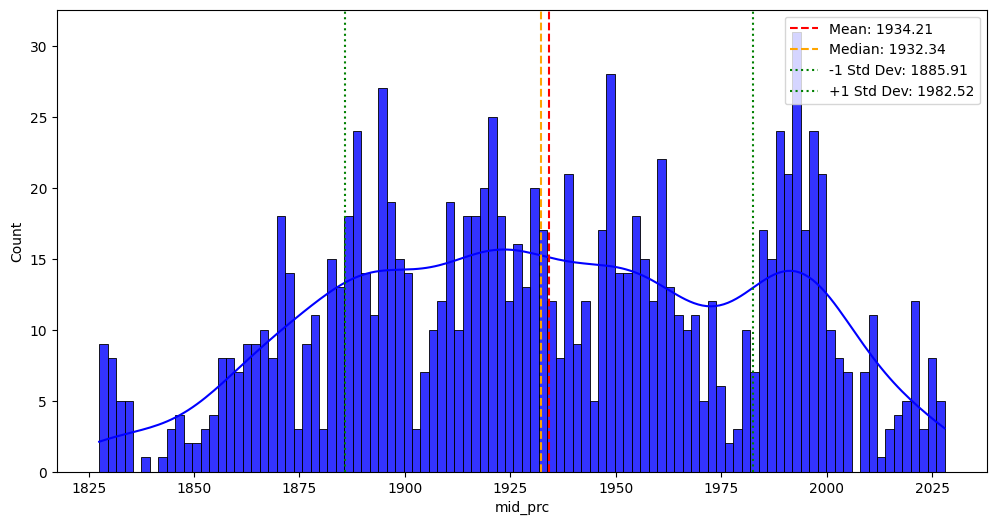

In [102]:
plt.figure(figsize=(12, 6))
sns.histplot(df['mid_prc'], bins=100, kde=True, color='blue', alpha=0.8)

mean_mid_prc = df['mid_prc'].mean()
median_mid_prc = df['mid_prc'].median()
std_mid_prc = df['mid_prc'].std()

plt.axvline(mean_mid_prc, color='red', linestyle='--', label=f'Mean: {mean_mid_prc:.2f}')
plt.axvline(median_mid_prc, color='orange', linestyle='--', label=f'Median: {median_mid_prc:.2f}')
plt.axvline(mean_mid_prc - std_mid_prc, color='green', linestyle=':', label=f'-1 Std Dev: {mean_mid_prc - std_mid_prc:.2f}')
plt.axvline(mean_mid_prc + std_mid_prc, color='green', linestyle=':', label=f'+1 Std Dev: {mean_mid_prc + std_mid_prc:.2f}')

plt.legend(loc = 'upper right')
plt.title = 'Distribution of Mid Price'
plt.xlabel = 'Mid Price'
plt.ylabel = 'Frequency'
plt.show()

Note that `mid_prc` is not normally distributed. I want an estimate of the mean and standard deviation of the `mid_prc` to see if the strategy is buying and selling around the mean. To accomplish this, I will use the estimate mean mid price I calculated from earlier.

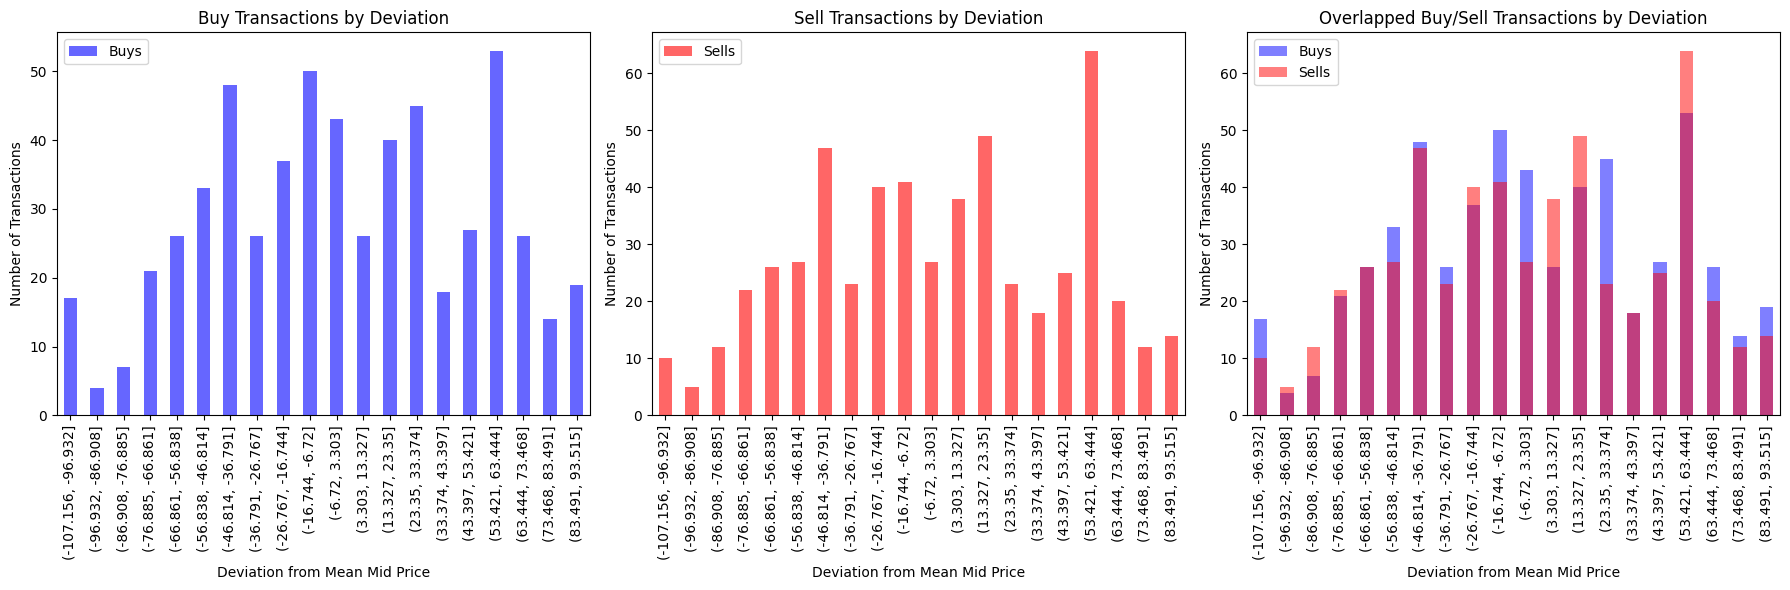

In [104]:
# I will take the estimate mean Mid price as the midpoint of the confidence interval
mean_mid_prc = (lower_bound_mid_prc + upper_bound_mid_prc) / 2
# Potentially a more accurate estimate from testing and iterating
# mean_mid_price = ((mean_mid_price - 26.168) - (mean_mid_price - 46.317)) / 2
std_mid_price = df['mid_prc'].std()

df['deviation_from_mean_mid_prc'] = df['mid_prc'] - mean_mid_prc
df['deviation_category'] = pd.cut(df['deviation_from_mean_mid_prc'], bins=20)

buy_counts = df[df['side'] == 'B'].groupby('deviation_category').size()
sell_counts = df[df['side'] == 'S'].groupby('deviation_category').size()

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Plot buy counts
buy_counts.plot(kind='bar', ax=axes[0], color='blue', alpha=0.6, label='Buys')
axes[0].set_title('Buy Transactions by Deviation')
axes[0].set_xlabel('Deviation from Mean Mid Price')
axes[0].set_ylabel('Number of Transactions')
axes[0].legend()

# Plot sell counts
sell_counts.plot(kind='bar', ax=axes[1], color='red', alpha=0.6, label='Sells')
axes[1].set_title('Sell Transactions by Deviation')
axes[1].set_xlabel('Deviation from Mean Mid Price')
axes[1].set_ylabel('Number of Transactions')
axes[1].legend()

# Plot overlapped buy and sell counts
buy_counts.plot(kind='bar', ax=axes[2], color='blue', alpha=0.5, label='Buys')
sell_counts.plot(kind='bar', ax=axes[2], color='red', alpha=0.5, label='Sells')
axes[2].set_title('Overlapped Buy/Sell Transactions by Deviation')
axes[2].set_xlabel('Deviation from Mean Mid Price')
axes[2].set_ylabel('Number of Transactions')
axes[2].legend()

plt.tight_layout()
plt.show()

In [105]:
# Transactions above and below deviation of 0
buys_above_deviation = df[(df['side'] == 'B') & (df['deviation_from_mean_mid_prc'] > 0)].shape[0]
sells_above_deviation = df[(df['side'] == 'S') & (df['deviation_from_mean_mid_prc'] > 0)].shape[0]

buys_below_deviation = df[(df['side'] == 'B') & (df['deviation_from_mean_mid_prc'] < 0)].shape[0]
sells_below_deviation = df[(df['side'] == 'S') & (df['deviation_from_mean_mid_prc'] < 0)].shape[0]

# How many times buys and sells exceed each other above and below deviation of 0
print(f"Buys above deviation: {buys_above_deviation}, Sells above deviation: {sells_above_deviation}")
print(f"Buys below deviation: {buys_below_deviation}, Sells below deviation: {sells_below_deviation}")

buys_exceed_sells_above = buys_above_deviation > sells_above_deviation
buys_exceed_sells_below = buys_below_deviation > sells_below_deviation

print(f"Do we buy more than we sell when the deviation is above 0?: {buys_exceed_sells_above}")
print(f"Do we buy more than we sell when the deviation is below 0?: {buys_exceed_sells_below}")

# Calculating, for each deviation category, when does buy exceed sell and vice versa above and below the mean
combined_counts = pd.DataFrame({'Buys': buy_counts, 'Sells': sell_counts}).fillna(0)

combined_counts['Buys_Exceed'] = combined_counts['Buys'] > combined_counts['Sells']
combined_counts['Sells_Exceed'] = combined_counts['Sells'] > combined_counts['Buys']

below_zero_categories = [i for i in combined_counts.index if i.left < 0]
buys_exceed_below_zero = combined_counts.loc[below_zero_categories]['Buys_Exceed'].sum()
sells_exceed_below_zero = combined_counts.loc[below_zero_categories]['Sells_Exceed'].sum()

above_zero_categories = [i for i in combined_counts.index if i.right > 0]
buys_exceed_above_zero = combined_counts.loc[above_zero_categories]['Buys_Exceed'].sum()
sells_exceed_above_zero = combined_counts.loc[above_zero_categories]['Sells_Exceed'].sum()

print(f"Times buys exceed sells for deviation < 0: {buys_exceed_below_zero}")
print(f"Times sells exceed buys for deviation < 0: {sells_exceed_below_zero}")
print(f"Times buys exceed sells for deviation > 0: {buys_exceed_above_zero}")
print(f"Times sells exceed buys for deviation > 0: {sells_exceed_above_zero}")

Buys above deviation: 278, Sells above deviation: 269
Buys below deviation: 302, Sells below deviation: 274
Do we buy more than we sell when the deviation is above 0?: True
Do we buy more than we sell when the deviation is below 0?: True
Times buys exceed sells for deviation < 0: 6
Times sells exceed buys for deviation < 0: 4
Times buys exceed sells for deviation > 0: 6
Times sells exceed buys for deviation > 0: 3


In [107]:
# Convert 'side' to a binary variable where 'B' is 1 and 'S' is 0
df['side_binary'] = df['side'].map({'B': 1, 'S': 0})

X = sm.add_constant(df[['deviation_from_mean_mid_prc']])
y = df['side_binary']

mean_from_mid_prc_model = sm.Logit(y, X).fit()

print(mean_from_mid_prc_model.summary())

Optimization terminated successfully.
         Current function value: 0.692587
         Iterations 3
                           Logit Regression Results                           
Dep. Variable:            side_binary   No. Observations:                 1123
Model:                          Logit   Df Residuals:                     1121
Method:                           MLE   Df Model:                            1
Date:                Mon, 18 Mar 2024   Pseudo R-squ.:               2.470e-05
Time:                        21:31:32   Log-Likelihood:                -777.78
converged:                       True   LL-Null:                       -777.79
Covariance Type:            nonrobust   LLR p-value:                    0.8446
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                           0.0660      0.060      1.105      0.269   

Observing the plots, we can see that even if the price of the asset is far above or below the mean, the strategy is still buying and selling in both directions. Furthermore, one interesting behaviour to point out is that the strategy tends to buy more than sell, regardless of the price being above or below the mean mid price. Initially, I hypothesized that the strategy would buy more when the price of the asset is below the mean and sell more when the price of the asset is above the mean. However, the logistic regression model shows that the deviation from the mean `mid_prc` is not statistically significant to the strategy's decision to buy or sell, leading me to conclude that the strategy does not exhibit a mean reversion behaviour on the frequency of trading with deviation from the mean `mid_prc`.

Thinking about this more, this result makes sense because a market making strategy must continue to trade regardless of the price of the asset to provide liquidity. From an evaluation standpoint, this is a good sign as it means that the strategy is serving its purpose as a market maker.

I want to dig a little deeper and investigate if `fill_value` of the strategy's buying and selling is influenced by the deviation from the mean of `mid_prc`. I am choosing `fill_qty` because it represents the total value of the asset the strategy is buying and selling. If I were to use `fill_qty` or `fill_prc` in isolation, it may not capture the full story of the strategy's trading behaviour.

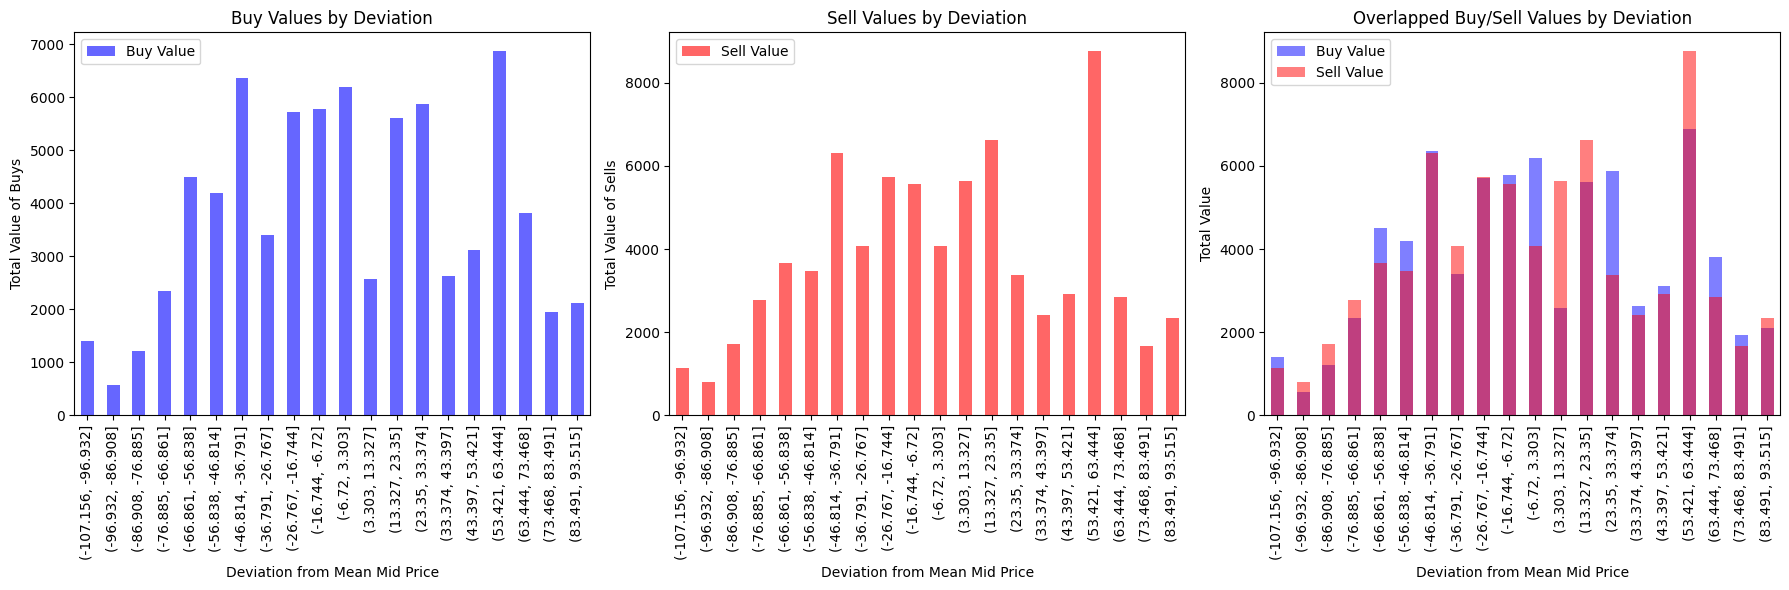

In [108]:
df['fill_value'] = df['fill_qty'] * df['fill_prc']
buy_value_sum = df[df['side'] == 'B'].groupby('deviation_category')['fill_value'].sum()
sell_value_sum = df[df['side'] == 'S'].groupby('deviation_category')['fill_value'].sum()

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

buy_value_sum.plot(kind='bar', ax=axes[0], color='blue', alpha=0.6, label='Buy Value')
axes[0].set_title('Buy Values by Deviation')
axes[0].set_xlabel('Deviation from Mean Mid Price')
axes[0].set_ylabel('Total Value of Buys')
axes[0].legend()

sell_value_sum.plot(kind='bar', ax=axes[1], color='red', alpha=0.6, label='Sell Value')
axes[1].set_title('Sell Values by Deviation')
axes[1].set_xlabel('Deviation from Mean Mid Price')
axes[1].set_ylabel('Total Value of Sells')
axes[1].legend()

buy_value_sum.plot(kind='bar', ax=axes[2], color='blue', alpha=0.5, label='Buy Value')
sell_value_sum.plot(kind='bar', ax=axes[2], color='red', alpha=0.5, label='Sell Value')
axes[2].set_title('Overlapped Buy/Sell Values by Deviation')
axes[2].set_xlabel('Deviation from Mean Mid Price')
axes[2].set_ylabel('Total Value')
axes[2].legend()

plt.tight_layout()
plt.show()


In [109]:
total_value_buys_above_deviation = df[(df['side'] == 'B') & (df['deviation_from_mean_mid_prc'] > 0)]['fill_value'].sum()
total_value_sells_above_deviation = df[(df['side'] == 'S') & (df['deviation_from_mean_mid_prc'] > 0)]['fill_value'].sum()

total_value_buys_below_deviation = df[(df['side'] == 'B') & (df['deviation_from_mean_mid_prc'] < 0)]['fill_value'].sum()
total_value_sells_below_deviation = df[(df['side'] == 'S') & (df['deviation_from_mean_mid_prc'] < 0)]['fill_value'].sum()

print(f"Total value of buys above mean deviation: {total_value_buys_above_deviation}")
print(f"Total value of sells above mean deviation: {total_value_sells_above_deviation}")
print(f"Total value of buys below mean deviation: {total_value_buys_below_deviation}")
print(f"Total value of sells below mean deviation: {total_value_sells_below_deviation}")

value_buys_exceed_sells_above = total_value_buys_above_deviation > total_value_sells_above_deviation
value_buys_exceed_sells_below = total_value_buys_below_deviation > total_value_sells_below_deviation

print("\nDo we buy in greater value than we sell when the deviation is above 0?:", value_buys_exceed_sells_above)
print("Do we buy in greater value than we sell when the deviation is below 0?:", value_buys_exceed_sells_below)

buy_fill_value = df[df['side'] == 'B']['fill_value']
buy_deviation = df[df['side'] == 'B']['deviation_from_mean_mid_prc']
sell_fill_value = df[df['side'] == 'S']['fill_value']
sell_deviation = df[df['side'] == 'S']['deviation_from_mean_mid_prc']

spearman_buy, spearman_p_value_buy = stats.spearmanr(buy_fill_value, buy_deviation)
spearman_sell, spearman_p_value_sell = stats.spearmanr(sell_fill_value, sell_deviation)

print(f"Buy Value and Deviation Spearman Correlation: {spearman_buy:.3f}, P-value: {spearman_p_value_buy:.3f}")
print(f"Sell Value and Deviation Spearman Correlation: {spearman_sell:.3f}, P-value: {spearman_p_value_sell:.3f}")

Total value of buys above mean deviation: 36164.454375999994
Total value of sells above mean deviation: 37515.32531099999
Total value of buys below mean deviation: 40080.019775
Total value of sells below mean deviation: 38476.826664

Do we buy in greater value than we sell when the deviation is above 0?: False
Do we buy in greater value than we sell when the deviation is below 0?: True
Buy Value and Deviation Spearman Correlation: 0.270, P-value: 0.000
Sell Value and Deviation Spearman Correlation: 0.466, P-value: 0.000


The results here are more refined. Here, we can see that there is a variation in the total value of buys and sells at different deviations from the mean mid price. For deviations above zero, the total value of sells exceeds the total value of buys. For deviations below zero, the total value of buys exceeds the total value of sells. This aligns with my initial hypothesis about the behaviour of the trading strategy in which the strategy buys more when the price of the asset is below the mean and sells more when the price of the asset is above the mean. Here, it seems, "buys more" and "sells more" means the total value of buys and sells, not the frequency of buys and sells. Furthermore, this relationship for buying and selling is statistically significant. This might mean that the strategy may be employing a kind of mean-reversion logic, where it anticipates that prices will revert to a mean value over time. By selling when prices are higher, it's betting on prices falling back towards the mean, and by buying when prices are lower, it's betting on prices rising back towards the mean. However, the correlations are not perfect, and other factors not captured in the data provided could also be influencing the trading decisions.

#### Mean Reverting Behaviour from Inventory Balance

Reading the problem statement closer, we are told that the market make around a target inventory. This leads me to hypothesize that the strategy should exhibit mean reverting behaviour on the inventory balance to maintain a target inventory.

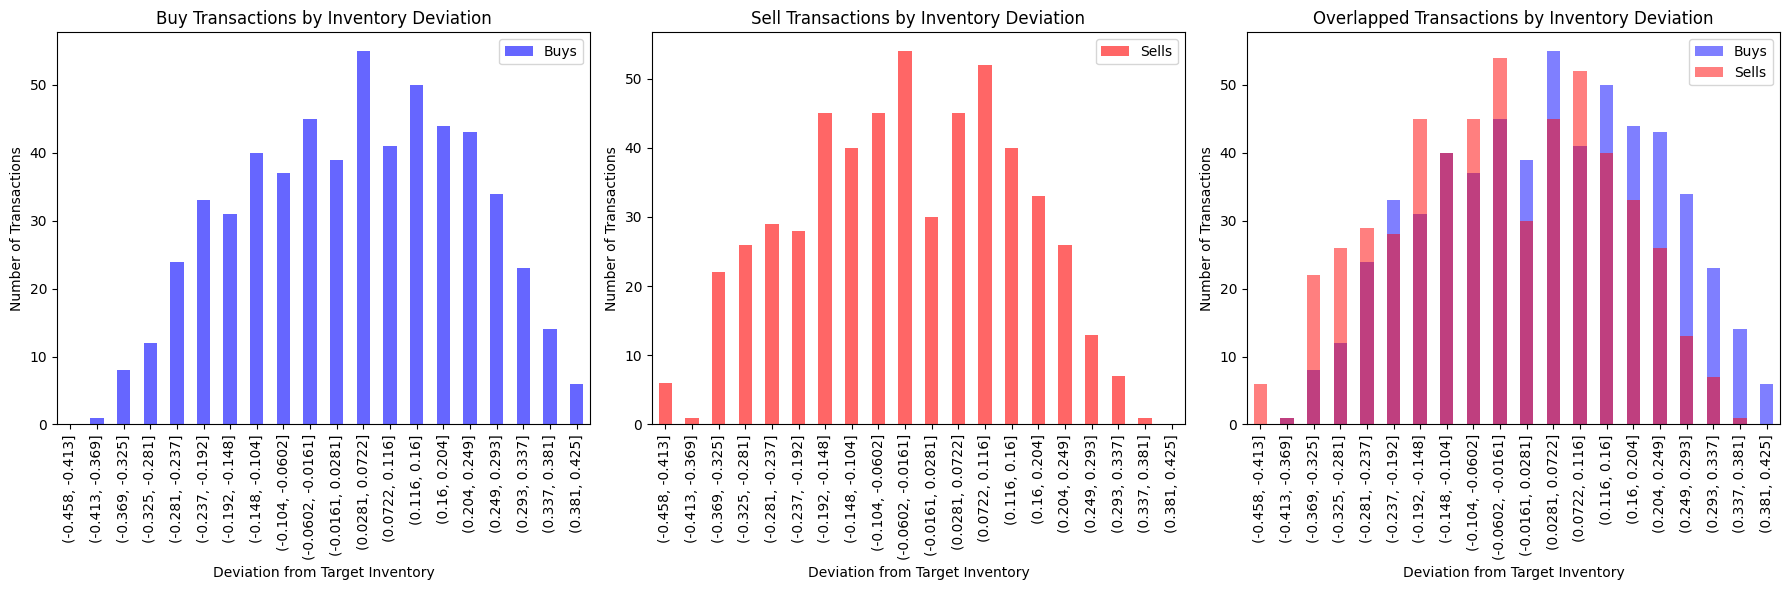

In [110]:
# Since I estimated the mean inventory balance before, I will use it again here.
df = merged_data.copy()
df['deviation_from_target_inventory'] = df['balance'] - target_inventory
df['inventory_deviation_category'] = pd.cut(df['deviation_from_target_inventory'], bins=20)

buy_counts_inventory = df[df['side'] == 'B'].groupby('inventory_deviation_category').size()
sell_counts_inventory = df[df['side'] == 'S'].groupby('inventory_deviation_category').size()

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Buys based on deviation from target inventory
buy_counts_inventory.plot(kind='bar', ax=axes[0], color='blue', alpha=0.6, label='Buys')
axes[0].set_title('Buy Transactions by Inventory Deviation')
axes[0].set_xlabel('Deviation from Target Inventory')
axes[0].set_ylabel('Number of Transactions')
axes[0].legend()

# Sells based on deviation from target inventory
sell_counts_inventory.plot(kind='bar', ax=axes[1], color='red', alpha=0.6, label='Sells')
axes[1].set_title('Sell Transactions by Inventory Deviation')
axes[1].set_xlabel('Deviation from Target Inventory')
axes[1].set_ylabel('Number of Transactions')
axes[1].legend()

# Overlapped Buys and Sells
buy_counts_inventory.plot(kind='bar', ax=axes[2], color='blue', alpha=0.5, label='Buys')
sell_counts_inventory.plot(kind='bar', ax=axes[2], color='red', alpha=0.5, label='Sells')
axes[2].set_title('Overlapped Transactions by Inventory Deviation')
axes[2].set_xlabel('Deviation from Target Inventory')
axes[2].set_ylabel('Number of Transactions')
axes[2].legend()

plt.tight_layout()
plt.show()


In [111]:
df['side_binary'] = df['side'].map({'B': 1, 'S': 0})
X_new = sm.add_constant(df[['deviation_from_target_inventory']])
y = df['side_binary']

mean_from_inventory_balance_model = sm.Logit(y, X_new).fit()

print(mean_from_inventory_balance_model.summary())

Optimization terminated successfully.
         Current function value: 0.673438
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:            side_binary   No. Observations:                 1123
Model:                          Logit   Df Residuals:                     1121
Method:                           MLE   Df Model:                            1
Date:                Mon, 18 Mar 2024   Pseudo R-squ.:                 0.02767
Time:                        21:47:11   Log-Likelihood:                -756.27
converged:                       True   LL-Null:                       -777.79
Covariance Type:            nonrobust   LLR p-value:                 5.342e-11
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                               0.0672      0.061      1.105  

Observing the plots and logistic regression model, while my intuition was correct that there is a correlation between deviance from mean inventory balance and buying and selling, the results show that it is in the opposite direction of what I predicted. This result is very interesting to me because one interpretation of this result is that as the inventory balance deviates higher from the mean, we make more buy orders, and as the inventory balance deviates lower from the mean, we make more sell orders. This implies that the inventory balance of the strategy will not revert to a mean, but will continue to grow or shrink, which is a result I did not expect. This part is confusing to me, but I believe I need to consult with the strategy's developers to understand this behaviour better.

Let me investigate further and see if there is a pattern in the value of buy and sell orders with deviation from the mean inventory balance.

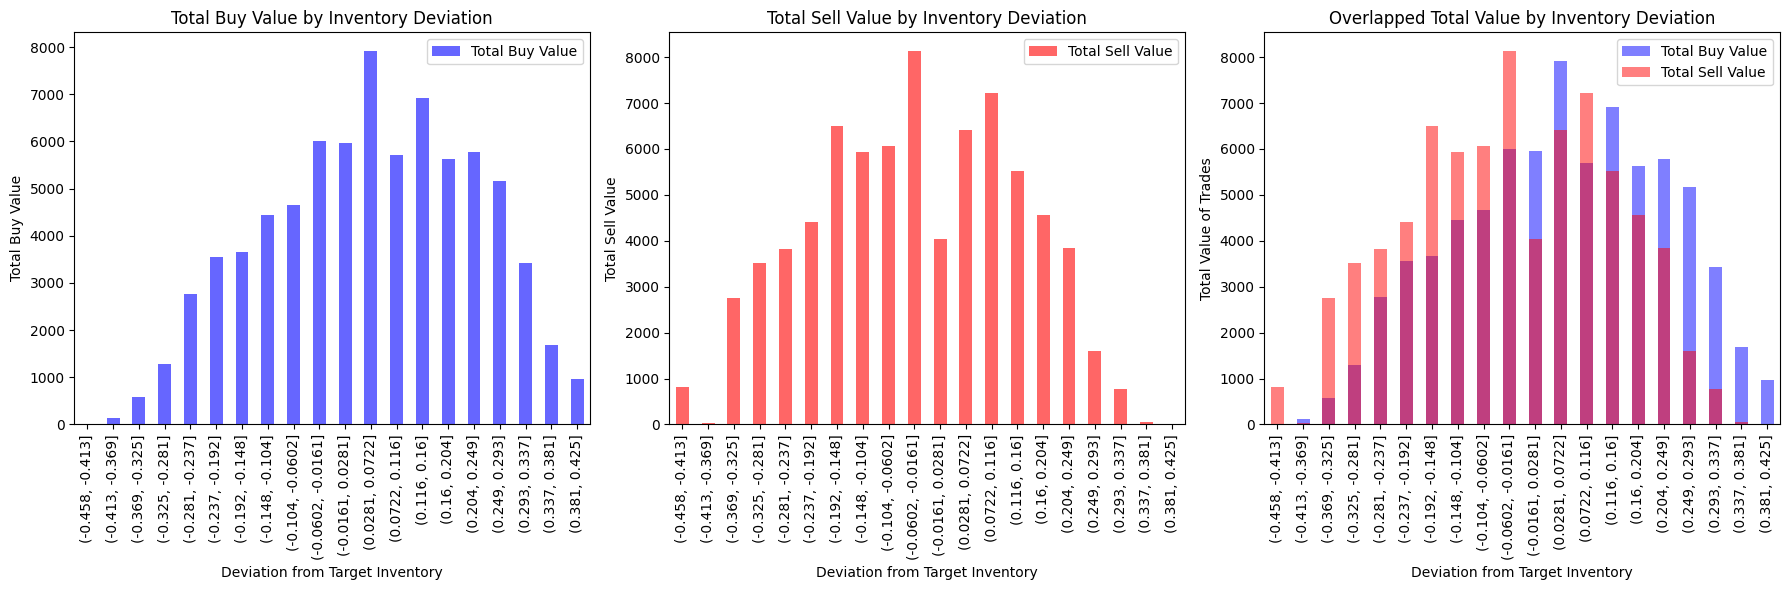

In [112]:
df['fill_value'] = df['fill_qty'] * df['fill_prc']
total_buy_qty_inventory = df[df['side'] == 'B'].groupby('inventory_deviation_category')['fill_value'].sum()
total_sell_qty_inventory = df[df['side'] == 'S'].groupby('inventory_deviation_category')['fill_value'].sum()

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

total_buy_qty_inventory.plot(kind='bar', ax=axes[0], color='blue', alpha=0.6, label='Total Buy Value')
axes[0].set_title('Total Buy Value by Inventory Deviation')
axes[0].set_xlabel('Deviation from Target Inventory')
axes[0].set_ylabel('Total Buy Value')
axes[0].legend()

total_sell_qty_inventory.plot(kind='bar', ax=axes[1], color='red', alpha=0.6, label='Total Sell Value')
axes[1].set_title('Total Sell Value by Inventory Deviation')
axes[1].set_xlabel('Deviation from Target Inventory')
axes[1].set_ylabel('Total Sell Value')
axes[1].legend()

total_buy_qty_inventory.plot(kind='bar', ax=axes[2], color='blue', alpha=0.5, label='Total Buy Value')
total_sell_qty_inventory.plot(kind='bar', ax=axes[2], color='red', alpha=0.5, label='Total Sell Value')
axes[2].set_title('Overlapped Total Value by Inventory Deviation')
axes[2].set_xlabel('Deviation from Target Inventory')
axes[2].set_ylabel('Total Value of Trades')
axes[2].legend()

plt.tight_layout()
plt.show()

In [115]:
total_qty_buys_above_deviation = df[(df['side'] == 'B') & (df['deviation_from_target_inventory'] > 0)]['fill_value'].sum()
total_qty_sells_above_deviation = df[(df['side'] == 'S') & (df['deviation_from_target_inventory'] > 0)]['fill_value'].sum()

total_qty_buys_below_deviation = df[(df['side'] == 'B') & (df['deviation_from_target_inventory'] < 0)]['fill_value'].sum()
total_qty_sells_below_deviation = df[(df['side'] == 'S') & (df['deviation_from_target_inventory'] < 0)]['fill_value'].sum()

print(f"Total value of buys above mean deviation: {total_qty_buys_above_deviation}")
print(f"Total value of sells above mean deviation: {total_qty_sells_above_deviation}")
print(f"Total value of buys below mean deviation: {total_qty_buys_below_deviation}")
print(f"Total value of sells below mean deviation: {total_qty_sells_below_deviation}")

buy_fill_value = df[df['side'] == 'B']['fill_value']
buy_deviation = df[df['side'] == 'B']['deviation_from_target_inventory']
sell_fill_value = df[df['side'] == 'S']['fill_value']
sell_deviation = df[df['side'] == 'S']['deviation_from_target_inventory']

buy_fill_value = buy_fill_value[buy_deviation.notnull()]
buy_deviation = buy_deviation[buy_deviation.notnull()]
sell_fill_value = sell_fill_value[sell_deviation.notnull()]
sell_deviation = sell_deviation[sell_deviation.notnull()]

spearman_corr_buy = stats.spearmanr(buy_fill_value, buy_deviation)
spearman_corr_sell = stats.spearmanr(sell_fill_value, sell_deviation)

print(f"Spearman Correlation - Buy value and Deviation: {spearman_corr_buy.correlation}, P-value: {spearman_corr_buy.pvalue}")
print(f"Spearman Correlation - Sell value and Deviation: {spearman_corr_sell.correlation}, P-value: {spearman_corr_sell.pvalue}")

Total value of buys above mean deviation: 47531.155465
Total value of sells above mean deviation: 32644.606683
Total value of buys below mean deviation: 28713.318686
Total value of sells below mean deviation: 43347.545291999995
Spearman Correlation - Buy value and Deviation: 0.1522100445796139, P-value: 0.0002339169476262496
Spearman Correlation - Sell value and Deviation: 0.07937575616041441, P-value: 0.06455936690679336


Here, the results are also very surprising to me. The Spearman correlation for buy value and deviation is positive and statistically significant, indicating that as the deviation from the target inventory increases, so does the value of the buy orders. A possible interpretation could be that your strategy becomes more aggressive in buying as you exceed the inventory target, perhaps speculating on a continued upward price movement. On the sell side, the Spearman correlation is positive but not statistically significant, implying that sell decisions might be driven by other factors not captured by the inventory deviation alone. This result is interesting, but goes against my intuition of the strategy's behaviour. I believe I need to consult with the strategy's developers to understand this behaviour better.

#### Trading Patterns by Deviation from Fill Value

In this section, I want to investigate if the strategy's trading patterns are influenced by the deviation from the fill value. With this investigation, I intend to find out if the strategy is more likely to buy or sell when the fill value is high or low. 

In [116]:
df = merged_data.copy()

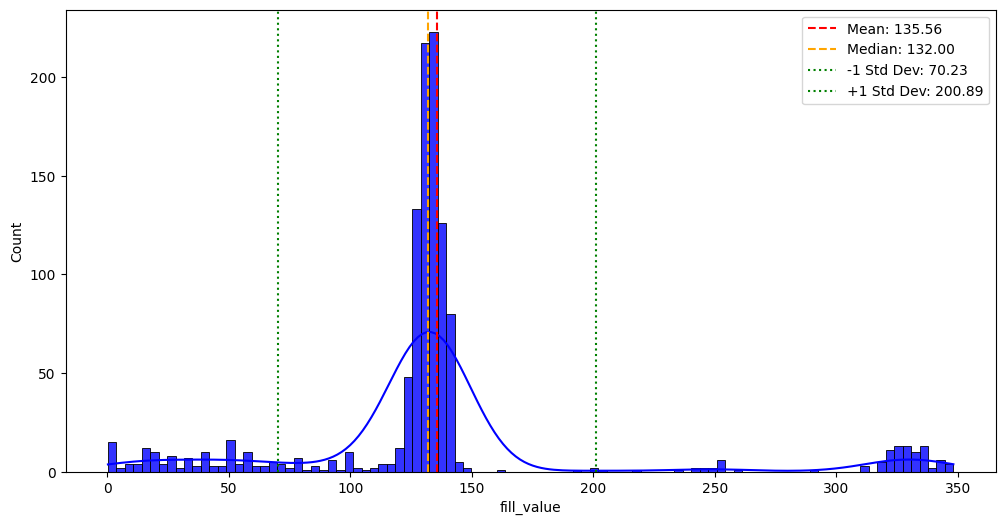

In [141]:
plt.figure(figsize=(12, 6))
sns.histplot(df['fill_value'], bins=100, kde=True, color='blue', alpha=0.8)

mean_fill_value = df['fill_value'].mean()
median_fill_value = df['fill_value'].median()
std_fill_value = df['fill_value'].std()

plt.axvline(mean_fill_value, color='red', linestyle='--', label=f'Mean: {mean_fill_value:.2f}')
plt.axvline(median_fill_value, color='orange', linestyle='--', label=f'Median: {median_fill_value:.2f}')
plt.axvline(mean_fill_value - std_fill_value, color='green', linestyle=':', label=f'-1 Std Dev: {mean_fill_value - std_fill_value:.2f}')
plt.axvline(mean_fill_value + std_fill_value, color='green', linestyle=':', label=f'+1 Std Dev: {mean_fill_value + std_fill_value:.2f}')

plt.legend(loc='upper right')
plt.title = 'Distribution of Fill Value'
plt.xlabel = 'Fill Value'
plt.ylabel = 'Frequency'
plt.show()

In [117]:
def estimate_sample_mean(df, feature, n_samples=1122, sample_size=30):
    sample_means = [df[feature].sample(sample_size, replace=True).mean() for _ in range(n_samples)]
    mean_of_sample_means = np.mean(sample_means)
    return mean_of_sample_means
df['fill_value'] = df['fill_qty'] * df['fill_prc']

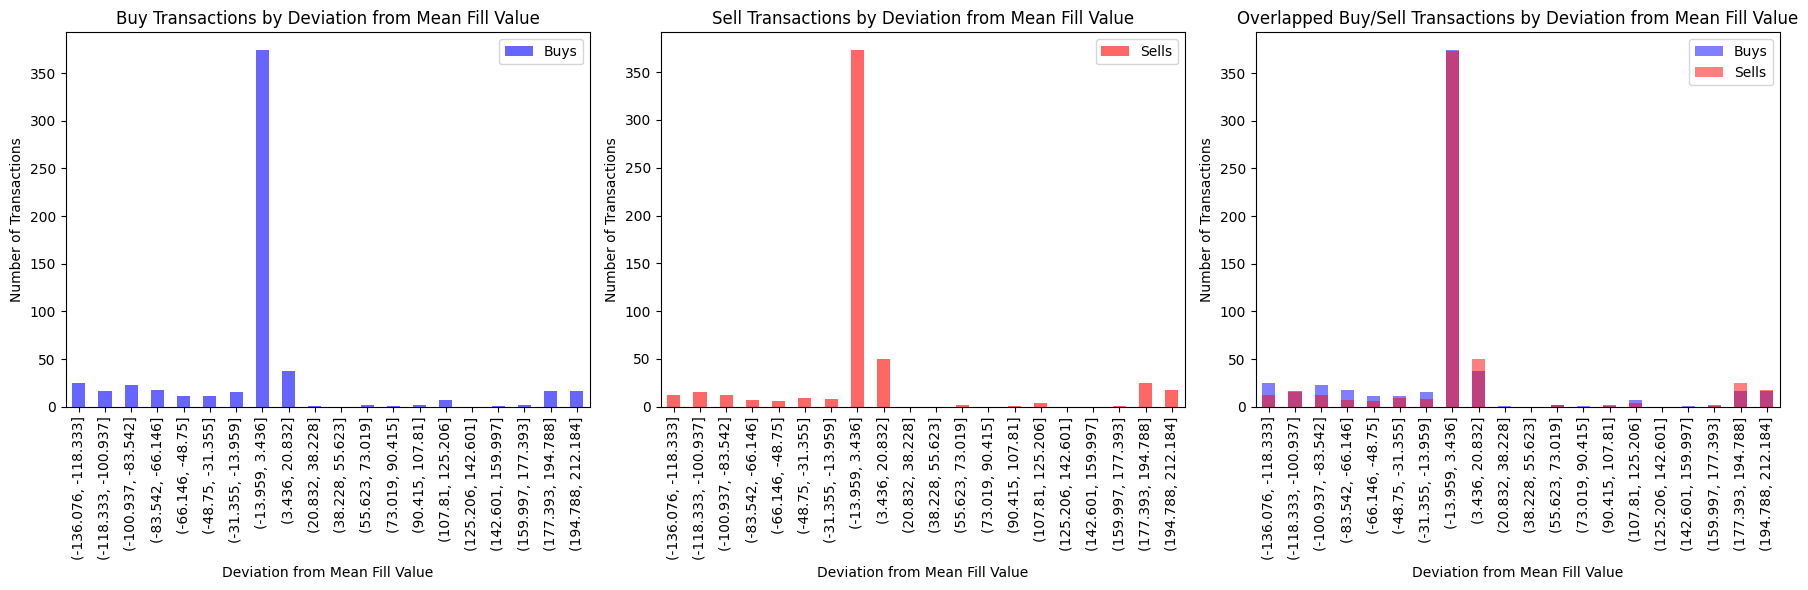

In [143]:
mean_fill_value = estimate_sample_mean(df, 'fill_value')
df['deviation_from_mean_fill_value'] = df['fill_value'] - mean_fill_value
df['deviation_category'] = pd.cut(df['deviation_from_mean_fill_value'], bins=20)

buy_counts = df[df['side'] == 'B'].groupby('deviation_category').size()
sell_counts = df[df['side'] == 'S'].groupby('deviation_category').size()

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Plot buy counts
buy_counts.plot(kind='bar', ax=axes[0], color='blue', alpha=0.6, label='Buys')
axes[0].set_title('Buy Transactions by Deviation from Mean Fill Value')
axes[0].set_xlabel('Deviation from Mean Fill Value')
axes[0].set_ylabel('Number of Transactions')
axes[0].legend()

# Plot sell counts
sell_counts.plot(kind='bar', ax=axes[1], color='red', alpha=0.6, label='Sells')
axes[1].set_title('Sell Transactions by Deviation from Mean Fill Value')
axes[1].set_xlabel('Deviation from Mean Fill Value')
axes[1].set_ylabel('Number of Transactions')
axes[1].legend()

# Plot overlapped buy and sell counts
buy_counts.plot(kind='bar', ax=axes[2], color='blue', alpha=0.5, label='Buys')
sell_counts.plot(kind='bar', ax=axes[2], color='red', alpha=0.5, label='Sells')
axes[2].set_title('Overlapped Buy/Sell Transactions by Deviation from Mean Fill Value')
axes[2].set_xlabel('Deviation from Mean Fill Value')
axes[2].set_ylabel('Number of Transactions')
axes[2].legend()

plt.tight_layout()
plt.show()


In [119]:
# Transactions above and below deviation of 0
buys_above_deviation = df[(df['side'] == 'B') & (df['deviation_from_mean_fill_value'] > 0)].shape[0]
sells_above_deviation = df[(df['side'] == 'S') & (df['deviation_from_mean_fill_value'] > 0)].shape[0]

buys_below_deviation = df[(df['side'] == 'B') & (df['deviation_from_mean_fill_value'] < 0)].shape[0]
sells_below_deviation = df[(df['side'] == 'S') & (df['deviation_from_mean_fill_value'] < 0)].shape[0]

# Display transactions above and below deviation
print(f"Buys above deviation: {buys_above_deviation}, Sells above deviation: {sells_above_deviation}")
print(f"Buys below deviation: {buys_below_deviation}, Sells below deviation: {sells_below_deviation}")

buys_exceed_sells_above = buys_above_deviation > sells_above_deviation
buys_exceed_sells_below = buys_below_deviation > sells_below_deviation

# Print whether buys exceed sells for deviations above and below 0
print(f"Do we buy more than we sell when the deviation is above 0?: {buys_exceed_sells_above}")
print(f"Do we buy more than we sell when the deviation is below 0?: {buys_exceed_sells_below}")

# Calculate when buys exceed sells for each deviation category
combined_counts = pd.DataFrame({'Buys': buy_counts, 'Sells': sell_counts}).fillna(0)
combined_counts['Buys_Exceed'] = combined_counts['Buys'] > combined_counts['Sells']
combined_counts['Sells_Exceed'] = combined_counts['Sells'] > combined_counts['Buys']

below_zero_categories = [i for i in combined_counts.index if i.left < 0]
buys_exceed_below_zero = combined_counts.loc[below_zero_categories]['Buys_Exceed'].sum()
sells_exceed_below_zero = combined_counts.loc[below_zero_categories]['Sells_Exceed'].sum()

above_zero_categories = [i for i in combined_counts.index if i.right > 0]
buys_exceed_above_zero = combined_counts.loc[above_zero_categories]['Buys_Exceed'].sum()
sells_exceed_above_zero = combined_counts.loc[above_zero_categories]['Sells_Exceed'].sum()

print(f"Times buys exceed sells for deviation < 0: {buys_exceed_below_zero}")
print(f"Times sells exceed buys for deviation < 0: {sells_exceed_below_zero}")
print(f"Times buys exceed sells for deviation > 0: {buys_exceed_above_zero}")
print(f"Times sells exceed buys for deviation > 0: {sells_exceed_above_zero}")

Buys above deviation: 146, Sells above deviation: 158
Buys below deviation: 434, Sells below deviation: 385
Do we buy more than we sell when the deviation is above 0?: False
Do we buy more than we sell when the deviation is below 0?: True
Times buys exceed sells for deviation < 0: 8
Times sells exceed buys for deviation < 0: 0
Times buys exceed sells for deviation > 0: 7
Times sells exceed buys for deviation > 0: 3


In [144]:
# Convert 'side' to binary variable
df['side_binary'] = df['side'].map({'B': 1, 'S': 0})

X = sm.add_constant(df[['deviation_from_mean_fill_value']])
y = df['side_binary']

mean_from_fill_qty_model = sm.Logit(y, X).fit()

mean_from_fill_qty_model.summary()

Optimization terminated successfully.
         Current function value: 0.690487
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            side_binary   No. Observations:                 1123
Model:                          Logit   Df Residuals:                     1121
Method:                           MLE   Df Model:                            1
Date:                Mon, 18 Mar 2024   Pseudo R-squ.:                0.003058
Time:                        22:55:04   Log-Likelihood:                -775.42
converged:                       True   LL-Null:                       -777.79
Covariance Type:            nonrobust   LLR p-value:                   0.02919
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                              0.0652      0.060      1.090      0.276      -0.052       0.183
deviation_from_mean_fill_value    -0.0020      0.001     -2.168      0.030      -0.004      -0.000
==================================================================================================
"""

Looking at the plot, there is a noticeable trend where buys and sells are concentrated. Buys seem to be more frequent when the fill value is below the mean, as indicated by the higher number of transactions in categories to the left of the zero deviation point. Conversely, there are more sell transactions when the fill value is above the mean, as evidenced by the higher counts to the right of the zero deviation point. Furthermore, this relationship is statistically significant and negative, as indicated by the logistic regression model, meaning that as the deviation increases (i.e., fill value becomes higher than the mean), the probability of a buy transaction occurring decreases. This may happen when the strategy might want to discretely build a position in the asset or avoid trading fees, but meanwhile prefer to sell in larger values during a bear market to liquidate its position faster and avoid further losses.

#### Trading Patterns in Different Momentums

In this section, I want to investigate if the strategy exhibits different trading patterns in different momentums. I will investigate the trading patterns of the strategy in bull, bear, and neutral markets.

Since this is a market making strategy revolving around a target inventory, I hypothesize that the strategy will make more sell orders during a bear market to quickly turn over inventory to avoid holding declining assets, mitigating losses. On the other hand, I hypothesize that the strategy will make more buy orders during a bull market to capitalize on the appreciation of the asset. 

In [145]:
df = merged_data.copy()

# Necessary for categorizing momentum
df['mid_prc'] = (df['bid_prc'] + df['ask_prc']) / 2
df['mid_prc_pct_change'] = df['mid_prc'].pct_change()

df['momentum_condition'] = df.apply(categorize_momentum_condition, axis=1)

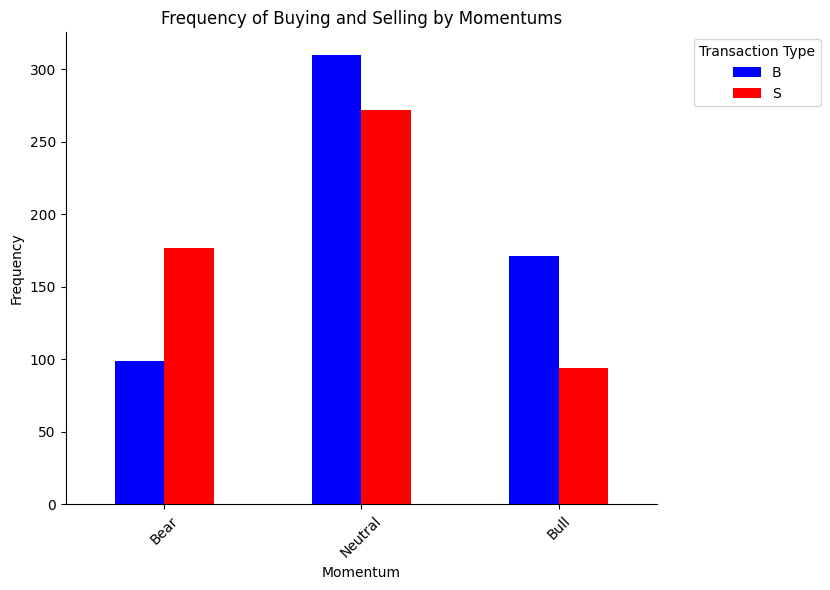

In [146]:
df['momentum_condition'] = pd.Categorical(df['momentum_condition'], categories=['Bear', 'Neutral', 'Bull'], ordered=True)

buy_sell_freq_by_momentum_cond = df.groupby('momentum_condition')['side'].value_counts().unstack()
buy_sell_freq_by_momentum_cond = buy_sell_freq_by_momentum_cond.reindex(['Bear', 'Neutral', 'Bull'])

fig, ax = plt.subplots(figsize=(10, 6))

colors = ['blue', 'red']
buy_sell_freq_by_momentum_cond.plot(kind='bar', ax=ax, color=colors)

ax.set_title('Frequency of Buying and Selling by Momentums')
ax.set_xlabel('Momentum')
ax.set_ylabel('Frequency')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

ax.legend(title='Transaction Type', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()


In [147]:
buy_sell_freq_by_momentum_cond

side                  B    S
momentum_condition          
Bear                 99  177
Neutral             310  272
Bull                171   94

In [148]:
chi2, p, dof, expected = stats.chi2_contingency(buy_sell_freq_by_momentum_cond)

print(f"Chi2 statistic: {chi2}, P-value: {p}")
print(f"Degrees of freedom: {dof}")
print(f"Expected frequencies if no difference in momentum:\n{pd.DataFrame(expected, columns=buy_sell_freq_by_momentum_cond.columns, index=buy_sell_freq_by_momentum_cond.index)}")


Chi2 statistic: 45.728746890411735, P-value: 1.1752459968849416e-10
Degrees of freedom: 2
Expected frequencies if no difference in momentum:
side                         B           S
momentum_condition                        
Bear                142.546750  133.453250
Neutral             300.587711  281.412289
Bull                136.865539  128.134461


From the barplot, we can observe that in a bear momentum, there are significantly more sell transactions than buy transactions. This suggests a tendency to liquidate positions or take a short stance when the market trend is downward. In a neutral momentum condition, buying transactions slightly outnumber selling transactions, indicating a more balanced but still slightly positive bias in trade activity. In a bull momentum condition, buying transactions dominate selling transactions by a wide margin, showing a strong inclination to accumulate positions or take a long stance when the market trend is upward.

The Chi-squared test results, with a statistic of `45.73` and a very low P-value (approximately `1.18e-10`), indicate that there is a statistically significant difference in the frequency of buying and selling across the three momentum conditions. The observed counts deviate significantly from these expected counts, confirming that there is a dependency between the market momentum condition and the strategy's propensity to buy or sell. The strategy seems to be momentum-driven, favoring buying in rising markets and selling in falling markets. This aligns with my initial hypothesis, as the results show that the strategy is more likely to buy in bull markets and sell in bear markets. Note that an asset when the price is far below the mean can still have a high positive percentage change, and vice versa. One example where this might be the case is when the price of an asset rallies after a market crash.

Note that my definition of bear, neutral, and bull momentums stem from the definition of recession and growth in economics, which is when GDP growth is negative and positive respectively. 

I want to take it a step further an investigate if the quantity of buy and sell orders follows a similar pattern. This is because, just because we have more buy transactions, does not mean the total value of buy transactions is higher than the total value of sell transactions.

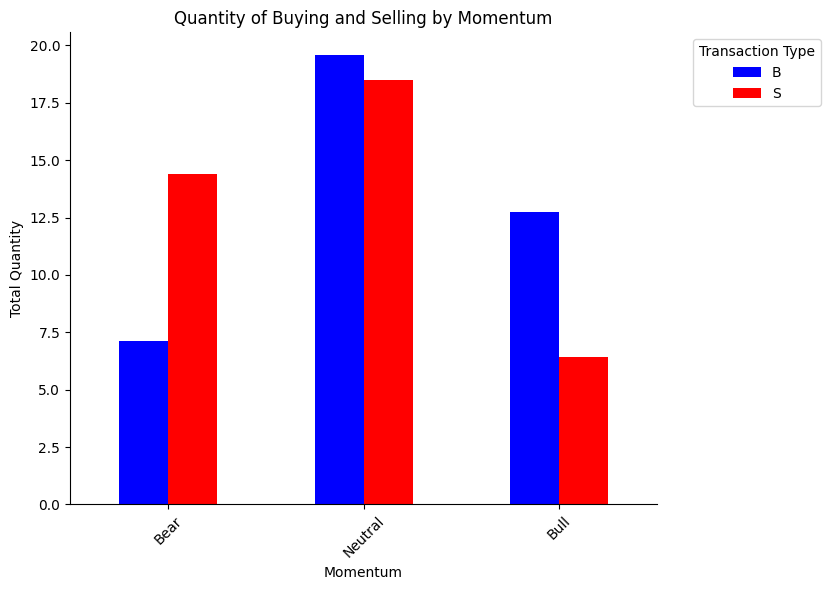

In [149]:
qty_by_momentum_cond_side = df.groupby(['momentum_condition', 'side'])['fill_qty'].sum().unstack()

fig, ax = plt.subplots(figsize=(10, 6))
colors = ['blue', 'red']
qty_by_momentum_cond_side.plot(kind='bar', ax=ax, color=colors)

ax.set_title('Quantity of Buying and Selling by Momentum')
ax.set_xlabel('Momentum')
ax.set_ylabel('Total Quantity')
ax.set_xticklabels(qty_by_momentum_cond_side.index.categories, rotation=45)

ax.legend(title='Transaction Type', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

In [150]:
qty_by_momentum_cond_side

side                      B        S
momentum_condition                  
Bear                 7.1154  14.3790
Neutral             19.5865  18.4913
Bull                12.7348   6.4260

In [152]:
buy_fill_qty_bear = df[(df['side'] == 'B') & (df['momentum_condition'] == 'Bear')]['fill_qty']
buy_fill_qty_neutral = df[(df['side'] == 'B') & (df['momentum_condition'] == 'Neutral')]['fill_qty']
buy_fill_qty_bull = df[(df['side'] == 'B') & (df['momentum_condition'] == 'Bull')]['fill_qty']

sell_fill_qty_bear = df[(df['side'] == 'S') & (df['momentum_condition'] == 'Bear')]['fill_qty']
sell_fill_qty_neutral = df[(df['side'] == 'S') & (df['momentum_condition'] == 'Neutral')]['fill_qty']
sell_fill_qty_bull = df[(df['side'] == 'S') & (df['momentum_condition'] == 'Bull')]['fill_qty']

# Use the Kruskal-Wallis H Test since distribution of the data is not normal and it is continuous
kruskal_result_buys = kruskal(buy_fill_qty_bear, buy_fill_qty_neutral, buy_fill_qty_bull)
kruskal_result_sells = kruskal(sell_fill_qty_bear, sell_fill_qty_neutral, sell_fill_qty_bull)

print(f"Kruskal-Wallis H Test for Buys: Statistic = {kruskal_result_buys.statistic}, P-value = {kruskal_result_buys.pvalue}")
print(f"Kruskal-Wallis H Test for Sells: Statistic = {kruskal_result_sells.statistic}, P-value = {kruskal_result_sells.pvalue}")

Kruskal-Wallis H Test for Buys: Statistic = 7.653567870144326, P-value = 0.02177954755580384
Kruskal-Wallis H Test for Sells: Statistic = 12.610356866182848, P-value = 0.0018268201744904725


The plot shows similar results and we can see that in a bear momentum the quantity of selling is notably higher than buying, which is typical as investors may be offloading assets expecting further declines. Moreover, buying and selling are roughly equivalent in a neutral momentum, suggesting a balance in trade volumes. Finally, in a bull momentum, buying dominates selling, indicating investor 
confidence and the accumulation of assets in anticipation of price increases.

The results of the tests suggest that market momentum conditions do affect trading behavior in statistically significant ways. In bear momentums, selling significantly outweighs buying, which may reflect a pessimistic outlook among investors. In bull momentums, buying significantly exceeds selling, indicating a more optimistic market sentiment. In neutral momentums, the behavior is balanced, which may be due to uncertainty or a lack of strong market signals.

#### Trading Patterns in Different Volatility Conditions

In this section, I will investigate the behaviour of the strategy in different volatility conditions. Here, I will use `mid_prc` to calculate volatility since it is more representative of the volatility of the general market.

In [153]:
df = merged_data.copy()
df['date'] = df.index.date
# Using `mid_prc` to calculate the volatility of the Mid Price.
df['mid_prc'] = (df['bid_prc'] + df['ask_prc']) / 2
df['mid_prc_pct_change'] = df['mid_prc'].pct_change()
# The reason I am using `mid_prc` instead of the `fill_prc` is because `fill_pcr` data reflects the prices of buys and sells, so it is difficult to obtain a gauge the average trading volatility from this data.
mid_prc_daily_volatility = df.groupby('date')['mid_prc_pct_change'].std() * 100

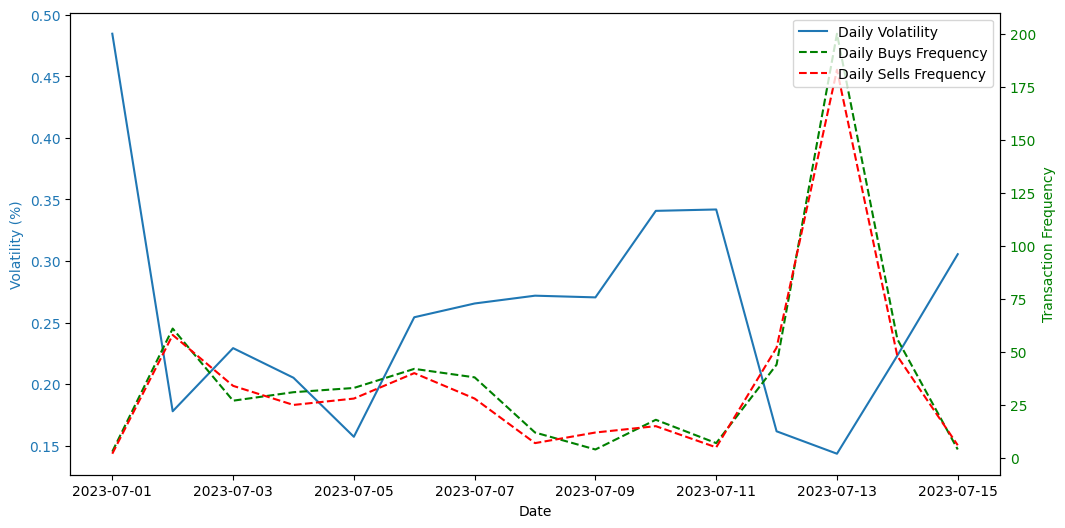

In [154]:
daily_buys = df[df['side'] == 'B'].groupby('date').size()
daily_sells = df[df['side'] == 'S'].groupby('date').size()

daily_data_volatility = pd.DataFrame({
    'volatility': mid_prc_daily_volatility,
    'buys': daily_buys,
    'sells': daily_sells
})

fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.plot(daily_data_volatility.index, daily_data_volatility['volatility'], color=color, label='Daily Volatility')
ax1.set_xlabel('Date')
ax1.set_ylabel('Volatility (%)', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:green'
ax2.plot(daily_data_volatility.index, daily_data_volatility['buys'], color='green', linestyle='--', label='Daily Buys Frequency')
ax2.plot(daily_data_volatility.index, daily_data_volatility['sells'], color='red', linestyle='--', label='Daily Sells Frequency')
ax2.set_ylabel('Transaction Frequency', color='green')
ax2.tick_params(axis='y', labelcolor='green')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

plt.title = 'Daily Volatility vs. Transaction Frequency Over Time'
plt.show()

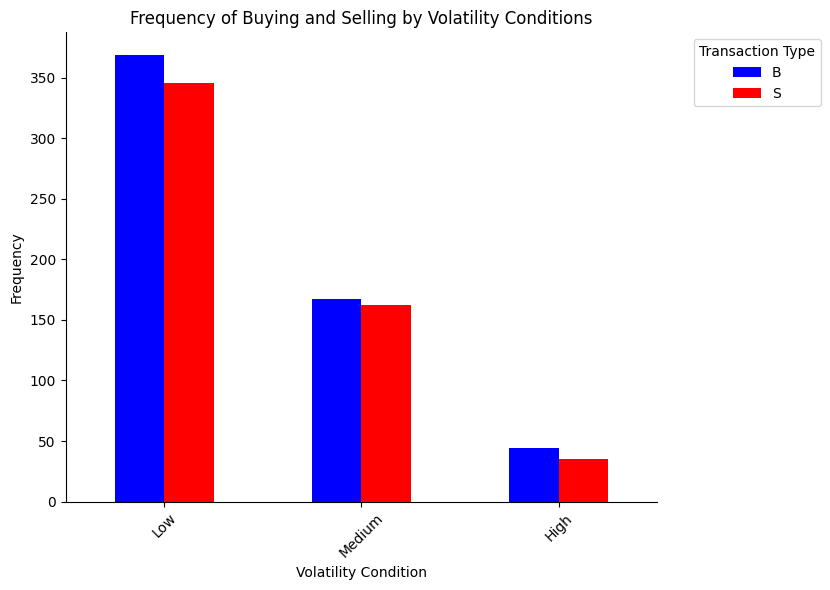

In [155]:
volatility_bins = pd.qcut(mid_prc_daily_volatility, q=3, labels=['Low', 'Medium', 'High'])
df['volatility_category'] = df['date'].map(volatility_bins)

buy_sell_freq_by_volatility = df.groupby('volatility_category')['side'].value_counts().unstack()

fig, ax = plt.subplots(figsize=(10, 6))
colors = ['blue', 'red']
buy_sell_freq_by_volatility.plot(kind='bar', ax=ax, color=colors)

ax.set_title('Frequency of Buying and Selling by Volatility Conditions')
ax.set_xlabel('Volatility Condition')
ax.set_ylabel('Frequency')
ax.set_xticklabels(buy_sell_freq_by_volatility.index, rotation=45)

ax.legend(title='Transaction Type', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

In [156]:
spearman_corr_buys, spearman_p_value_buys = spearmanr(daily_data_volatility['volatility'], daily_data_volatility['buys'])
spearman_corr_sells, spearman_p_value_sells = spearmanr(daily_data_volatility['volatility'], daily_data_volatility['sells'])

print(f"Spearman Correlation (Buys vs. Volatility): {spearman_corr_buys:.3f}, p-value: {spearman_p_value_buys:.3f}")
print(f"Spearman Correlation (Sells vs. Volatility): {spearman_corr_sells:.3f}, p-value: {spearman_p_value_sells:.3f}")

Spearman Correlation (Buys vs. Volatility): -0.826, p-value: 0.000
Spearman Correlation (Sells vs. Volatility): -0.860, p-value: 0.000


The first plot shows the daily volatility of the mid-price as a percentage and overlays the daily frequency of buy and sell transactions. We can observe that there is a clear inverse relationship between volatility and the frequency of both buys and sells. The peaks in volatility do not correspond with peaks in transaction frequency. Instead, they generally correspond with the lows in transaction frequency. Furthermore, the lowest points in volatility show some of the highest frequencies of transaction activity. 

The second plot shows the frequency of buying and selling by volatility conditions. This bar chart categorizes volatility into low, medium, and high, showing the frequency of buys and sells. Both buying and selling transactions are highest in low volatility conditions. Moreover, the frequency of transactions decreases as volatility increases, with the least transactions occurring in high volatility conditions.

Finally, the Spearman tests show that both correlations are strongly negative, which confirms the inverse relationship observed in the first plot. The negative correlations indicate that as volatility increases, the frequency of both buying and selling transactions decreases. The p-values being `0.000` suggest that the results are highly statistically significant, meaning there's a very low probability that this inverse relationship is due to random chance.

An interpretation of this result might be that the trading strategy seems to be risk-averse with respect to market volatility. The behavior indicates a preference for executing trades under conditions of low volatility. This could mean that the strategy is designed to minimize risk by avoiding significant market moves that can accompany high volatility periods. An interesting behaviour is that the strong negative correlations and the corresponding plots suggest that the strategy might be programmed to reduce exposure or trading activities as volatility increases. This could be a mechanism to protect against market uncertainty or to avoid slippage that can be more pronounced during volatile periods. Furthermore, the strategy might also be utilizing low volatility periods to build positions or execute trades that might be too risky or costly during high volatility due to wider spreads or rapid price movements. 

#### Trading Patterns in Different Liquidity (Spread)

In this section, I will investigate the effect of the bid-ask spread on the trading patterns of the strategy. Since this is a market making strategy which must continue to trade in all liquidity conditions, I suspect that there will be no statistically significant correlation between the bid-ask spread and the trading patterns of the strategy.

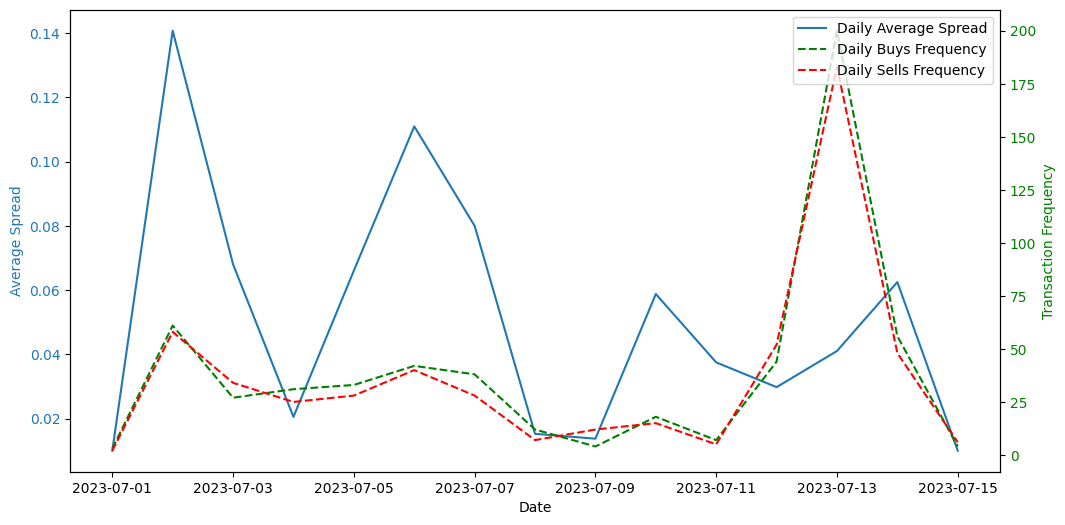

Spearman Correlation (Buys) and p-value: Correlation=0.693, p-value=0.004
Spearman Correlation (Sells) and p-value: Correlation=0.665, p-value=0.007


In [157]:
df = merged_data.copy()
df['date'] = df.index.date
df['spread'] = df['ask_prc'] - df['bid_prc']

daily_avg_spread = df.groupby('date')['spread'].mean()
daily_buys = df[df['side'] == 'B'].groupby('date').size()
daily_sells = df[df['side'] == 'S'].groupby('date').size()

daily_data = pd.DataFrame({
    'avg_spread': daily_avg_spread,
    'buys': daily_buys,
    'sells': daily_sells
}).fillna(0)

fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.plot(daily_data.index, daily_data['avg_spread'], color=color, label='Daily Average Spread')
ax1.set_xlabel('Date')
ax1.set_ylabel('Average Spread', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
ax2.plot(daily_data.index, daily_data['buys'], color='green', linestyle='--', label='Daily Buys Frequency')
ax2.plot(daily_data.index, daily_data['sells'], color='red', linestyle='--', label='Daily Sells Frequency')
ax2.set_ylabel('Transaction Frequency', color='green')
ax2.tick_params(axis='y', labelcolor='green')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

plt.title = 'Spread vs. Transaction Frequency Over Time'
plt.show()

spearman_corr_buys, spearman_p_value_buys = stats.spearmanr(daily_data['avg_spread'], daily_data['buys'])
spearman_corr_sells, spearman_p_value_sells = stats.spearmanr(daily_data['avg_spread'], daily_data['sells'])

print(f"Spearman Correlation (Buys) and p-value: Correlation={spearman_corr_buys:.3f}, p-value={spearman_p_value_buys:.3f}")
print(f"Spearman Correlation (Sells) and p-value: Correlation={spearman_corr_sells:.3f}, p-value={spearman_p_value_sells:.3f}")

From the plot, we can see that both buy and sell transaction frequencies seem to correlate with the average spread to some extent. Notably, transaction frequencies appear to peak around the times when the average spread also peaks. This could indicate that the trading strategy is more active during periods of higher spread. There are moments when transaction frequencies move in the opposite direction to the average spread. However, these instances seem less pronounced compared to when they move in tandem.

Moreover, the Spearman tests show that both correlation coefficients are positive and statistically significant, suggesting a positive correlation between the bid-ask spread and transaction frequency for both buys and sells. The positive correlation indicates that as the spread increases, so does the frequency of buy and sell transactions, contrary to the initial hypothesis. Since higher spreads are indicative of lower liquidity and possibly higher volatility, the strategy seems to capitalize on these conditions rather than avoiding them.

Overall, this is an interesting behaviour of the strategy where it seems to be more active during periods of higher spreads. This might be because higher spreads can offer greater profit opportunities for market makers. The strategy seems to be exploiting the lack of liquidity or higher volatility (often associated with higher spreads) to potentially engage in arbitrage or to provide liquidity for a premium. While the strategy has to trade in all liquidity conditions, it does not seem to do so uniformly. Instead, it varies its frequency depending on the average spread. The pattern of increased activity in higher spread environments is indicative of a strategy that seeks to profit from providing liquidity when it is most valuable. This is characteristic of a strategy designed to take advantage of the greater price discrepancies between buyers and sellers.

#### Trading Patterns by Trading Fees

In this section, I had the idea to investigate if the trading fees have an impact on the trading patterns of the strategy. I hypothesize that the trading fees do have an impact on the trading patterns of the strategy to maintain lower costs.

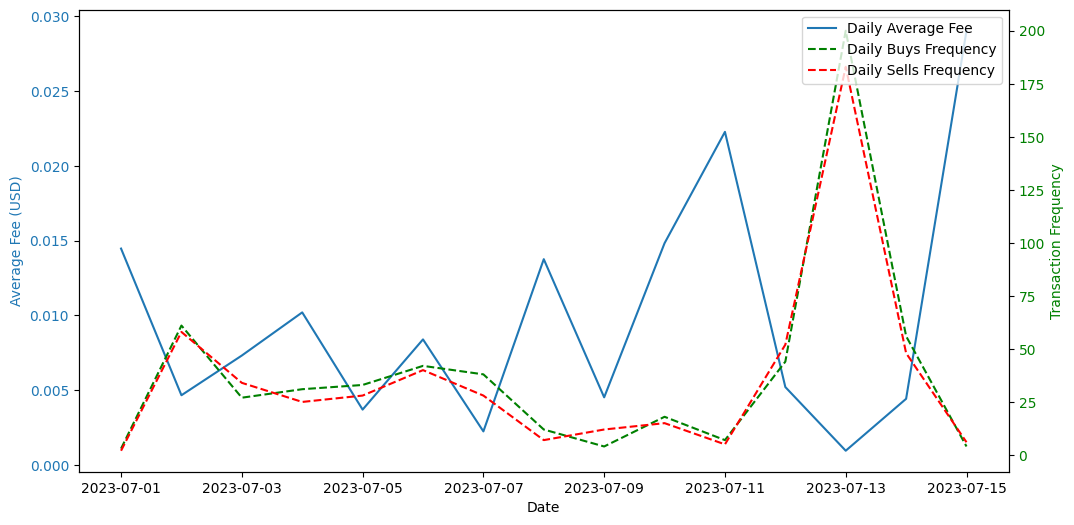

Spearman Correlation (Buys) and p-value: Correlation=-0.686, p-value=0.005
Spearman Correlation (Sells) and p-value: Correlation=-0.710, p-value=0.003


In [158]:
df['total_fee'] = df['fee'] * df['fee_ccy_usd_rate']

daily_avg_fee = df.groupby('date')['total_fee'].mean()
daily_buys = df[df['side'] == 'B'].groupby('date').size()
daily_sells = df[df['side'] == 'S'].groupby('date').size()

daily_data_fees = pd.DataFrame({
    'avg_fee': daily_avg_fee,
    'buys': daily_buys,
    'sells': daily_sells
})

fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.plot(daily_data_fees.index, daily_data_fees['avg_fee'], color=color, label='Daily Average Fee')
ax1.set_xlabel('Date')
ax1.set_ylabel('Average Fee (USD)', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:green'
ax2.plot(daily_data_fees.index, daily_data_fees['buys'], color='green', linestyle='--', label='Daily Buys Frequency')
ax2.plot(daily_data_fees.index, daily_data_fees['sells'], color='red', linestyle='--', label='Daily Sells Frequency')
ax2.set_ylabel('Transaction Frequency', color='green')
ax2.tick_params(axis='y', labelcolor='green')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

plt.title = 'Fees vs. Transaction Frequency Over Time'
plt.show()

# Step 4: Spearman Correlation Analysis
spearman_corr_buys_fee, spearman_p_value_buys_fee = stats.spearmanr(daily_data_fees['avg_fee'], daily_data_fees['buys'])
spearman_corr_sells_fee, spearman_p_value_sells_fee = stats.spearmanr(daily_data_fees['avg_fee'], daily_data_fees['sells'])

print(f"Spearman Correlation (Buys) and p-value: Correlation={spearman_corr_buys_fee:.3f}, p-value={spearman_p_value_buys_fee:.3f}")
print(f"Spearman Correlation (Sells) and p-value: Correlation={spearman_corr_sells_fee:.3f}, p-value={spearman_p_value_sells_fee:.3f}")

In [159]:
highest_fee = df['total_fee'].max()
print(f"{highest_fee:.2f}")

0.08


The plot shows that the average daily fee, buys and sells fluctuate over time. Notably, there is a sharp fall in the average fee on July 13. The frequency of buys and sells appears to increase when the average fee is low, particularly on July 13. This leads me to suspect the trend that the frequency of buys and sells might be inversely correlated with the average fee. 

The Spearman tests confirm this as the correlation coefficient for buys and fees is -0.686, and for sells and fees is -0.710. Both correlations are negative and statistically significant, indicating that as fees increase, the frequency of both buys and sells decreases. This suggests that the strategy might be adjusting its behavior to reduce costs and preserve profit margins as fees increase. The strong negative correlations and the corresponding plots suggest that the strategy might be programmed to reduce exposure or trading activities as fees increase. This could be a mechanism to protect against higher costs or to avoid slippage that can be more pronounced during high fee periods. This result aligns with the IceBerg orders we observed in the `fills_data` dataset, which are large orders that are broken down into smaller orders to avoid large fees. 

Moreover, if we assume that the highest trading fee in the data set is the maximum trading fee before the strategy splits the order into smaller orders, then it may be that `0.08` USD is the critical value before the strategy splits the order into IceBerg orders to avoid higher fees. This is just a speculation, and I would need more information to confirm this such as more data entries to confirm if there may be trades with trading fees higher than `0.08` USD as a counter example.

### Implementing Classification Models

In this section, I want to build a decision tree, random forest, and logistic regression model to classify when the strategy buys and sells and compare their results. The goal of my classification models is not to build a predictive model for when the strategy buys and sells, but to see if the models can provide further insight into the trading patterns of the strategy.

The reason I am implementing classification models is because I believe the question of investigating the behaviour of the strategy can be rephrased to the problem of developing a classification model which can determine if the strategy buys or sells based on the features of the data. By investigating the classification models, I can identify which features are correlated with the strategy's decision to buy or sell and see if it is consistent with my previous analysis.

In [ ]:
# First I must prepare the dataset
df = merged_data.copy()

In [ ]:
# remove pnl related columns and more since I am interested in determining if the trade is likely to be a buy or sell
df.drop(['order_id', 'fee_ccy', 'fill_id', 'symbol_x', 'exch', 'symbol_y', 'trade_pnl', 'cumulative_trade_pnl',
        'inventory_pnl', 'cumulative_inventory_pnl', 'net_pnl', 'cumulative_net_pnl'], axis=1, inplace=True)

In [ ]:
# add features to the dataset that I believe will be useful in predicting the trade type
df['mid_prc'] = (df['bid_prc'] + df['ask_prc']) / 2
df['mid_prc_pct_change'] = df['mid_prc'].pct_change()
df['market_condition'] = df.apply(categorize_momentum_condition, axis=1)
df['spread'] = df['ask_prc'] - df['bid_prc']
df['total_fee'] = df['fee'] * df['fee_ccy_usd_rate']

# prune out overlapping features
# removing balance and balance value since we identified deviation from balance is not significant
df = df.drop(['bid_prc', 'ask_prc', 'fee', 'fee_ccy_usd_rate', 'balance_value', 'mid_prc_pct_change', 'balance', 'liquidity', 'fill_prc'], axis=1)
# add dummy encoding for market_condition
df = pd.get_dummies(df, columns=['market_condition'])
# remove first row since it will have NaN values
df = df.iloc[1:]
df

In [ ]:
# Since I am more interested in the relationships 
# in the data than the accuracy of the model,
# I thought engineering my features to be categorical 
# would help serve my purpose best.
mean_fill_qty = estimate_sample_mean(df, 'fill_qty')
mean_mid_prc = estimate_sample_mean(df, 'mid_prc')
mean_spread = estimate_sample_mean(df, 'spread')

df['deviation_from_mean_fill_qty'] = df['fill_qty'] - mean_fill_qty
df['deviation_from_mean_mid_prc'] = df['mid_prc'] - mean_mid_prc
df['deviation_from_mean_spread'] = df['spread'] - mean_spread
df['is_total_fee_zero'] = (df['total_fee'] == 0).astype(int)

categorical_columns = ['market_condition_Bear', 'market_condition_Bull', 'market_condition_Neutral']

for col in categorical_columns:
    df[col] = df[col].astype('category').cat.codes

columns_to_drop = ['fill_qty', 'mid_prc', 'spread', 'total_fee']
df.drop(columns=columns_to_drop, inplace=True)

df

In [ ]:
df['side_binary'] = df['side'].map({'B': 1, 'S': 0})
y = df['side_binary']
X = df.drop(columns=['side', 'side_binary'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#### Decision Tree

In [ ]:
clf = DecisionTreeClassifier(random_state=42)

param_grid = {'max_depth': range(1, 20)}

# Identify the ideal depth of the tree
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best tree depth:", grid_search.best_params_['max_depth'])

best_clf = grid_search.best_estimator_
y_pred = best_clf.predict(X_test)
decision_tree_accuracy = accuracy_score(y_test, y_pred)
print(f"Test set accuracy: {decision_tree_accuracy * 100:.2f}%")


In [ ]:
feature_importances = best_clf.feature_importances_
importances = pd.Series(feature_importances, index=X.columns)
sorted_importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sorted_importances.plot(kind='bar')
plt.title = 'Feature Importance in Decision Tree'
plt.ylabel = 'Importance Score'
plt.xlabe = 'Features'
plt.show()

In [ ]:
plt.figure(figsize=(20, 10)) # encode into 1 
plot_tree(best_clf, filled=True, feature_names=X.columns, class_names=['Sell', 'Buy'], proportion=True)
plt.show()

Observing the results of the decision tree model, we can see that the model has a  poor performance of `59.05%`. Furthermore, the decision tree's optimum depth is a max depth of 1, which means it makes a decision by only asking one question. In this case, the question is whether the momentum is bearish `(market_condition_Bear <= 0.5)`. However, even after the branching, the Gini impurity is still high, indicating that the decision tree is not able to classify the data well. This is a sign that the decision tree model is not able to capture the information in the data well.

The only point of interest in the decision tree model is the samples percentages, which shows the proportion of total samples that went to each side of the split. 74.5% of the samples have a `market_condition_Bear` value of less than or equal to 0.5 and are classified as Buy, while the remaining 25.5% are classified as Sell. This means when the momentum is not bearish, the strategy is more likely to buy. This coincides with the findings when we identified trading patterns in different momentums and found that buys occur the least in bear markets.

#### Random Forest

In [ ]:
number_of_variables = X_train.shape[1]
random_forest_errors = np.zeros(number_of_variables)
oob_scores = []

for variable_count in range(1, number_of_variables + 1):
    # Train a random forest model with a varying number of variables (max_features)
    clf = RandomForestClassifier(n_estimators=500, max_features=variable_count, oob_score=True, random_state=42, n_jobs=-1)
    clf.fit(X_train, y_train)
    
    oob_error = 1 - clf.oob_score_
    random_forest_errors[variable_count - 1] = oob_error
    oob_scores.append(clf.oob_score_)

optimal_variables = np.argmin(random_forest_errors) + 1  # Adding 1 because index starts at 0
print(f"Optimal number of variables (max_features): {optimal_variables}")

optimal_clf = RandomForestClassifier(n_estimators=500, max_features=optimal_variables, oob_score=True, random_state=42, n_jobs=-1)
optimal_clf.fit(X_train, y_train)

y_pred = optimal_clf.predict(X_test)
random_forest_accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on test set: {random_forest_accuracy * 100:.2f}%")

In [ ]:
feature_importances = optimal_clf.feature_importances_

features_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

features_df = features_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(features_df['Feature'], features_df['Importance'], color='skyblue')
plt.xlabel = 'Importance'
plt.title= 'Feature Importances in RandomForest Classifier'
plt.gca().invert_yaxis()
plt.show()

The random forest model has a better performance of `62.61%` than the decision tree model. However, the performance is still not high as I would want it to be. The model identified that the optimal number of variables is 7 with `deviation_from_mean_mid_prc`, and `deviation_from_mean_fill_qty` being the top two most important features according to the random forest model. This is interesting to me because momentums is not one of the top most important features, which differs from the decision tree model. Perhaps the combination of these two features, `deviation_from_mean_mid_prc`, and `deviation_from_mean_fill_qty`, reveal a pattern for a trading discount or market trends that a simple decision tree model cannot capture.

#### Logistic Regression

In [ ]:
X_train_const = sm.add_constant(X_train)

logistic_model = sm.Logit(y_train, X_train_const).fit()
p_value_threshold = 0.05
while True:
    p_values = logistic_model.pvalues
    p_values = p_values.drop('const')  # Ignore the intercept's p-value for this process
    max_p_value = p_values.max()
    if max_p_value < p_value_threshold:
        break  # Stop if all p-values are below the threshold
    else:
        # Remove the feature with the highest p-value
        feature_to_remove = p_values.idxmax()
        X_train_const = X_train_const.drop(columns=[feature_to_remove])
        logistic_model = sm.Logit(y_train, X_train_const).fit(disp=0)  # Refit logistic_model without the feature
        print(f"Removed: {feature_to_remove}, Refitting logistic_model...\n")

print("Final logistic_model:")
print(logistic_model.summary())

X_test_const = sm.add_constant(X_test[X_train_const.columns[1:]], has_constant='add')
y_pred_prob = logistic_model.predict(X_test_const)

# Compute the accuracy
logistic_accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of logistic model: {logistic_accuracy * 100:.2f}%")

In [ ]:

logistic_intercept = logistic_model.params[0]
logistic_coefficients = logistic_model.params[1:]

logistic_equation = f"logit(P) = {logistic_intercept:.4f} + "
logistic_equation += " + ".join([f"{coef:.4f} * {feat}" for feat, coef in zip(logistic_coefficients.index, logistic_coefficients.values)])

logistic_equation


The logistic regression's p-value, `4.809e-08`, indicates that the model is statistically significant with an accuracy of `62.61%`. However, it has a Pseudo R-squared value of `0.03097`, which is really low. This means that though the model has some predictive power, there is a lot of room for improvement. 

Observing the coefficients of the logistic regression model, `const` has a log-odds of `0.1137`, which translates to a probability of about `52.8%` on my calculator, telling is that the strategy is slightly more likely to buy than sell during neutral momentums, which is similar to what we found in our analysis on trading patterns by momentums. The negative coefficient on `market_condition_Bear` and positive coefficient on `market_condition_Bull` tells us that the strategy is more likely to sell during bear markets and buy during bull markets. This is also consistent with our previous analysis on trading patterns by momentums. Again, the p-value of the model tells us this relationship is statistically significant. However, the R-squared value of the model is low, indicating that the model does not explain a lot of the variance in the data. Ideally, I would like access to more features like external market data to see if the trading strategy pairs (i.e pairs trading) with external market data to make decisions.

In [ ]:
accuracy_dt = decision_tree_accuracy  
accuracy_rf = random_forest_accuracy  
accuracy_logreg = logistic_accuracy 

models = ['Decision Tree', 'Random Forest', 'Logistic Regression']
accuracies = [accuracy_dt, accuracy_rf, accuracy_logreg]

plt.figure(figsize=(8, 5))
plt.bar(models, accuracies, color=['blue', 'green', 'orange'])
plt.xlabel = 'Model'
plt.ylabel = 'Accuracy'
plt.title = 'Comparison of Model Accuracies'
plt.ylim(0, 1) 
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center')
plt.show()

Here, we can see that the random forest and logistic regression models have similar performance despite prioritizing different features. For future work, I would like to investigate if the combination of the features identified by the random forest model and the logistic regression model can improve the performance of the models.

## Deeper Dive on Market Impact: Investigating the impact of the trading strategy on the market

In this section, I will investigate the impact of the strategy on the market. The main question I will be answering here is to figure out what tends to happen to the market prices after a fill happens.

In [ ]:
market_df = market_data.copy()
df = merged_data.copy()

### Investigating Average Price Changes after Order Fills 

In this section, I want to investigate the average price change of the asset after the strategy makes a fill. As a premilimary step, I will investigate the average price change in the mid price after the strategy makes a fill.


In [ ]:
# Calculate the effect of a fill on the market price by getting the 1 minute window price change after a fill occurs
market_df = market_df.sort_index()
df = df.sort_index()
df.index = df.index.tz_localize(None)
market_df.index = market_df.index.tz_localize(None)
time_window = pd.Timedelta(minutes=1)
price_change_fill_effect = []
price_pct_change_fill_effect = []

for idx, row in df.iterrows():
    end_time = idx + time_window
    post_fill_market_data = market_df.loc[idx:end_time]
    
    # Calculate the price change if there is any market data in the window
    if not post_fill_market_data.empty:
        initial_mid_price = (row['bid_prc'] + row['ask_prc']) / 2
        final_mid_price = (post_fill_market_data.iloc[-1]['bid_prc'] + post_fill_market_data.iloc[-1]['ask_prc']) / 2
        price_change = final_mid_price - initial_mid_price
    else:
        # If no market data is available in the window, use NA
        price_change = pd.NA
    
    price_change_fill_effect.append(price_change)

df['fill_effect_on_prc'] = price_change_fill_effect

for idx, row in df.iterrows():
    end_time = idx + time_window
    post_fill_market_data = market_df.loc[idx:end_time]
    
    if not post_fill_market_data.empty:
        initial_mid_price = (row['bid_prc'] + row['ask_prc']) / 2
        final_mid_price = (post_fill_market_data.iloc[-1]['bid_prc'] + post_fill_market_data.iloc[-1]['ask_prc']) / 2
        # Calculate percentage price change instead of absolute price change
        price_change = ((final_mid_price - initial_mid_price) / initial_mid_price) * 100
    else:
        price_change = pd.NA 
    
    price_pct_change_fill_effect.append(price_change)

df['fill_effect_on_prc_percent'] = price_pct_change_fill_effect


In [ ]:
cleaned_df = df.dropna(subset=['fill_effect_on_prc', 'fill_effect_on_prc_percent', 'fill_qty']) # last few rows do not have an available price change
buys = cleaned_df[cleaned_df['side'] == 'B']
sells = cleaned_df[cleaned_df['side'] == 'S']
buys['fill_value'] = buys['fill_qty'] * buys['fill_prc']
sells['fill_value'] = sells['fill_qty'] * sells['fill_prc']
cleaned_df['fill_value'] = cleaned_df['fill_qty'] * cleaned_df['fill_prc']


buys['cumulative_fills'] = range(1, len(buys) + 1)
sells['cumulative_fills'] = range(1, len(sells) + 1)
cleaned_df['cumulative_fills'] = range(1, len(cleaned_df) + 1)

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))

axes[0, 0].scatter(buys['cumulative_fills'], buys['fill_effect_on_prc'], color='blue', alpha=0.5)
axes[0, 0].set_title('Buy Price Change vs Cumulative Fills')
axes[0, 0].set_xlabel('Cumulative Fills')
axes[0, 0].set_ylabel('Price Change')

axes[0, 1].scatter(sells['cumulative_fills'], sells['fill_effect_on_prc'], color='red', alpha=0.5)
axes[0, 1].set_title('Sell Price Change vs Cumulative Fills')
axes[0, 1].set_xlabel('Cumulative Fills')
axes[0, 1].set_ylabel('Price Change')

axes[0, 2].scatter(buys['cumulative_fills'], buys['fill_effect_on_prc'], color='blue', alpha=0.5, label='Buy')
axes[0, 2].scatter(sells['cumulative_fills'], sells['fill_effect_on_prc'], color='red', alpha=0.5, label='Sell')
axes[0, 2].set_title('Combined Price Change vs Cumulative Fills')
axes[0, 2].set_xlabel('Cumulative Fills')
axes[0, 2].set_ylabel('Price Change')
axes[0, 2].legend()

axes[1, 0].scatter(buys['cumulative_fills'], buys['fill_effect_on_prc_percent'], color='blue', alpha=0.5)
axes[1, 0].set_title('Buy Percentage Price Change vs Cumulative Fills')
axes[1, 0].set_xlabel('Cumulative Fills')
axes[1, 0].set_ylabel('Percentage Price Change')

axes[1, 1].scatter(sells['cumulative_fills'], sells['fill_effect_on_prc_percent'], color='red', alpha=0.5)
axes[1, 1].set_title('Sell Percentage Price Change vs Cumulative Fills')
axes[1, 1].set_xlabel('Cumulative Fills')
axes[1, 1].set_ylabel('Percentage Price Change')

axes[1, 2].scatter(buys['cumulative_fills'], buys['fill_effect_on_prc_percent'], color='blue', alpha=0.5, label='Buy')
axes[1, 2].scatter(sells['cumulative_fills'], sells['fill_effect_on_prc_percent'], color='red', alpha=0.5, label='Sell')
axes[1, 2].set_title('Combined Percentage Price Change vs Cumulative Fills')
axes[1, 2].set_xlabel('Cumulative Fills')
axes[1, 2].set_ylabel('Percentage Price Change')
axes[1, 2].legend()

plt.tight_layout()
plt.show()

buy_pearson_corr, buy_pearson_p = pearsonr(buys['cumulative_fills'], buys['fill_effect_on_prc'])
sell_pearson_corr, sell_pearson_p = pearsonr(sells['cumulative_fills'], sells['fill_effect_on_prc'])
overall_pearson_corr, overall_pearson_p = pearsonr(cleaned_df['cumulative_fills'], cleaned_df['fill_effect_on_prc'])
print(f"Buys - Pearson Correlation Coefficient: {buy_pearson_corr:.4f}, P-value: {buy_pearson_p:.4e}")
print(f"Sells - Pearson Correlation Coefficient: {sell_pearson_corr:.4f}, P-value: {sell_pearson_p:.4e}")
print(f"Overall - Pearson Correlation Coefficient: {overall_pearson_corr:.4f}, P-value: {overall_pearson_p:.4e}")
buy_pearson_corr_percent, buy_pearson_p_percent = pearsonr(buys['cumulative_fills'], buys['fill_effect_on_prc_percent'])
sell_pearson_corr_percent, sell_pearson_p_percent = pearsonr(sells['cumulative_fills'], sells['fill_effect_on_prc_percent'])
overall_pearson_corr_percent, overall_pearson_p_percent = pearsonr(cleaned_df['cumulative_fills'], cleaned_df['fill_effect_on_prc_percent'])
print(f"Buys - Price Change % - Pearson Correlation Coefficient: {buy_pearson_corr_percent:.4f}, P-value: {buy_pearson_p_percent:.4e}")
print(f"Sells - Price Change % - Pearson Correlation Coefficient: {sell_pearson_corr_percent:.4f}, P-value: {sell_pearson_p_percent:.4e}")
print(f"Overall - Price Change % - Pearson Correlation Coefficient: {overall_pearson_corr_percent:.4f}, P-value: {overall_pearson_p_percent:.4e}")

Observing the results, we can see that fulfilling orders has a statistically significant relationship with the change in market price in the 1 minute window after a fill occurs, and the percentage change in market prace in the 1 minute window after a fill occurs. Furthermore, the correlation for both is negative with cumulative overall trades, which means that as we fulfill more orders, the change in market price after a trade is fulfilled declines. This doesn't necessarily mean prices are dropping; rather, the magnitude of price changes (whether up or down) becomes smaller. The statistical analyses suggest that after a fill happens, subsequent price movements become less pronounced as more trades are executed. This could indicate that initial fills might correct or exploit price inefficiencies, and as these inefficiencies are addressed, the market becomes more stable and less reactive to new information or trades. Essentially, fills contribute to price discovery, leading to a market where prices more accurately reflect the underlying value, and thus, exhibit smaller fluctuations after each fill, providing a more efficient market.

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))

axes[0, 0].scatter(buys['fill_value'], buys['fill_effect_on_prc'], color='blue', alpha=0.5)
axes[0, 0].set_title('Buy Fill Effect on Price vs Fill Value')
axes[0, 0].set_xlabel('Fill Value')
axes[0, 0].set_ylabel('Fill Effect on Price')

axes[0, 1].scatter(sells['fill_value'], sells['fill_effect_on_prc'], color='red', alpha=0.5)
axes[0, 1].set_title('Sell Fill Effect on Price vs Fill Value')
axes[0, 1].set_xlabel('Fill Value')
axes[0, 1].set_ylabel('Fill Effect on Price')

axes[0, 2].scatter(buys['fill_value'], buys['fill_effect_on_prc'], color='blue', alpha=0.5, label='Buy')
axes[0, 2].scatter(sells['fill_value'], sells['fill_effect_on_prc'], color='red', alpha=0.5, label='Sell')
axes[0, 2].set_title('Combined Fill Effect on Price vs Fill Value')
axes[0, 2].set_xlabel('Fill Value')
axes[0, 2].set_ylabel('Fill Effect on Price')
axes[0, 2].legend()

axes[1, 0].scatter(buys['fill_value'], buys['fill_effect_on_prc_percent'], color='blue', alpha=0.5)
axes[1, 0].set_title('Buy Percentage Price Change vs Fill Value')
axes[1, 0].set_xlabel('Fill Value')
axes[1, 0].set_ylabel('Percentage Price Change')

axes[1, 1].scatter(sells['fill_value'], sells['fill_effect_on_prc_percent'], color='red', alpha=0.5)
axes[1, 1].set_title('Sell Percentage Price Change vs Fill Value')
axes[1, 1].set_xlabel('Fill Value')
axes[1, 1].set_ylabel('Percentage Price Change')

axes[1, 2].scatter(buys['fill_value'], buys['fill_effect_on_prc_percent'], color='blue', alpha=0.5, label='Buy')
axes[1, 2].scatter(sells['fill_value'], sells['fill_effect_on_prc_percent'], color='red', alpha=0.5, label='Sell')
axes[1, 2].set_title('Combined Percentage Price Change vs Fill Value')
axes[1, 2].set_xlabel('Fill Value')
axes[1, 2].set_ylabel('Percentage Price Change')
axes[1, 2].legend()

plt.tight_layout()
plt.show()

buy_pearson_corr, buy_pearson_p = pearsonr(buys['fill_value'], buys['fill_effect_on_prc'])
sell_pearson_corr, sell_pearson_p = pearsonr(sells['fill_value'], sells['fill_effect_on_prc'])
overall_pearson_corr, overall_pearson_p = pearsonr(cleaned_df['fill_value'], cleaned_df['fill_effect_on_prc'])

print(f"Buys - Fill Effect on Price - Pearson Correlation Coefficient: {buy_pearson_corr:.4f}, P-value: {buy_pearson_p:.4e}")
print(f"Sells - Fill Effect on Price - Pearson Correlation Coefficient: {sell_pearson_corr:.4f}, P-value: {sell_pearson_p:.4e}")
print(f"Overall - Fill Effect on Price - Pearson Correlation Coefficient: {overall_pearson_corr:.4f}, P-value: {overall_pearson_p:.4e}")

buy_pearson_corr_percent, buy_pearson_p_percent = pearsonr(buys['fill_value'], buys['fill_effect_on_prc_percent'])
sell_pearson_corr_percent, sell_pearson_p_percent = pearsonr(sells['fill_value'], sells['fill_effect_on_prc_percent'])
overall_pearson_corr_percent, overall_pearson_p_percent = pearsonr(cleaned_df['fill_value'], cleaned_df['fill_effect_on_prc_percent'])

print(f"Buys - Percentage Price Change vs Fill Value - Pearson Correlation Coefficient: {buy_pearson_corr_percent:.4f}, P-value: {buy_pearson_p_percent:.4e}")
print(f"Sells - Percentage Price Change vs Fill Value - Pearson Correlation Coefficient: {sell_pearson_corr_percent:.4f}, P-value: {sell_pearson_p_percent:.4e}")
print(f"Overall - Percentage Price Change vs Fill Value - Pearson Correlation Coefficient: {overall_pearson_corr_percent:.4f}, P-value: {overall_pearson_p_percent:.4e}")

Exploring further, we can also see that the value of the orders fulfilled also has a statistically significant relationship with the price change in the market in the 1 minute window after an order is fulfilled and the percentage change of this market price. Furthermore, the correlation is also negative with fill value. This result tells us that as the value of the orders fulfilled increases, the immediate impact on market price tends to decrease slightly. This might suggest a form of market efficiency where larger trades, possibly anticipated or better absorbed by the market, lead to less price volatility immediately after the trade. 

In conclusion, the previous two analysis on the change in market price in the 1 minute window after an order is fulfilled by cumulative fills and fill value show that as the strategy fulfills more orders, the price change in the market becomes less pronounced. Furthermore, the greater the value of the fill order, while it does cause price movements, the change becomes less pronounced. This is a good sign as it means that the strategy is not causing large price movements in the market, and is not causing large price movements in the market.

### Investigating Price Impact of Fills by Trade

In this section, I want to investigate the direction of the price change that occurs after a buy order is fulfilled and after a sell order is fulfilled. This will provide further insight into my previous analysis.


In [ ]:
df = merged_data.copy()
df['fill_effect_on_prc'] = price_change_fill_effect
df['fill_effect_on_prc_percent'] = price_pct_change_fill_effect
cleaned_df = df.dropna(subset=['fill_effect_on_prc', 'fill_effect_on_prc_percent', 'fill_qty']) # last few rows do not have an available price change
buys = cleaned_df[cleaned_df['side'] == 'B']
sells = cleaned_df[cleaned_df['side'] == 'S']


In [ ]:
mean_buy_price_change = estimate_sample_mean(buys, 'fill_effect_on_prc')
mean_sell_price_change = estimate_sample_mean(sells, 'fill_effect_on_prc')
mean_price_change_overall = estimate_sample_mean(cleaned_df, 'fill_effect_on_prc')
mean_buy_price_change_percent = estimate_sample_mean(buys, 'fill_effect_on_prc_percent')
mean_sell_price_change_percent = estimate_sample_mean(sells, 'fill_effect_on_prc_percent')
mean_price_change_percent_overall = estimate_sample_mean(cleaned_df, 'fill_effect_on_prc_percent')

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(21, 12))  # Adjusted for 3 columns

# Absolute price change histograms
axes[0, 0].hist(buys['fill_effect_on_prc'], bins=50, alpha=0.7, color='blue', label='Buy')
axes[0, 0].axvline(mean_buy_price_change, color='k', linestyle='dashed', linewidth=1)
axes[0, 0].set_title('Distribution of Price Change After Buy Orders')
axes[0, 0].set_xlabel('Price Change')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()

axes[0, 1].hist(sells['fill_effect_on_prc'], bins=50, alpha=0.7, color='red', label='Sell')
axes[0, 1].axvline(mean_sell_price_change, color='k', linestyle='dashed', linewidth=1)
axes[0, 1].set_title('Distribution of Price Change After Sell Orders')
axes[0, 1].set_xlabel('Price Change')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()

axes[0, 2].hist(cleaned_df['fill_effect_on_prc'], bins=50, alpha=0.7, color='purple', label='Overall')
axes[0, 2].axvline(mean_price_change_overall, color='k', linestyle='dashed', linewidth=1)
axes[0, 2].set_title('Distribution of Price Change After All Orders')
axes[0, 2].set_xlabel('Price Change')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].legend()

# Percentage price change histograms
axes[1, 0].hist(buys['fill_effect_on_prc_percent'], bins=50, alpha=0.7, color='blue', label='Buy')
axes[1, 0].axvline(mean_buy_price_change_percent, color='k', linestyle='dashed', linewidth=1)
axes[1, 0].set_title('Distribution of Percentage Price Change After Buy Orders')
axes[1, 0].set_xlabel('Percentage Price Change')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()

axes[1, 1].hist(sells['fill_effect_on_prc_percent'], bins=50, alpha=0.7, color='red', label='Sell')
axes[1, 1].axvline(mean_sell_price_change_percent, color='k', linestyle='dashed', linewidth=1)
axes[1, 1].set_title('Distribution of Percentage Price Change After Sell Orders')
axes[1, 1].set_xlabel('Percentage Price Change')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()

axes[1, 2].hist(cleaned_df['fill_effect_on_prc_percent'], bins=50, alpha=0.7, color='purple', label='Overall')
axes[1, 2].axvline(mean_price_change_percent_overall, color='k', linestyle='dashed', linewidth=1)
axes[1, 2].set_title('Distribution of Percentage Price Change After All Orders')
axes[1, 2].set_xlabel('Percentage Price Change')
axes[1, 2].set_ylabel('Frequency')
axes[1, 2].legend()

plt.tight_layout()
plt.show()

In [ ]:
from scipy.stats import ttest_1samp # if the mean is different from zero 

# Convert the series to numeric and drop NaN values for the t-test
buy_price_changes = pd.to_numeric(buys['fill_effect_on_prc'], errors='coerce').dropna()
sell_price_changes = pd.to_numeric(sells['fill_effect_on_prc'], errors='coerce').dropna()
buy_percentage_changes = pd.to_numeric(buys['fill_effect_on_prc_percent'], errors='coerce').dropna()
sell_percentage_changes = pd.to_numeric(sells['fill_effect_on_prc_percent'], errors='coerce').dropna()
overall_price_changes = pd.to_numeric(cleaned_df['fill_effect_on_prc'], errors='coerce').dropna()
overall_percentage_changes = pd.to_numeric(cleaned_df['fill_effect_on_prc_percent'], errors='coerce').dropna()

# Perform the t-tests
t_stat_buy, p_val_buy = ttest_1samp(buy_price_changes, 0)
t_stat_sell, p_val_sell = ttest_1samp(sell_price_changes, 0)
t_stat_overall, p_val_overall = ttest_1samp(overall_price_changes, 0)
t_stat_buy_percent, p_val_buy_percent = ttest_1samp(buy_percentage_changes, 0)
t_stat_sell_percent, p_val_sell_percent = ttest_1samp(sell_percentage_changes, 0)
t_stat_overall_percent, p_val_overall_percent = ttest_1samp(overall_percentage_changes, 0)

print(f"Overall Absolute Price Change: t-stat = {t_stat_overall}, p-value = {p_val_overall}")
print(f"Overall Percentage Price Change: t-stat = {t_stat_overall_percent}, p-value = {p_val_overall_percent}")
print(f"Absolute Price Change - Buy Orders: t-stat = {t_stat_buy}, p-value = {p_val_buy}")
print(f"Absolute Price Change - Sell Orders: t-stat = {t_stat_sell}, p-value = {p_val_sell}")
print(f"Percentage Price Change - Buy Orders: t-stat = {t_stat_buy_percent}, p-value = {p_val_buy_percent}")
print(f"Percentage Price Change - Sell Orders: t-stat = {t_stat_sell_percent}, p-value = {p_val_sell_percent}")

In [ ]:
std_dev_buy = buys['fill_effect_on_prc'].std()
std_dev_sell = sells['fill_effect_on_prc'].std()
std_dev_overall = cleaned_df['fill_effect_on_prc'].std()
std_dev_buy_percent = buys['fill_effect_on_prc_percent'].std()
std_dev_sell_percent = sells['fill_effect_on_prc_percent'].std()
std_dev_percent_overall = cleaned_df['fill_effect_on_prc_percent'].std()


print(f"Volatility (Std Dev) of Absolute Price Change - Buy Orders: {std_dev_buy}")
print(f"Volatility (Std Dev) of Absolute Price Change - Sell Orders: {std_dev_sell}")
print(f"Volatility (Std Dev) of Absolute Price Change - Overall: {std_dev_overall}")
print(f"Volatility (Std Dev) of Percentage Price Change - Buy Orders: {std_dev_buy_percent}")
print(f"Volatility (Std Dev) of Percentage Price Change - Sell Orders: {std_dev_sell_percent}")
print(f"Volatility (Std Dev) of Percentage Price Change - Overall: {std_dev_percent_overall}")

#### Investigating Impact on Market Price by momentums

In [ ]:
df = merged_data.copy()
df['mid_prc'] = (df['bid_prc'] + df['ask_prc']) / 2
df['mid_prc_pct_change'] = df['mid_prc'].pct_change() 
df['market_condition'] = df.apply(categorize_momentum_condition, axis=1)
df['fill_effect_on_prc'] = price_change_fill_effect
df['fill_effect_on_prc_percent'] = price_pct_change_fill_effect
df = df.dropna(subset=['fill_effect_on_prc', 'fill_effect_on_prc_percent', 'fill_qty']) # last few rows do not have an available price change
buys = df[df['side'] == 'B']
sells = df[df['side'] == 'S']

In [ ]:
df['market_condition'] = pd.Categorical(df['market_condition'], categories=['Bear', 'Neutral', 'Bull'], ordered=True)
avg_fill_effect_by_condition = df.groupby('market_condition')[['fill_effect_on_prc', 'fill_effect_on_prc_percent']].mean()

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

market_conditions = avg_fill_effect_by_condition.index
x = np.arange(len(market_conditions))

# Plot for fill_effect_on_prc
axs[0].bar(x, avg_fill_effect_by_condition['fill_effect_on_prc'], color=['red', 'gray', 'green'])
axs[0].set_title('Average Fill Effect on Price by momentum')
axs[0].set_xlabel('momentum')
axs[0].set_ylabel('Average Fill Effect on Price')
axs[0].set_xticks(x)
axs[0].set_xticklabels(market_conditions, rotation=45)

# Plot for fill_effect_on_prc_percent
axs[1].bar(x, avg_fill_effect_by_condition['fill_effect_on_prc_percent'], color=['red', 'gray', 'green'])
axs[1].set_title('Average Percentage Fill Effect on Price by momentum')
axs[1].set_xlabel('momentum')
axs[1].set_ylabel('Average Percentage Fill Effect on Price')
axs[1].set_xticks(x)
axs[1].set_xticklabels(market_conditions, rotation=45)

plt.tight_layout()
plt.show()

# Prepare the data for the Kruskal-Wallis test
groups_effect_on_prc = [group['fill_effect_on_prc'].dropna() for name, group in df.groupby('market_condition')]
groups_effect_on_prc_percent = [group['fill_effect_on_prc_percent'].dropna() for name, group in df.groupby('market_condition')]

# Perform the Kruskal-Wallis test for absolute price change
stat_effect_on_prc, p_value_effect_on_prc = stats.kruskal(*groups_effect_on_prc)
print(f"Fill Effect on Price Kruskal-Wallis test: H={stat_effect_on_prc:.3f}, p={p_value_effect_on_prc:.5f}")

# Perform the Kruskal-Wallis test for percentage price change
stat_effect_on_prc_percent, p_value_effect_on_prc_percent = stats.kruskal(*groups_effect_on_prc_percent)
print(f"Percentage Fill Effect on Price Kruskal-Wallis test: H={stat_effect_on_prc_percent:.3f}, p={p_value_effect_on_prc_percent:.5f}")


#### Investigating Impact on Market Price by Volatility

In [ ]:
df = merged_data.copy()
df['date'] = df.index.date
df['mid_prc'] = (df['bid_prc'] + df['ask_prc']) / 2
df['mid_prc_pct_change'] = df['mid_prc'].pct_change() 
df['fill_effect_on_prc'] = price_change_fill_effect
df['fill_effect_on_prc_percent'] = price_pct_change_fill_effect

df['mid_prc_pct_change'] = df['mid_prc'].pct_change()
# The reason I am using `mid_prc` instead of the `mid_prc` is because `fill_pcr` data reflects the prices of buys and sells, so it is difficult to obtain a gauge the average trading volatility from this data.
mid_prc_daily_volatility = df.groupby('date')['mid_prc_pct_change'].std() * 100
df = df.dropna(subset=['fill_effect_on_prc', 'fill_effect_on_prc_percent', 'fill_qty']) # last few rows do not have an available price change
daily_fill_effect_on_prc = df.groupby('date')['fill_effect_on_prc'].mean()
daily_fill_effect_on_prc_percent = df.groupby('date')['fill_effect_on_prc_percent'].mean()

buys = df[df['side'] == 'B']
sells = df[df['side'] == 'S']

In [ ]:
volatility_bins = pd.qcut(mid_prc_daily_volatility, q=3, labels=['Low', 'Medium', 'High'])
df['volatility_category'] = df['date'].map(volatility_bins)

fill_effects_by_volatility = df.groupby('volatility_category')[['fill_effect_on_prc', 'fill_effect_on_prc_percent']].mean()

fig, ax = plt.subplots(figsize=(10, 6))
fill_effects_by_volatility.plot(kind='bar', ax=ax)
ax.set_title('Fill Effects by Volatility Conditions')
ax.set_xlabel('Volatility Condition')
ax.set_ylabel('Average Fill Effect')
ax.set_xticklabels(fill_effects_by_volatility.index, rotation=45)
ax.legend(['Fill Effect on Price', 'Fill Effect on Price (%)'])
plt.tight_layout()
plt.show()

In [ ]:
# Prepare plot data
plot_data = pd.DataFrame({
    'Mid Price Volatility': mid_prc_daily_volatility,
    'Fill Effect on Price': df.groupby('date')['fill_effect_on_prc'].mean(),
    'Fill Effect on Price (%)': df.groupby('date')['fill_effect_on_prc_percent'].mean() * 100  # Convert to percentage
}).dropna()

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(18, 6))
axs[0].scatter(plot_data['Mid Price Volatility'], plot_data['Fill Effect on Price'], color='blue', label='Fill Effect on Price')
axs[0].set_title('Fill Effect on Price vs. Mid Price Volatility')
axs[0].set_xlabel('Mid Price Volatility (%)')
axs[0].set_ylabel('Fill Effect on Price')
axs[0].legend()

axs[1].scatter(plot_data['Mid Price Volatility'], plot_data['Fill Effect on Price (%)'], color='red', label='Fill Effect on Price (%)')
axs[1].set_title('Fill Effect on Price (%) vs. Mid Price Volatility')
axs[1].set_xlabel('Mid Price Volatility (%)')
axs[1].set_ylabel('Fill Effect on Price (%)')
axs[1].legend()

plt.tight_layout()
plt.show()


In [ ]:
corr_volatility_fill_effect, p_value_fill_effect = pearsonr(plot_data['Mid Price Volatility'], plot_data['Fill Effect on Price'])
corr_volatility_fill_effect_percent, p_value_fill_effect_percent = pearsonr(plot_data['Mid Price Volatility'], plot_data['Fill Effect on Price (%)'])

print(f"Correlation between Volatility and Fill Effect on Price: {corr_volatility_fill_effect}, P-value: {p_value_fill_effect}")
print(f"Correlation between Volatility and Fill Effect on Price (%): {corr_volatility_fill_effect_percent}, P-value: {p_value_fill_effect_percent}")

### Fill Price vs. Bid/Ask Price Difference

In this section, I want to investigate the relationship between the fill price and the bid/ask price the trade was executed at. I will calculate the difference between the fill price and the bid/ask price and then plot the difference against the fill price.

In [ ]:
df = merged_data.copy()
df['price_difference'] = df.apply(
    lambda row: row['fill_prc'] - row['ask_prc'] if row['side'] == 'B' else row['fill_prc'] - row['bid_prc'], axis=1)
df['price_difference'].plot(title='Price Difference of Trades', figsize=(10, 6))
df['fill_effect_on_prc'] = price_change_fill_effect
df['fill_effect_on_prc_percent'] = price_pct_change_fill_effect
df = df.dropna(subset=['fill_effect_on_prc', 'fill_effect_on_prc_percent']) # last few rows do not have an available price change
buys = df[df['side'] == 'B']
sells = df[df['side'] == 'S']

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))

# Plot for Fill Effect on Price
# Buys
axes[0, 0].scatter(buys['price_difference'], buys['fill_effect_on_prc'], color='blue', alpha=0.5)
axes[0, 0].set_title('Buy: Price Difference vs. Fill Effect on Price')
axes[0, 0].set_xlabel('Price Difference')
axes[0, 0].set_ylabel('Fill Effect on Price')
axes[0, 0].axhline(0, color='grey', lw=1, linestyle='--')

# Sells
axes[0, 1].scatter(sells['price_difference'], sells['fill_effect_on_prc'], color='red', alpha=0.5)
axes[0, 1].set_title('Sell: Price Difference vs. Fill Effect on Price')
axes[0, 1].set_xlabel('Price Difference')
axes[0, 1].set_ylabel('Fill Effect on Price')
axes[0, 1].axhline(0, color='grey', lw=1, linestyle='--')

# Overall
axes[0, 2].scatter(df['price_difference'], df['fill_effect_on_prc'], color='purple', alpha=0.5)
axes[0, 2].set_title('Overall: Price Difference vs. Fill Effect on Price')
axes[0, 2].set_xlabel('Price Difference')
axes[0, 2].set_ylabel('Fill Effect on Price')
axes[0, 2].axhline(0, color='grey', lw=1, linestyle='--')

# Plot for Percentage Fill Effect on Price
# Buys
axes[1, 0].scatter(buys['price_difference'], buys['fill_effect_on_prc_percent'], color='blue', alpha=0.5)
axes[1, 0].set_title('Buy: Price Difference vs. Percentage Fill Effect on Price')
axes[1, 0].set_xlabel('Price Difference')
axes[1, 0].set_ylabel('Percentage Fill Effect on Price')
axes[1, 0].axhline(0, color='grey', lw=1, linestyle='--')

# Sells
axes[1, 1].scatter(sells['price_difference'], sells['fill_effect_on_prc_percent'], color='red', alpha=0.5)
axes[1, 1].set_title('Sell: Price Difference vs. Percentage Fill Effect on Price')
axes[1, 1].set_xlabel('Price Difference')
axes[1, 1].set_ylabel('Percentage Fill Effect on Price')
axes[1, 1].axhline(0, color='grey', lw=1, linestyle='--')

# Overall
axes[1, 2].scatter(df['price_difference'], df['fill_effect_on_prc_percent'], color='purple', alpha=0.5)
axes[1, 2].set_title('Overall: Price Difference vs. Percentage Fill Effect on Price')
axes[1, 2].set_xlabel('Price Difference')
axes[1, 2].set_ylabel('Percentage Fill Effect on Price')
axes[1, 2].axhline(0, color='grey', lw=1, linestyle='--')

plt.tight_layout()
plt.show()

# Buys
buy_corr_coef_prc, buy_p_value_prc = pearsonr(buys['price_difference'], buys['fill_effect_on_prc'])
print(f"Buys - Price Difference vs. Fill Effect on Price: Correlation Coefficient: {buy_corr_coef_prc}, P-value: {buy_p_value_prc}")

# Sells
sell_corr_coef_prc, sell_p_value_prc = pearsonr(sells['price_difference'], sells['fill_effect_on_prc'])
print(f"Sells - Price Difference vs. Fill Effect on Price: Correlation Coefficient: {sell_corr_coef_prc}, P-value: {sell_p_value_prc}")

# Overall
overall_corr_coef_prc, overall_p_value_prc = pearsonr(df['price_difference'], df['fill_effect_on_prc'])
print(f"Overall - Price Difference vs. Fill Effect on Price: Correlation Coefficient: {overall_corr_coef_prc}, P-value: {overall_p_value_prc}")

# Buys
buy_corr_coef_prc_percent, buy_p_value_prc_percent = pearsonr(buys['price_difference'], buys['fill_effect_on_prc_percent'])
print(f"Buys - Price Difference vs. Percentage Fill Effect on Price: Correlation Coefficient: {buy_corr_coef_prc_percent}, P-value: {buy_p_value_prc_percent}")

# Sells
sell_corr_coef_prc_percent, sell_p_value_prc_percent = pearsonr(sells['price_difference'], sells['fill_effect_on_prc_percent'])
print(f"Sells - Price Difference vs. Percentage Fill Effect on Price: Correlation Coefficient: {sell_corr_coef_prc_percent}, P-value: {sell_p_value_prc_percent}")

# Overall
overall_corr_coef_prc_percent, overall_p_value_prc_percent = pearsonr(df['price_difference'], df['fill_effect_on_prc_percent'])
print(f"Overall - Price Difference vs. Percentage Fill Effect on Price: Correlation Coefficient: {overall_corr_coef_prc_percent}, P-value: {overall_p_value_prc_percent}")


In [ ]:

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Scatter plot for buys
axes[0].scatter(buys['fill_prc'], buys['price_difference'], color='blue', alpha=0.5)
axes[0].set_title('Buy Post-Fill Price Difference vs. Fill Price')
axes[0].set_xlabel('Fill Price')
axes[0].set_ylabel('Price Difference (Fill Price - Ask Price)')
axes[0].axhline(0, color='grey', lw=1, linestyle='--')

# Scatter plot for sells
axes[1].scatter(sells['fill_prc'], sells['price_difference'], color='red', alpha=0.5)
axes[1].set_title('Sell Post-Fill Price Difference vs. Fill Price')
axes[1].set_xlabel('Fill Price')
axes[1].set_ylabel('Price Difference (Fill Price - Bid Price)')
axes[1].axhline(0, color='grey', lw=1, linestyle='--')

# Scatter plot for overall
axes[2].scatter(df['fill_prc'], df['price_difference'], color='purple', alpha=0.5, label='Overall')
axes[2].set_title('Overall Post-Fill Price Difference vs. Fill Price')
axes[2].set_xlabel('Fill Price')
axes[2].set_ylabel('Price Difference')
axes[2].axhline(0, color='grey', lw=1, linestyle='--')
axes[2].legend()

plt.tight_layout()
plt.show()

# Statistical tests
buy_corr_coef, buy_p_value = pearsonr(buys['fill_prc'], buys['price_difference'])
sell_corr_coef, sell_p_value = pearsonr(sells['fill_prc'], sells['price_difference'])
overall_corr_coef, overall_p_value = pearsonr(df['fill_prc'], df['price_difference'])

print(f"Buys - Pearson Correlation Coefficient: {buy_corr_coef}, P-value: {buy_p_value}")
print(f"Sells - Pearson Correlation Coefficient: {sell_corr_coef}, P-value: {sell_p_value}")
print(f"Overall - Pearson Correlation Coefficient: {overall_corr_coef}, P-value: {overall_p_value}")


In [ ]:
mean_post_fill_price_difference = estimate_sample_mean(df, 'price_difference')
buys_above_mean_post_fill_price_difference = buys[buys['price_difference'] > mean_post_fill_price_difference].shape[0]
sells_above_mean_post_fill_price_difference = sells[sells['price_difference'] > mean_post_fill_price_difference].shape[0]
buys_below_mean_post_fill_price_difference = buys[buys['price_difference'] < mean_post_fill_price_difference].shape[0]
sells_below_mean_post_fill_price_difference = sells[sells['price_difference'] < mean_post_fill_price_difference].shape[0]

print(f"Total trades above mean_post_fill_price_difference: {buys_above_mean_post_fill_price_difference + sells_above_mean_post_fill_price_difference}, Total trades below mean_post_fill_price_difference: {buys_below_mean_post_fill_price_difference + sells_below_mean_post_fill_price_difference}")
print(f"Buys above mean_post_fill_price_difference: {buys_above_mean_post_fill_price_difference}, Sells above mean_post_fill_price_difference: {sells_above_mean_post_fill_price_difference}")
print(f"Buys below mean_post_fill_price_difference: {buys_below_mean_post_fill_price_difference}, Sells below mean_post_fill_price_difference: {sells_below_mean_post_fill_price_difference}")

The plot shows that price fills typically happen close to the current market price. The points above and below the zero line indicate situations where the fill price was higher or lower than the bid or ask price, respectively.

Furthermore, when we compare the points above and below the mean post-fill price difference, we can see that more trading happens when the post-fill price difference is below the mean. In this region, this means that buyers are buying at a lower price than the current market price, and sellers are selling at a higher price than the current market price. This is a good sign as it means that there is more liquidity in the market, traers are getting a better deal, and market participants to get prices closer to their preferred bid/ask levels. In this region, there are predominantly more buy orders than sell orders, telling us that more buyers are active in this scenario to take advantage to better prices.

On the other hand, in the region above the mean fill-price difference, there are much more sell orders happening than buy orders. This region means that buyers may be paying more than the average asking price, or sellers are receiving less than the average bid price. 


In [ ]:
std_dev = df['price_difference'].std()

upper_bound = mean_post_fill_price_difference + 2 * std_dev
lower_bound = mean_post_fill_price_difference - 2 * std_dev

buy_outliers_above = df[(df['side'] == 'B') & (df['price_difference'] > upper_bound)]
buy_outliers_below = df[(df['side'] == 'B') & (df['price_difference'] < lower_bound)]

sell_outliers_above = df[(df['side'] == 'S') & (df['price_difference'] > upper_bound)]
sell_outliers_below = df[(df['side'] == 'S') & (df['price_difference'] < lower_bound)]

outliers = df[(df['price_difference'] > mean_post_fill_price_difference + upper_bound) | (df['price_difference'] < mean_post_fill_price_difference - lower_bound)]
print(f"Buy Outliers Above Mean: {buy_outliers_above.shape[0]}")
print(f"Buy Outliers Below Mean: {buy_outliers_below.shape[0]}")
print(f"Sell Outliers Above Mean: {sell_outliers_above.shape[0]}")
print(f"Sell Outliers Below Mean: {sell_outliers_below.shape[0]}")

chi2, p, dof, expected = stats.chi2_contingency([[buy_outliers_above.shape[0], sell_outliers_above.shape[0]], [buy_outliers_below.shape[0], sell_outliers_below.shape[0]]])
print(f"Chi-squared: {chi2}")
print(f"p-value: {p}")
print(f"Degrees of freedom: {dof}")
print("Expected counts:")
print(expected)

outliers

Looking at the results of the outliers table, the Chi-squared test tells us the results are not random. The more sell orders when the post-fill price difference is greater than the mean is indicative of a market crash and when traders want to quickly sell their stock, even at less favourable prices. On the other hand, we see than when the market is tstable, more buying activity occurs than selling. This is a good sign as it means that the market is healthy and there is more liquidity in the market.

#### Multi-Linear Regression on Market Impact

In this section, I will perform a multi-linear regression model to rank between `fill_qty`, `fill_prc` and `side`, which are the most impactful to the change in market price in the 1 minute window after a fill occurs and the percentage change of this market price.

In [ ]:
df = merged_data.copy()
df['fill_effect_on_prc'] = price_change_fill_effect
df['fill_effect_on_prc_percent'] = price_pct_change_fill_effect
df = df.dropna(subset=['fill_effect_on_prc', 'fill_effect_on_prc_percent']) # last few rows do not have an available price change
df['price_difference'] = df.apply(
    lambda row: row['fill_prc'] - row['ask_prc'] if row['side'] == 'B' else row['fill_prc'] - row['bid_prc'], axis=1)

selected_features = ['fill_qty', 'fill_prc', 'price_difference']
dependent_vars = ['fill_effect_on_prc', 'fill_effect_on_prc_percent']

In [ ]:
# Split the dataset for fill_effect_on_prc
X = df_encoded[selected_features]
y_prc = df_encoded['fill_effect_on_prc']

for feature in selected_features:
    X[feature] = standardize_data(X[feature])


X_train_prc, X_test_prc, y_train_prc, y_test_prc = train_test_split(X, y_prc, test_size=0.2, random_state=42)

# Split the dataset for fill_effect_on_prc_percent
y_prc_percent = df_encoded['fill_effect_on_prc_percent']

X_train_prc_percent, X_test_prc_percent, y_train_prc_percent, y_test_prc_percent = train_test_split(X, y_prc_percent, test_size=0.2, random_state=42)


In [ ]:
lasso_cv_prc = LassoCV(alphas=alphas, cv=10, max_iter=10000)
lasso_cv_prc.fit(X_train_prc, y_train_prc)

optimal_lambda_prc = lasso_cv_prc.alpha_
print(f"The best lambda for fill_effect_on_prc is: {optimal_lambda_prc}")

y_pred_lasso_prc = lasso_cv_prc.predict(X_test_prc)
lasso_rmse_prc = np.sqrt(mean_squared_error(y_test_prc, y_pred_lasso_prc))
print(f"Test Lasso RMSE for fill_effect_on_prc: {lasso_rmse_prc}")

coefficients_prc = dict(zip(selected_features, lasso_cv_prc.coef_))
regression_equation_prc = "fill_effect_on_prc = " + " + ".join([f"({coef:.4f}){feature}" for feature, coef in coefficients_prc.items() if coef != 0])
print("\nRegression equation for fill_effect_on_prc:")
print(regression_equation_prc)

In [ ]:
# Lasso Regression for fill_effect_on_prc_percent
lasso_cv_prc_percent = LassoCV(alphas=alphas, cv=10, max_iter=10000)
lasso_cv_prc_percent.fit(X_train_prc_percent, y_train_prc_percent)

optimal_lambda_prc_percent = lasso_cv_prc_percent.alpha_
print(f"The best lambda for fill_effect_on_prc_percent is: {optimal_lambda_prc_percent}")

y_pred_lasso_prc_percent = lasso_cv_prc_percent.predict(X_test_prc_percent)
lasso_rmse_prc_percent = np.sqrt(mean_squared_error(y_test_prc_percent, y_pred_lasso_prc_percent))
print(f"Test Lasso RMSE for fill_effect_on_prc_percent: {lasso_rmse_prc_percent}")

coefficients_prc_percent = dict(zip(selected_features, lasso_cv_prc_percent.coef_))
regression_equation_prc_percent = "fill_effect_on_prc_percent = " + " + ".join([f"({coef:.4f}){feature}" for feature, coef in coefficients_prc_percent.items() if coef != 0])
print("\nRegression equation for fill_effect_on_prc_percent:")
print(regression_equation_prc_percent)


In [ ]:
alphas = np.logspace(-6, 6, 100)

# Finding optimal alpha for fill_effect_on_prc
cv_ridge_rmse_prc = [rmse_cv(Ridge(alpha=alpha), X_train_prc, y_train_prc) for alpha in alphas]
cv_ridge_rmse_prc = np.array(cv_ridge_rmse_prc)
min_rmse_alpha_prc = alphas[np.argmin(cv_ridge_rmse_prc)]
print(f"Optimal alpha for fill_effect_on_prc: {min_rmse_alpha_prc} with RMSE: {np.min(cv_ridge_rmse_prc)}")

ridge_model_prc = Ridge(alpha=min_rmse_alpha_prc).fit(X_train_prc, y_train_prc)

y_pred_ridge_prc = ridge_model_prc.predict(X_test_prc)
ridge_rmse_prc = np.sqrt(mean_squared_error(y_test_prc, y_pred_ridge_prc))
print(f"Ridge RMSE for fill_effect_on_prc: {ridge_rmse_prc}")

# Plotting RMSE vs Alpha for fill_effect_on_prc
plt.figure(figsize=(10, 6))
plt.plot(alphas, cv_ridge_rmse_prc, marker='o', linestyle='-', color='blue')
plt.xscale = "log"
plt.xlabel = "Alpha (log scale)"
plt.ylabel = "Root Mean Squared Error (RMSE)"
plt.title = "RMSE vs. Alpha in Ridge Regression for Fill Effect on Price"
plt.grid(True, which="both", ls="--")
plt.show()


In [ ]:
# Finding optimal alpha for fill_effect_on_prc_percent
cv_ridge_rmse_prc_percent = [rmse_cv(Ridge(alpha=alpha), X_train_prc_percent, y_train_prc_percent) for alpha in alphas]
cv_ridge_rmse_prc_percent = np.array(cv_ridge_rmse_prc_percent)
min_rmse_alpha_prc_percent = alphas[np.argmin(cv_ridge_rmse_prc_percent)]
print(f"Optimal alpha for fill_effect_on_prc_percent: {min_rmse_alpha_prc_percent} with RMSE: {np.min(cv_ridge_rmse_prc_percent)}")

ridge_model_prc_percent = Ridge(alpha=min_rmse_alpha_prc_percent).fit(X_train_prc_percent, y_train_prc_percent)

y_pred_ridge_prc_percent = ridge_model_prc_percent.predict(X_test_prc_percent)
ridge_rmse_prc_percent = np.sqrt(mean_squared_error(y_test_prc_percent, y_pred_ridge_prc_percent))
print(f"Ridge RMSE for fill_effect_on_prc_percent: {ridge_rmse_prc_percent}")

# Plotting RMSE vs Alpha for fill_effect_on_prc_percent
plt.figure(figsize=(10, 6))
plt.plot(alphas, cv_ridge_rmse_prc_percent, marker='o', linestyle='-', color='red')
plt.xscale= "log"
plt.xlabel= "Alpha (log scale)"
plt.ylabel= "Root Mean Squared Error (RMSE)"
plt.title= "RMSE vs. Alpha in Ridge Regression for Percentage Fill Effect on Price"
plt.grid(True, which="both", ls="--")
plt.show()


In [ ]:

X_train_prc = X_train_prc.apply(pd.to_numeric, errors='coerce')
X_test_prc = X_test_prc.apply(pd.to_numeric, errors='coerce')
y_train_prc = pd.to_numeric(y_train_prc, errors='coerce')


In [ ]:
X_train_prc_const = sm.add_constant(X_train_prc)
X_test_prc_const = sm.add_constant(X_test_prc)

# Now, fit the OLS model again
model_ols_prc = sm.OLS(y_train_prc, X_train_prc_const).fit()

# Making predictions on the test set
y_pred_ols_prc = model_ols_prc.predict(X_test_prc_const)

# Calculating RMSE
ols_rmse_prc = np.sqrt(mean_squared_error(y_test_prc, y_pred_ols_prc))
print(f"OLS RMSE for fill_effect_on_prc: {ols_rmse_prc}")

# Displaying regression equation
coefficients_prc = dict(zip(X_train_prc_const.columns, model_ols_prc.params))
regression_equation_prc = "fill_effect_on_prc = " + " + ".join([f"({coef:.4f}){feature}" for feature, coef in coefficients_prc.items()])
print("\nRegression equation for fill_effect_on_prc:")
print(regression_equation_prc)

In [ ]:

X_train_prc_percent = X_train_prc_percent.apply(pd.to_numeric, errors='coerce')
X_test_prc_percent = X_test_prc_percent.apply(pd.to_numeric, errors='coerce')
y_train_prc_percent = pd.to_numeric(y_train_prc_percent, errors='coerce')


In [ ]:
# Add constant to X_train_prc_percent and X_test_prc_percent for OLS
X_train_prc_percent_const = sm.add_constant(X_train_prc_percent)
X_test_prc_percent_const = sm.add_constant(X_test_prc_percent)

# Fit the model
model_ols_prc_percent = sm.OLS(y_train_prc_percent, X_train_prc_percent_const).fit()

# Predictions
y_pred_ols_prc_percent = model_ols_prc_percent.predict(X_test_prc_percent_const)

# Calculate RMSE
ols_rmse_prc_percent = np.sqrt(mean_squared_error(y_test_prc_percent, y_pred_ols_prc_percent))
print(f"OLS RMSE for fill_effect_on_prc_percent: {ols_rmse_prc_percent}")

# Regression equation
coefficients_prc_percent = dict(zip(['const'] + selected_features, model_ols_prc_percent.params))
regression_equation_prc_percent = "fill_effect_on_prc_percent = " + " + ".join([f"({coef:.4f}){feature}" for feature, coef in coefficients_prc_percent.items()])
print("\nRegression equation for fill_effect_on_prc_percent:")
print(regression_equation_prc_percent)


In [ ]:
print("Comparison of RMSE Values for Fill Effect on Price Across Models")
print(f"OLS: {ols_rmse_prc}")
print(f"Lasso: {lasso_rmse_prc}")
print(f"Ridge: {np.min(cv_ridge_rmse_prc)}")

# Data setup
rmse_values_prc = [ols_rmse_prc, lasso_rmse_prc, np.min(cv_ridge_rmse_prc)]
models = ['OLS', 'Lasso', 'Ridge']
data_prc = {'Models': models, 'RMSE': rmse_values_prc}

df_prc = pd.DataFrame(data_prc)

# Plotting
plt.figure(figsize=(10, 6))
barplot_prc = sns.barplot(x='Models', y='RMSE', data=df_prc, palette='coolwarm')

for index, row in df_prc.iterrows():
    barplot_prc.text(index, row.RMSE, round(row.RMSE, 2), color='black', ha="center")

plt.title('Comparison of RMSE Values for Fill Effect on Price Across Models')
plt.show()


In [ ]:
print("Comparison of RMSE Values for Percentage Fill Effect on Price Across Models")
print(f"OLS: {ols_rmse_prc_percent}")
print(f"Lasso: {lasso_rmse_prc_percent}")
print(f"Ridge: {np.min(cv_ridge_rmse_prc_percent)}")

# Data setup for fill_effect_on_prc_percent
rmse_values_prc_percent = [ols_rmse_prc_percent, lasso_rmse_prc_percent, np.min(cv_ridge_rmse_prc_percent)]
data_prc_percent = {'Models': models, 'RMSE': rmse_values_prc_percent}

df_prc_percent = pd.DataFrame(data_prc_percent)

# Plotting for fill_effect_on_prc_percent
plt.figure(figsize=(10, 6))
barplot_prc_percent = sns.barplot(x='Models', y='RMSE', data=df_prc_percent, palette='coolwarm')

for index, row in df_prc_percent.iterrows():
    barplot_prc_percent.text(index, row.RMSE, round(row.RMSE, 2), color='black', ha="center")

plt.title('Comparison of RMSE Values for Percentage Fill Effect on Price Across Models')
plt.show()


In [ ]:
# OLS for fill_effect_on_prc
coefs_ols_prc = model_ols_prc.params[1:]  # Excluding the intercept
feature_importance_ols_prc = pd.DataFrame({
    'Feature': selected_features,
    'Importance': abs(coefs_ols_prc.values),
    'Model': 'OLS PRC'
}).sort_values(by='Importance', ascending=False)

# Lasso for fill_effect_on_prc
coefs_lasso_prc = lasso_cv_prc.coef_
feature_importance_lasso_prc = pd.DataFrame({
    'Feature': selected_features,
    'Importance': abs(coefs_lasso_prc)
}).sort_values(by='Importance', ascending=False)

# Ridge for fill_effect_on_prc
coefs_ridge_prc = ridge_model_prc.coef_ 
feature_importance_ridge_prc = pd.DataFrame({
    'Feature': selected_features, 
    'Importance': abs(coefs_ridge_prc)
}).sort_values(by='Importance', ascending=False)

# Combine all feature importances for easier plotting
all_importances = pd.concat([feature_importance_ols_prc, feature_importance_lasso_prc, feature_importance_ridge_prc])

# Plotting Feature Importance
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# OLS Model Feature Importance
sns.barplot(x='Importance', y='Feature', data=feature_importance_ols_prc, ax=axs[0], palette='viridis')
axs[0].set_title('OLS Model Feature Importance for PRC')
axs[0].set_xlabel('Importance (Absolute Coefficient)')
axs[0].set_ylabel('Features')

# Lasso Model Feature Importance
sns.barplot(x='Importance', y='Feature', data=feature_importance_lasso_prc, ax=axs[1], palette='viridis')
axs[1].set_title('Lasso Model Feature Importance for PRC')
axs[1].set_xlabel('Importance (Absolute Coefficient)')
axs[1].set_ylabel('')

# Ridge Model Feature Importance
sns.barplot(x='Importance', y='Feature', data=feature_importance_ridge_prc, ax=axs[2], palette='viridis')
axs[2].set_title('Ridge Model Feature Importance for PRC')
axs[2].set_xlabel('Importance (Absolute Coefficient)')
axs[2].set_ylabel('')

plt.tight_layout()
plt.show()


In [ ]:
# OLS coefficients
coefs_ols_percent = model_ols_prc_percent.params[1:]  # Excluding the intercept for fair comparison
feature_importance_ols_percent = pd.DataFrame({
    'Feature': coefs_ols_percent.index,
    'Importance': np.abs(coefs_ols_percent.values),
    'Model': 'OLS'
}).sort_values(by='Importance', ascending=False)

# Lasso coefficients
coefs_lasso_percent = lasso_cv_prc_percent.coef_
feature_importance_lasso_percent = pd.DataFrame({
    'Feature': selected_features,
    'Importance': np.abs(coefs_lasso_percent),
    'Model': 'Lasso'
}).sort_values(by='Importance', ascending=False)

# Ridge coefficients
coefs_ridge_percent = ridge_model_prc_percent.coef_
feature_importance_ridge_percent = pd.DataFrame({
    'Feature': selected_features,
    'Importance': np.abs(coefs_ridge_percent),
    'Model': 'Ridge'
}).sort_values(by='Importance', ascending=False)

fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# OLS Model Feature Importance
sns.barplot(x='Importance', y='Feature', data=feature_importance_ols_percent, ax=axs[0], palette='viridis')
axs[0].set_title('OLS Model Feature Importance\n(fill_effect_on_prc_percent)')
axs[0].set_xlabel('Importance (Absolute Coefficient)')

# Lasso Model Feature Importance
sns.barplot(x='Importance', y='Feature', data=feature_importance_lasso_percent, ax=axs[1], palette='viridis')
axs[1].set_title('Lasso Model Feature Importance\n(fill_effect_on_prc_percent)')
axs[1].set_xlabel('Importance (Absolute Coefficient)')

# Ridge Model Feature Importance
sns.barplot(x='Importance', y='Feature', data=feature_importance_ridge_percent, ax=axs[2], palette='viridis')
axs[2].set_title('Ridge Model Feature Importance\n(fill_effect_on_prc_percent)')
axs[2].set_xlabel('Importance (Absolute Coefficient)')

plt.tight_layout()
plt.show()


In [ ]:
# Calculating R-squared values
r_squared_lasso_prc_percent = r2_score(y_test_prc_percent, y_pred_lasso_prc_percent)
r_squared_ridge_prc_percent = r2_score(y_test_prc_percent, y_pred_ridge_prc_percent)
r_squared_ols_prc_percent = r2_score(y_test_prc_percent, y_pred_ols_prc_percent)

print(f"R-squared for Lasso (Percent): {r_squared_lasso_prc_percent}")
print(f"R-squared for Ridge (Percent): {r_squared_ridge_prc_percent}")
print(f"R-squared for OLS (Percent): {r_squared_ols_prc_percent}")

# Plotting Observed vs Predicted for fill_effect_on_prc_percent
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Lasso Model
axs[0].scatter(y_test_prc_percent, y_pred_lasso_prc_percent, color="red")
axs[0].plot(y_test_prc_percent, y_test_prc_percent, color="black")  # Line for perfect predictions
axs[0].set_title(f"Lasso Model: Observed vs Predicted\nR-squared: {r_squared_lasso_prc_percent:.4f}")
axs[0].set_xlabel("Observed")
axs[0].set_ylabel("Predicted")

# Ridge Model
axs[1].scatter(y_test_prc_percent, y_pred_ridge_prc_percent, color="blue")
axs[1].plot(y_test_prc_percent, y_test_prc_percent, color="black")
axs[1].set_title(f"Ridge Model: Observed vs Predicted\nR-squared: {r_squared_ridge_prc_percent:.4f}")
axs[1].set_xlabel("Observed")
axs[1].set_ylabel("Predicted")

# OLS Model
axs[2].scatter(y_test_prc_percent, y_pred_ols_prc_percent, color="green")
axs[2].plot(y_test_prc_percent, y_test_prc_percent, color="black")
axs[2].set_title(f"OLS Model: Observed vs Predicted\nR-squared: {r_squared_ols_prc_percent:.4f}")
axs[2].set_xlabel("Observed")
axs[2].set_ylabel("Predicted")

plt.tight_layout()
plt.show()


In [ ]:
r_squared_lasso_prc = r2_score(y_test_prc, y_pred_lasso_prc)
r_squared_ridge_prc = r2_score(y_test_prc, y_pred_ridge_prc)
r_squared_ols_prc = r2_score(y_test_prc, y_pred_ols_prc)

print(f"R-squared for Lasso: {r_squared_lasso_prc}")
print(f"R-squared for Ridge: {r_squared_ridge_prc}")
print(f"R-squared for OLS: {r_squared_ols_prc}")

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Lasso Model
axs[0].scatter(y_test_prc, y_pred_lasso_prc, color="red")
axs[0].plot(y_test_prc, y_test_prc, color="black")  # Line for perfect predictions
axs[0].set_title(f"Lasso Model: Observed vs Predicted\nR-squared: {r_squared_lasso_prc:.4f}")
axs[0].set_xlabel("Observed")
axs[0].set_ylabel("Predicted")

# Ridge Model
axs[1].scatter(y_test_prc, y_pred_ridge_prc, color="blue")
axs[1].plot(y_test_prc, y_test_prc, color="black")
axs[1].set_title(f"Ridge Model: Observed vs Predicted\nR-squared: {r_squared_ridge_prc:.4f}")
axs[1].set_xlabel("Observed")
axs[1].set_ylabel("Predicted")

# OLS Model
axs[2].scatter(y_test_prc, y_pred_ols_prc, color="green")
axs[2].plot(y_test_prc, y_test_prc, color="black")
axs[2].set_title(f"OLS Model: Observed vs Predicted\nR-squared: {r_squared_ols_prc:.4f}")
axs[2].set_xlabel("Observed")
axs[2].set_ylabel("Predicted")

plt.tight_layout()
plt.show()



In [ ]:
# Calculate residuals for fill_effect_on_prc
residuals_ols_prc = y_test_prc - y_pred_ols_prc
residuals_lasso_prc = y_test_prc - y_pred_lasso_prc
residuals_ridge_prc = y_test_prc - y_pred_ridge_prc

# Plotting residuals for fill_effect_on_prc
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# OLS Residuals Plot
sns.scatterplot(x=y_pred_ols_prc, y=residuals_ols_prc, ax=axs[0])
axs[0].axhline(y=0, color='red', linestyle='--')
axs[0].set_title(f'OLS Residuals for fill_effect_on_prc (R²: {r_squared_ols_prc:.2f})')
axs[0].set_xlabel('Predicted Values')
axs[0].set_ylabel('Residuals')

# Lasso Residuals Plot
sns.scatterplot(x=y_pred_lasso_prc, y=residuals_lasso_prc, ax=axs[1])
axs[1].axhline(y=0, color='red', linestyle='--')
axs[1].set_title(f'Lasso Residuals for fill_effect_on_prc (R²: {r_squared_lasso_prc:.2f})')
axs[1].set_xlabel('Predicted Values')
axs[1].set_ylabel('Residuals')

# Ridge Residuals Plot
sns.scatterplot(x=y_pred_ridge_prc, y=residuals_ridge_prc, ax=axs[2])
axs[2].axhline(y=0, color='red', linestyle='--')
axs[2].set_title(f'Ridge Residuals for fill_effect_on_prc (R²: {r_squared_ridge_prc:.2f})')
axs[2].set_xlabel('Predicted Values')
axs[2].set_ylabel('Residuals')

plt.tight_layout()
plt.show()

In [ ]:
# Calculate residuals for fill_effect_on_prc_percent
residuals_ols_prc_percent = y_test_prc_percent - y_pred_ols_prc_percent
residuals_lasso_prc_percent = y_test_prc_percent - y_pred_lasso_prc_percent
residuals_ridge_prc_percent = y_test_prc_percent - y_pred_ridge_prc_percent

# Plotting residuals for fill_effect_on_prc_percent
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# OLS Residuals Plot
sns.scatterplot(x=y_pred_ols_prc_percent, y=residuals_ols_prc_percent, ax=axs[0])
axs[0].axhline(y=0, color='red', linestyle='--')
axs[0].set_title(f'OLS Residuals for fill_effect_on_prc_percent (R²: {r_squared_ols_prc_percent:.2f})')
axs[0].set_xlabel('Predicted Values')
axs[0].set_ylabel('Residuals')

# Lasso Residuals Plot
sns.scatterplot(x=y_pred_lasso_prc_percent, y=residuals_lasso_prc_percent, ax=axs[1])
axs[1].axhline(y=0, color='red', linestyle='--')
axs[1].set_title(f'Lasso Residuals for fill_effect_on_prc_percent (R²: {r_squared_lasso_prc_percent:.2f})')
axs[1].set_xlabel('Predicted Values')
axs[1].set_ylabel('Residuals')

# Ridge Residuals Plot
sns.scatterplot(x=y_pred_ridge_prc_percent, y=residuals_ridge_prc_percent, ax=axs[2])
axs[2].axhline(y=0, color='red', linestyle='--')
axs[2].set_title(f'Ridge Residuals for fill_effect_on_prc_percent (R²: {r_squared_ridge_prc_percent:.2f})')
axs[2].set_xlabel('Predicted Values')
axs[2].set_ylabel('Residuals')

plt.tight_layout()
plt.show()
